In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.__version__

'0.18.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [4]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

## Loading Data

In [5]:
adata = sc.read_h5ad('.data/Marburg_cell_states_locked_scANVI_ctl230901.raw.h5ad')
adata

AnnData object with n_obs × n_vars = 97573 × 27208
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [6]:
adata.obs.group

493638-ST07_CSE_CTRL-V1    healthy_ctrl
816750-ST07_CSE_CTRL-V1    healthy_ctrl
678000-ST07_CSE_CTRL-V1    healthy_ctrl
247802-ST07_CSE_CTRL-V1    healthy_ctrl
177433-ST07_CSE_CTRL-V1    healthy_ctrl
                               ...     
2097861-CSE03_IAV-V6           copd_iav
7239232-CSE03_IAV-V6           copd_iav
5330709-CSE03_IAV-V6           copd_iav
1638545-CSE03_IAV-V6           copd_iav
163246-CSE03_IAV-V6            copd_iav
Name: group, Length: 97573, dtype: category
Categories (4, object): ['healthy_ctrl', 'healthy_iav', 'copd_ctrl', 'copd_iav']

In [7]:
adata.obs = adata.obs.assign(cell_compartment_group=lambda x: x['cell_compartment'].astype(str) + '_' + x['group'].astype(str))
adata.obs['cell_compartment_group'].unique()

array(['Ciliated_healthy_ctrl', 'Club_healthy_ctrl',
       'Deuterosomal_healthy_ctrl', 'Unknown_healthy_ctrl',
       'Ciliated_healthy_iav', 'Deuterosomal_healthy_iav',
       'Unknown_healthy_iav', 'Club_healthy_iav', 'Ciliated_copd_ctrl',
       'Deuterosomal_copd_ctrl', 'Club_copd_ctrl', 'Unknown_copd_ctrl',
       'Ciliated_copd_iav', 'Deuterosomal_copd_iav', 'Unknown_copd_iav',
       'Club_copd_iav', 'Goblet_healthy_ctrl', 'Basal_healthy_ctrl',
       'Ionocyte_healthy_ctrl', 'Secretory_healthy_ctrl',
       'Basal_healthy_iav', 'Secretory_healthy_iav', 'Goblet_healthy_iav',
       'Ionocyte_healthy_iav', 'Basal_copd_ctrl', 'Goblet_copd_ctrl',
       'Secretory_copd_ctrl', 'Ionocyte_copd_ctrl', 'Secretory_copd_iav',
       'Goblet_copd_iav', 'Ionocyte_copd_iav', 'Basal_copd_iav',
       'SupraB_healthy_ctrl', 'SupraB_healthy_iav', 'SupraB_copd_ctrl',
       'SupraB_copd_iav', 'Epi_healthy_ctrl', 'Epi_healthy_iav',
       'Epi_copd_ctrl', 'Epi_copd_iav'], dtype=object)

### Downsampling

In [8]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :97573
Gene number is :27208


In [9]:
# Random downsampling into 30K cells if the anndata object include more than 30 K cells.
n_cells_downsample = 30000
if adata.shape[0] > n_cells_downsample:
    # Let's dowmsample into 30K cells
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123)

In [10]:
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=2000,
                                              log=False)

# Subset the genes
adata = adata[:, filter_result.gene_subset]
adata

View of AnnData object with n_obs × n_vars = 30000 × 2000
    obs: 'sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_compartment_group'
    var: 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [11]:
print(f"Cell number is :{adata.shape[0]}")

Cell number is :30000


In [12]:
base_GRN = co.data.load_human_promoter_base_GRN("hg38_gimmemotifsv5_fpr2")
base_GRN.head()

Loading prebuilt promoter base-GRN. Version: hg38_gimmemotifsv5_fpr2


peak_id gene_short_name  9430076C15RIK  AC002126.6  \
0  chr10_100009853_100010953           DNMBP            0.0         0.0   
1  chr10_100081785_100082885            CPN1            0.0         0.0   
2  chr10_100185877_100186977          ERLIN1            0.0         1.0   
3  chr10_100186978_100187057          ERLIN1            0.0         0.0   
4  chr10_100229510_100230610            CHUK            0.0         0.0   

   AC012531.1  AC226150.2  AFP  AHR  AHRR  AIRE  ...  ZNF784  ZNF8  ZNF816  \
0         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   1.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  1.0   1.0   0.0  ...     0.0   0.0     0.0   

   ZNF85  ZSCAN10  ZSCAN16  ZSCAN22  ZSCAN26  ZSCAN31  ZSCAN4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      1.0      0.0      0.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1096 columns]

In [13]:
# Instantiate Oracle object
oracle = co.Oracle()

In [14]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['sex', 'age', 'ethnicity', 'PaCO2', 'donor', 'infection', 'disease', 'SMK', 'illumina_stimunr', 'bd_rhapsody', 'n_genes', 'doublet_scores', 'predicted_doublets', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'condition', 'sample_group', 'IAV_score', 'group', 'Viral_score', 'cell_type', 'cell_states', 'leiden', 'cell_compartment', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'cell_compartment_group']
Dimensional reduction:  ['X_scANVI', 'X_scVI', 'X_umap']


In [15]:
adata.X

<30000x2000 sparse matrix of type '<class 'numpy.float32'>'
	with 10957431 stored elements in Compressed Sparse Row format>

... storing 'cell_compartment_group' as categorical


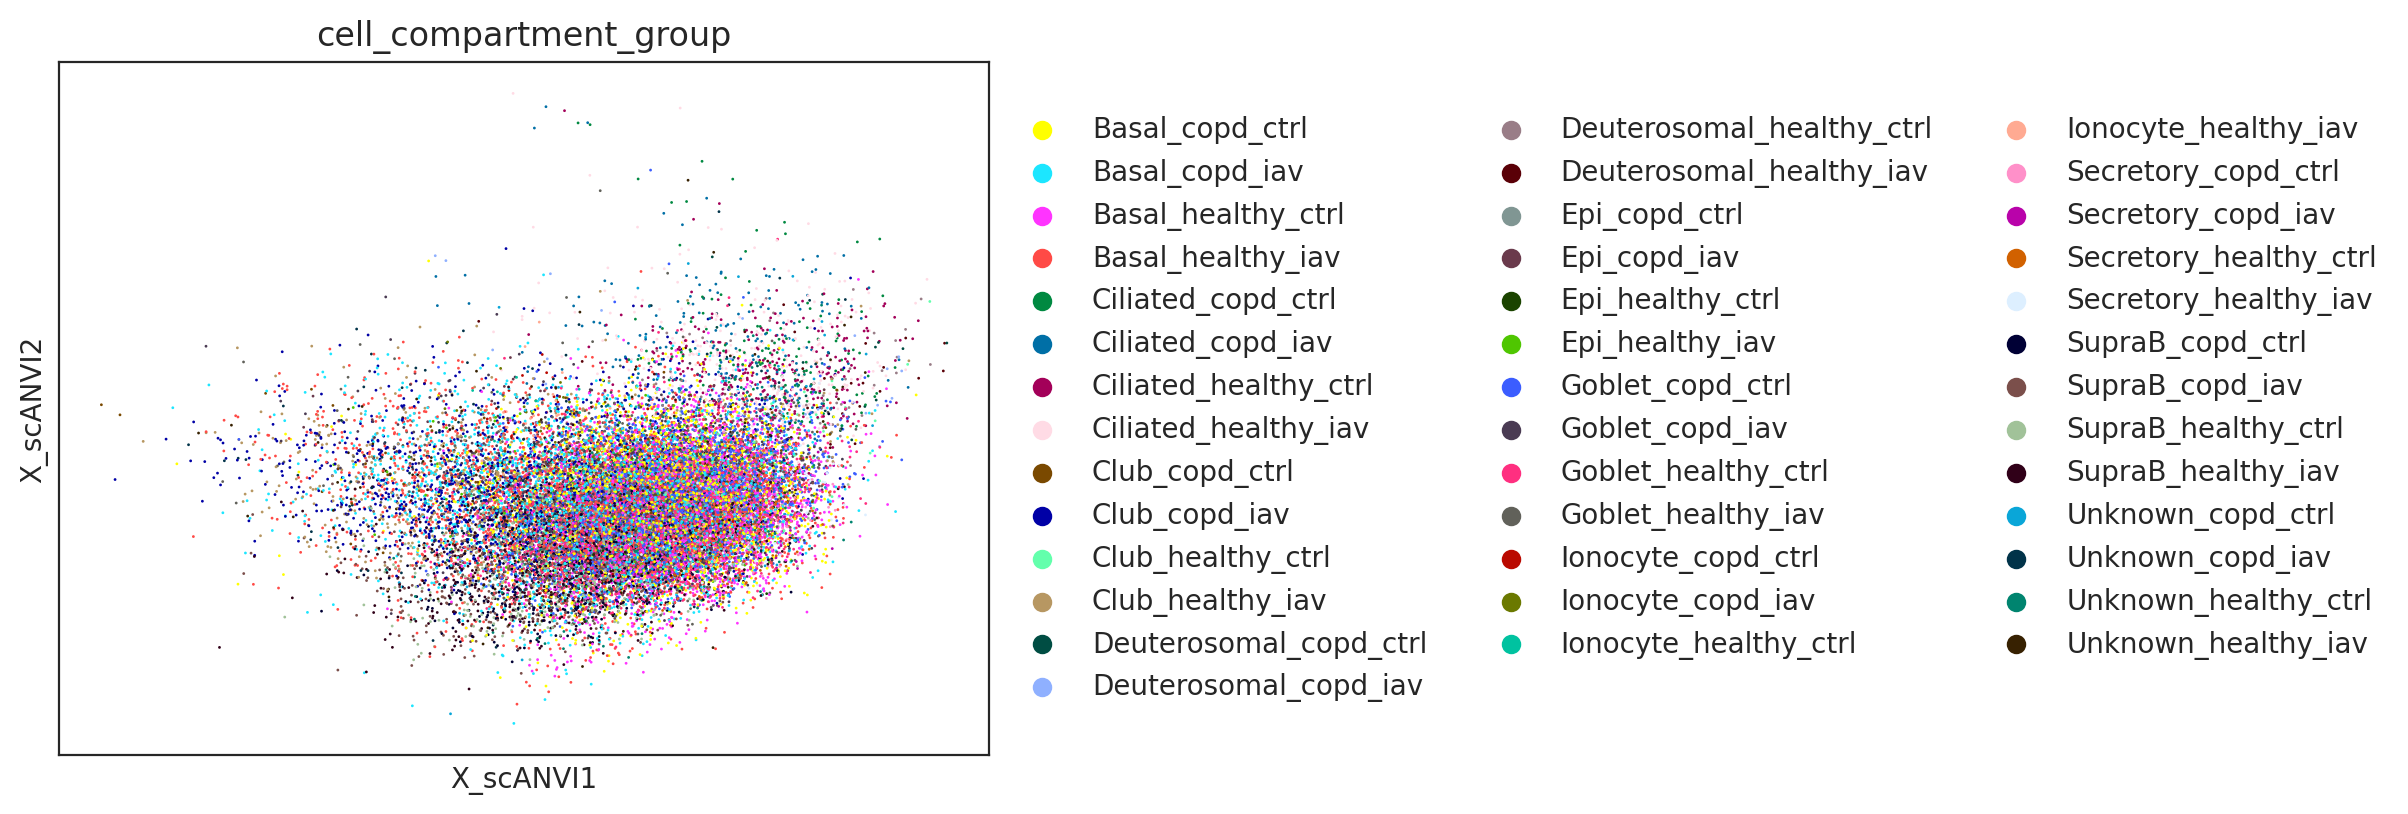

In [16]:
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="cell_compartment_group",
                                   embedding_name="X_scANVI")

In [17]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

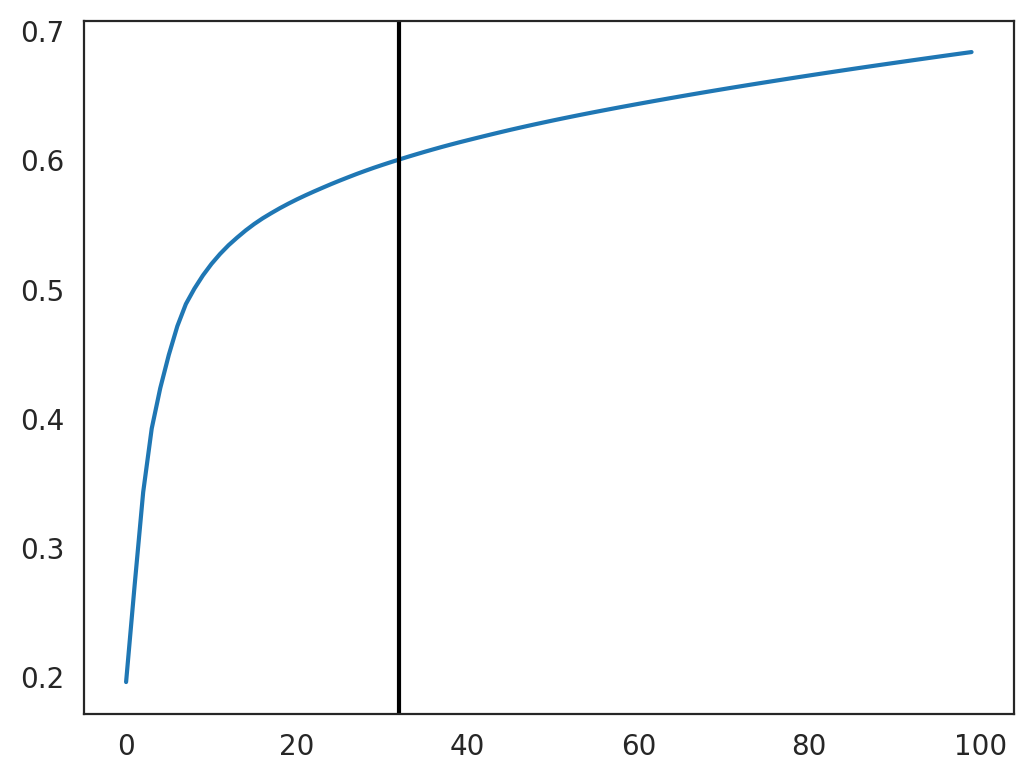

32


In [18]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

In [19]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :30000


In [20]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :750


In [21]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

In [22]:
# Save oracle object.
oracle.to_hdf5("copd.celloracle.oracle")

In [23]:
# Load file.
oracle = co.load_hdf5("copd.celloracle.oracle")

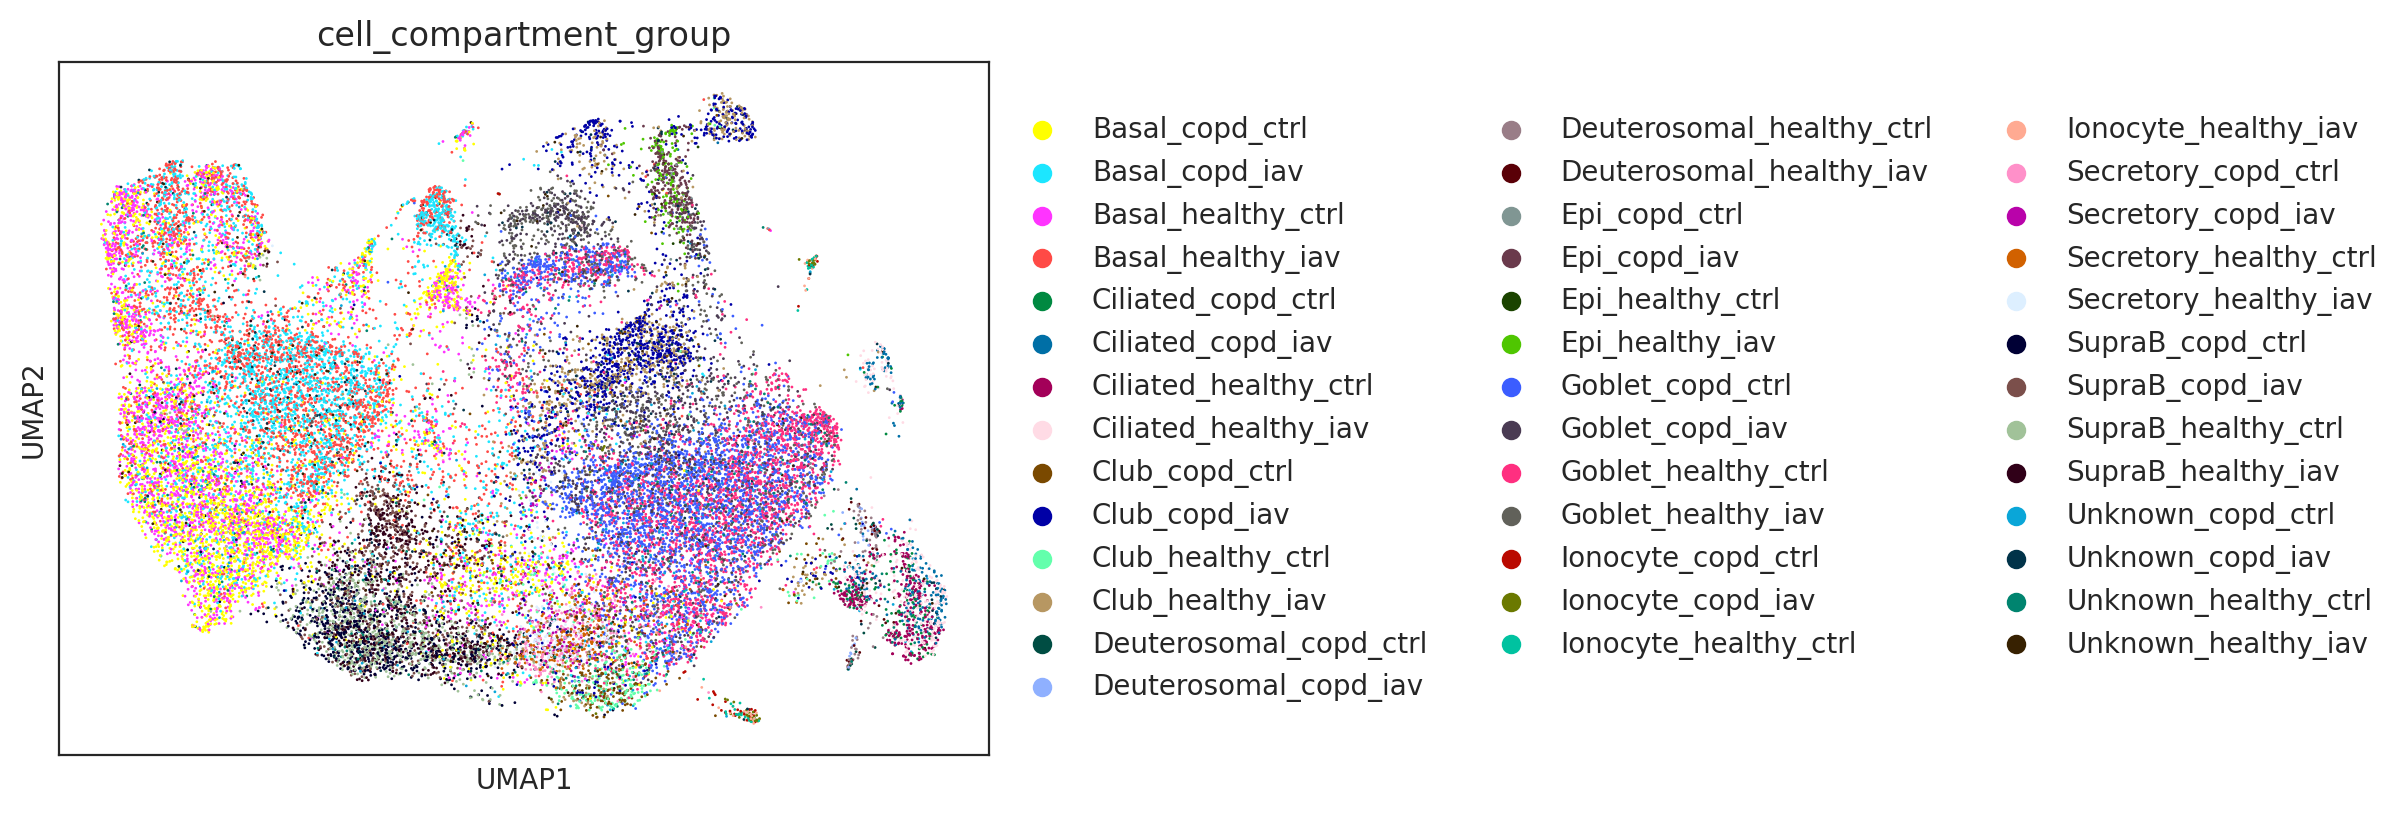

In [24]:
sc.pl.umap(oracle.adata, color='cell_compartment_group')

In [25]:
# Check clustering data
#sc.pl.draw_graph(oracle.adata)

In [26]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)
links = oracle.get_links(cluster_name_for_GRN_unit="cell_compartment_group", alpha=10,
                         verbose_level=10)

  0%|          | 0/40 [00:00<?, ?it/s]

Inferring GRN for Basal_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Basal_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Basal_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Basal_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Ciliated_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Ciliated_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Ciliated_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Ciliated_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Club_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Club_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Club_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Club_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Deuterosomal_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Deuterosomal_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Deuterosomal_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Deuterosomal_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Epi_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Epi_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Epi_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Epi_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Goblet_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Goblet_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Goblet_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Goblet_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Ionocyte_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Ionocyte_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Ionocyte_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Ionocyte_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Secretory_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Secretory_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Secretory_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Secretory_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for SupraB_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for SupraB_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for SupraB_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for SupraB_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Unknown_copd_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Unknown_copd_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Unknown_healthy_ctrl...


  0%|          | 0/1568 [00:00<?, ?it/s]

Inferring GRN for Unknown_healthy_iav...


  0%|          | 0/1568 [00:00<?, ?it/s]

CPU times: user 32min 36s, sys: 1min 36s, total: 34min 13s
Wall time: 40min 32s


In [27]:
for key in links.links_dict.keys():
    cluster = key
    links.links_dict[cluster].to_csv(f".data/raw_GRN_for_{cluster}.csv")

In [28]:
# Set cluster name
#cluster = "Basal_0"

# Save as csv
#links.links_dict[cluster].to_csv(f"raw_GRN_for_{cluster}.csv")

In [29]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [30]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [31]:
plt.rcParams["figure.figsize"] = [9, 4.5]

Basal_copd_ctrl


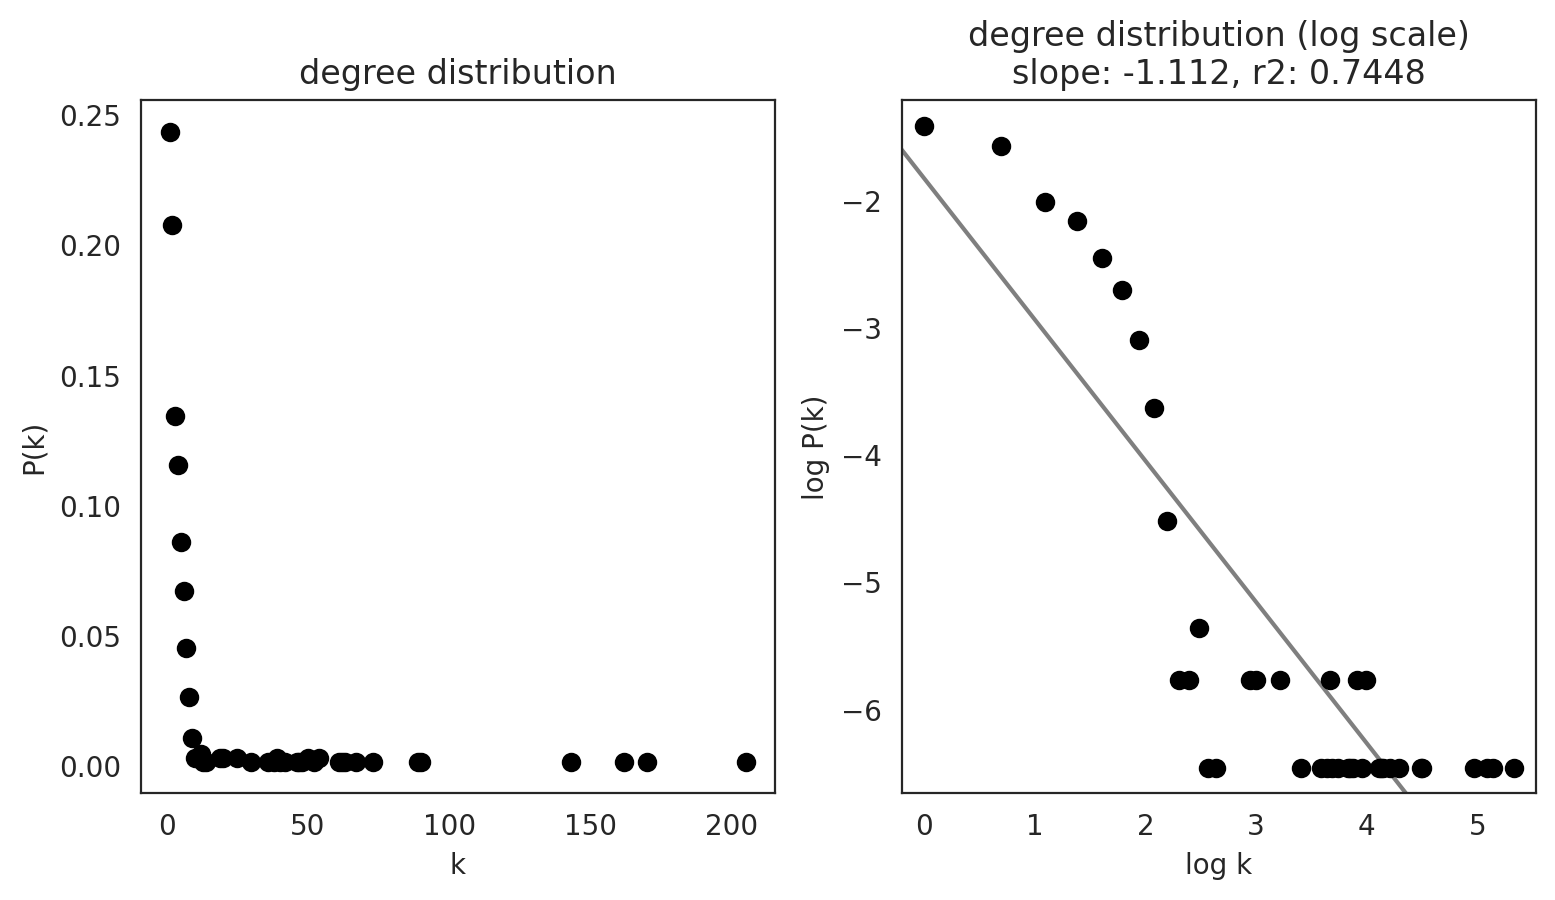

Basal_copd_iav


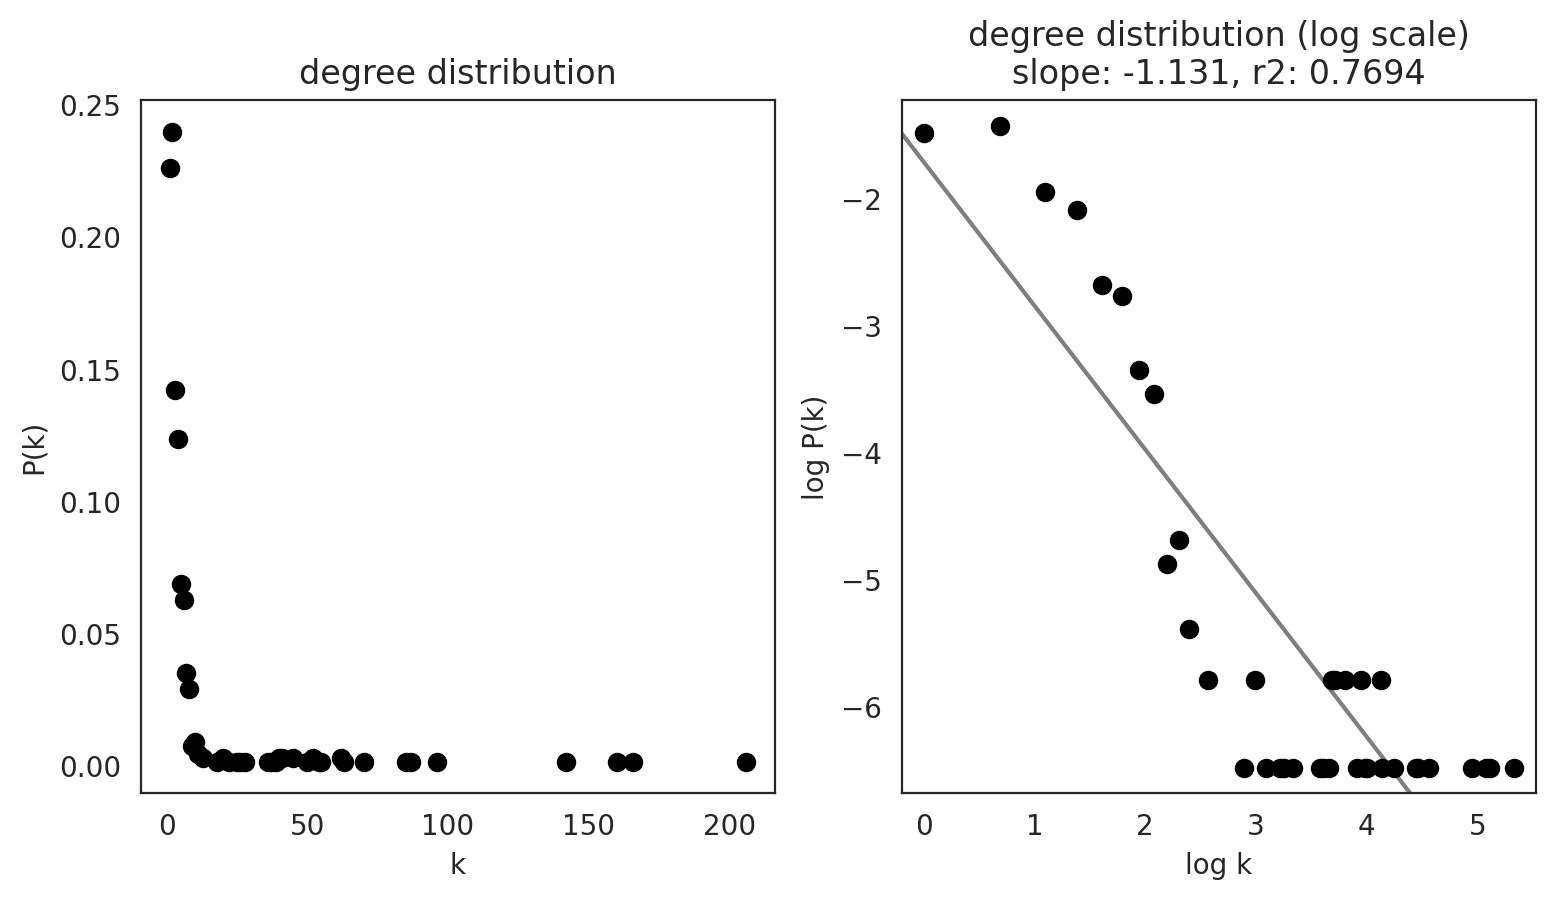

Basal_healthy_ctrl


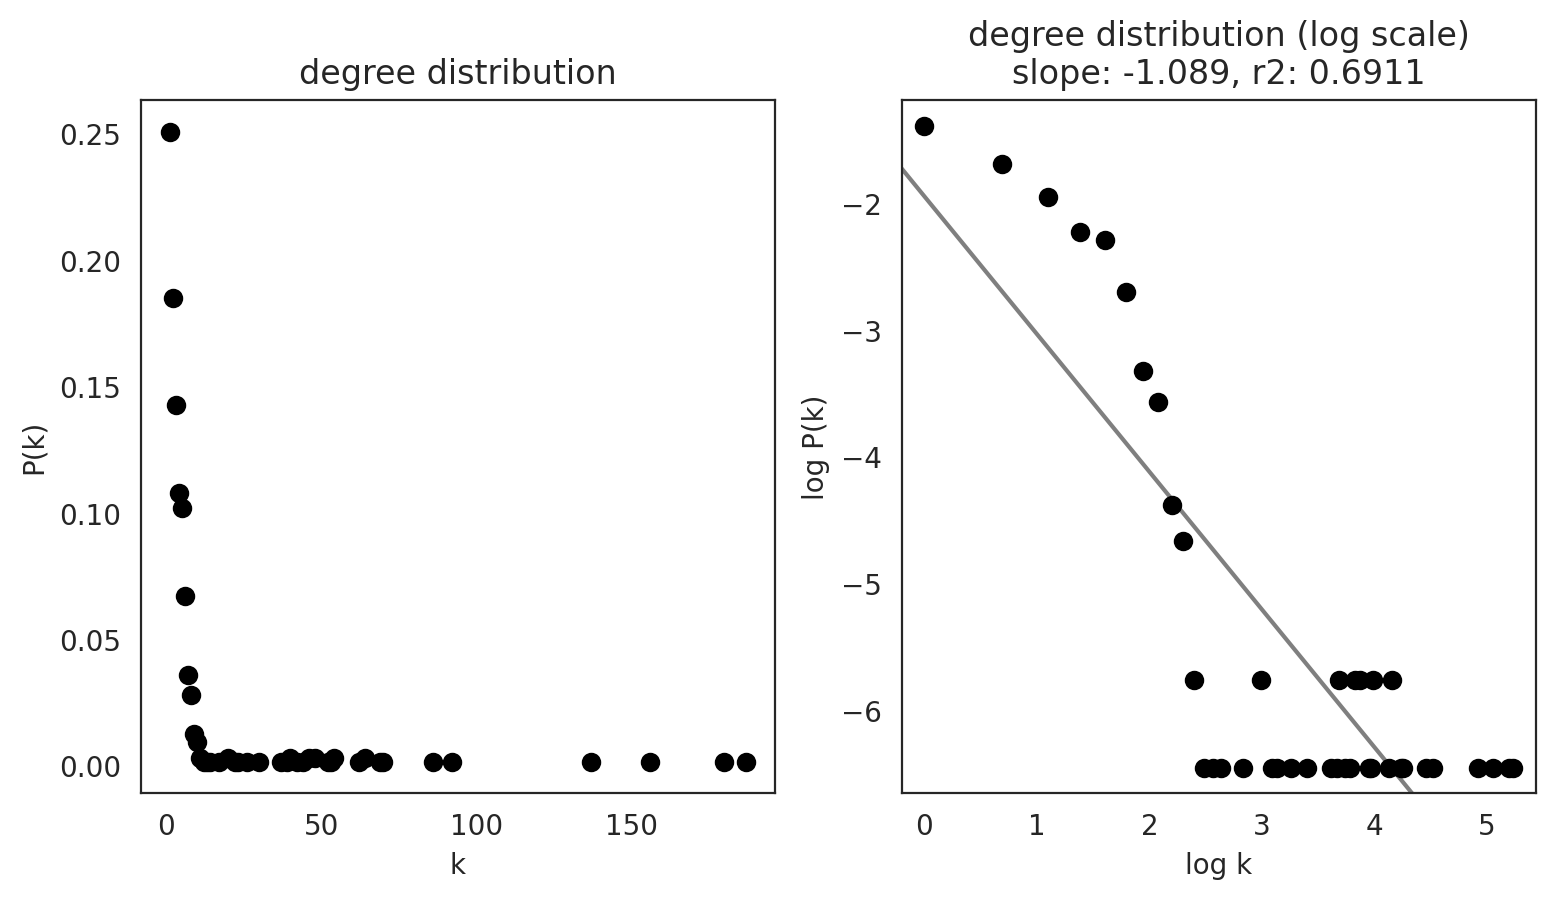

Basal_healthy_iav


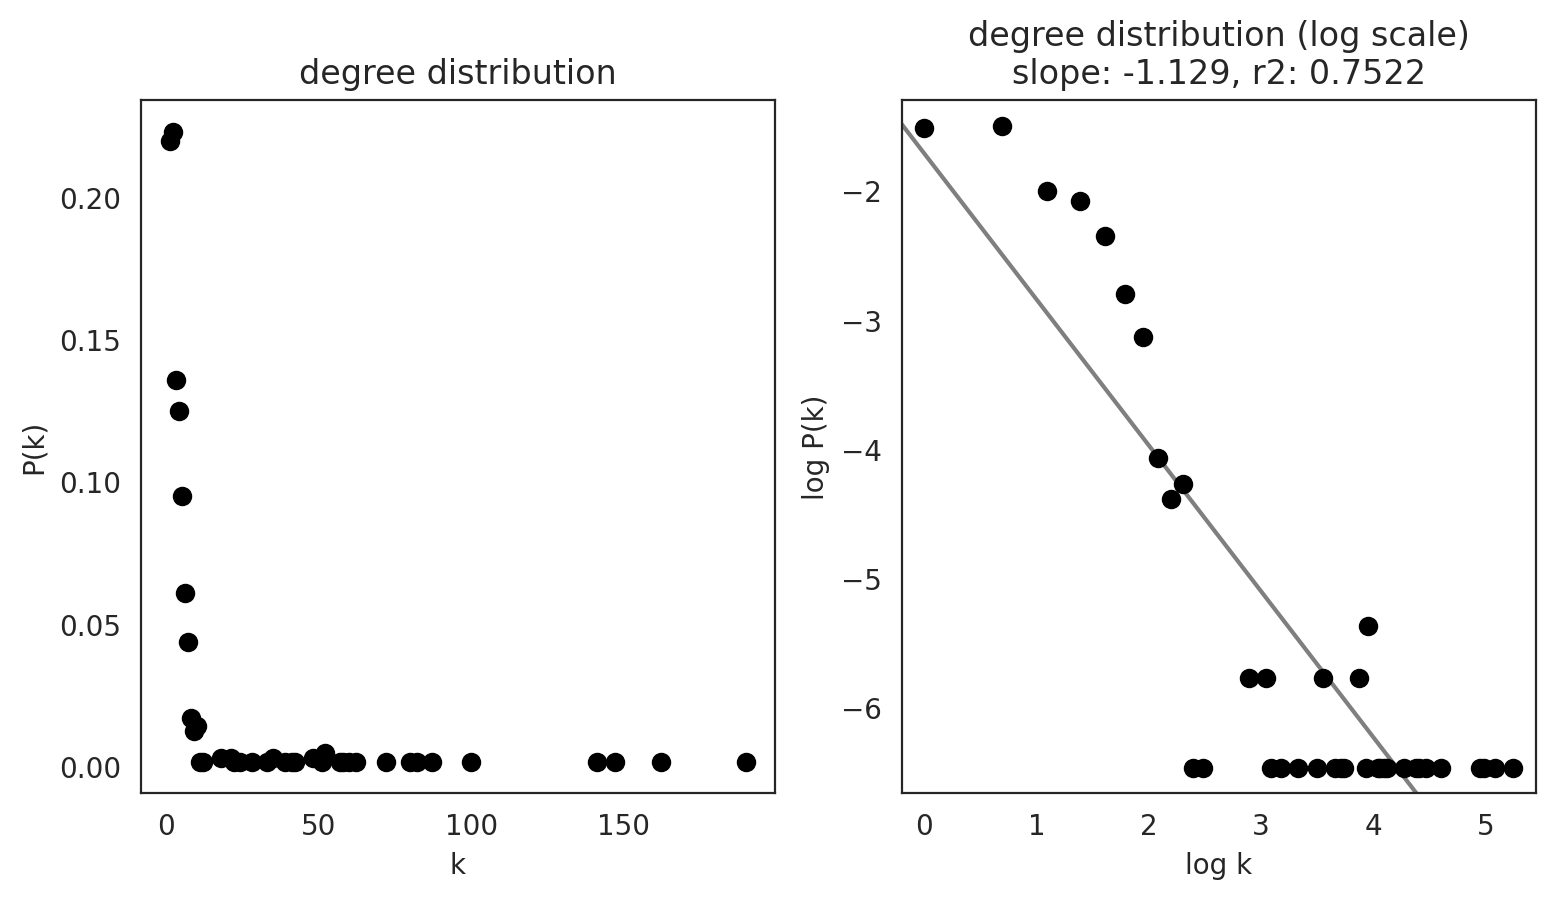

Ciliated_copd_ctrl


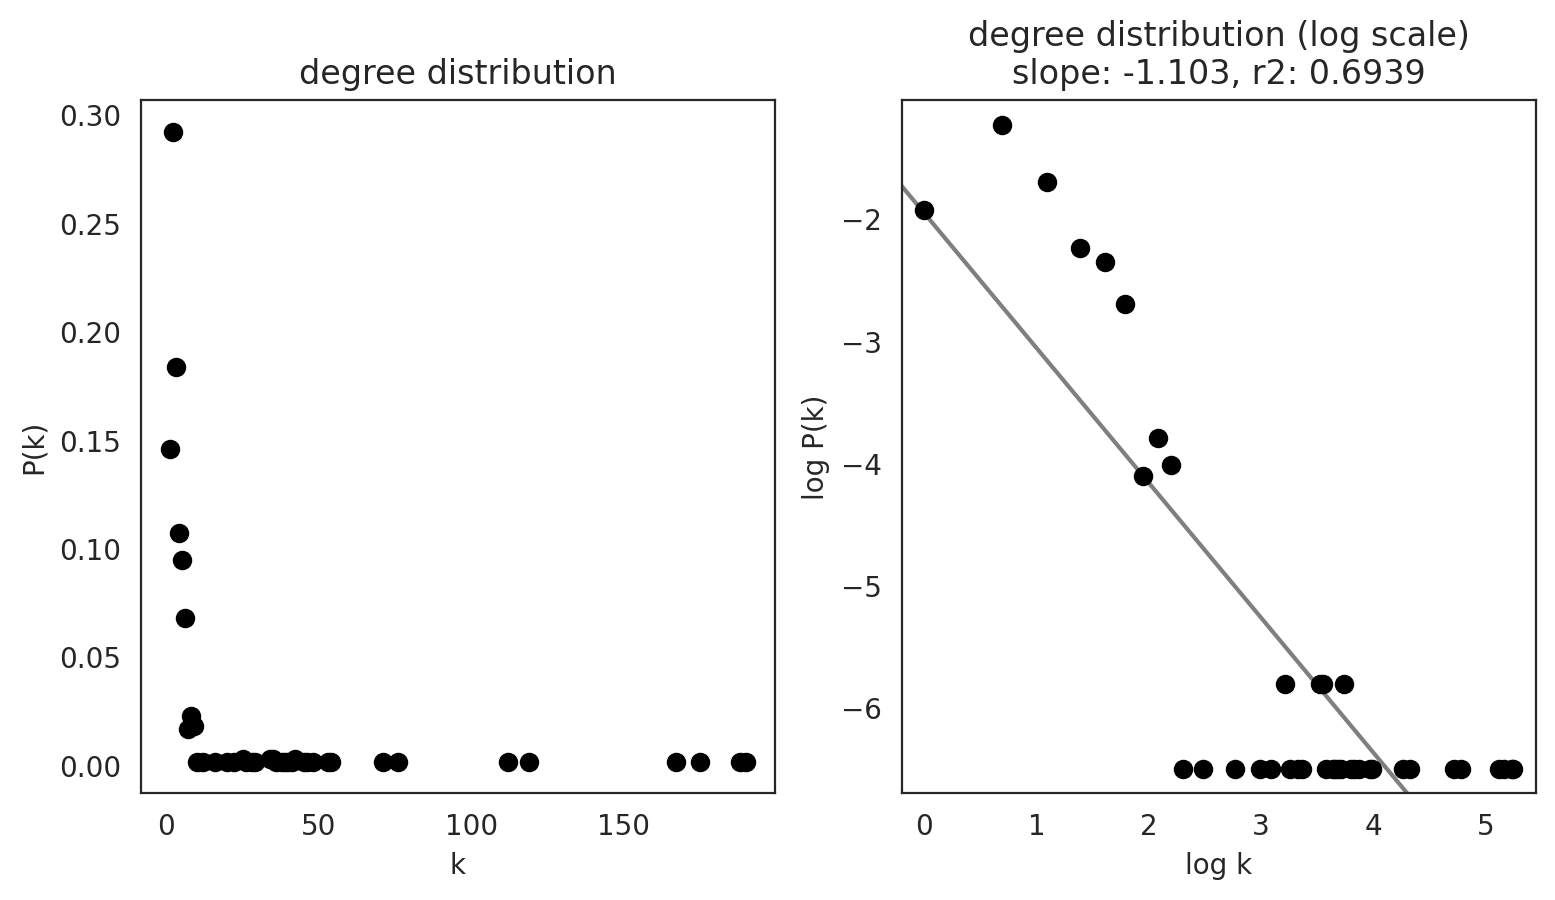

Ciliated_copd_iav


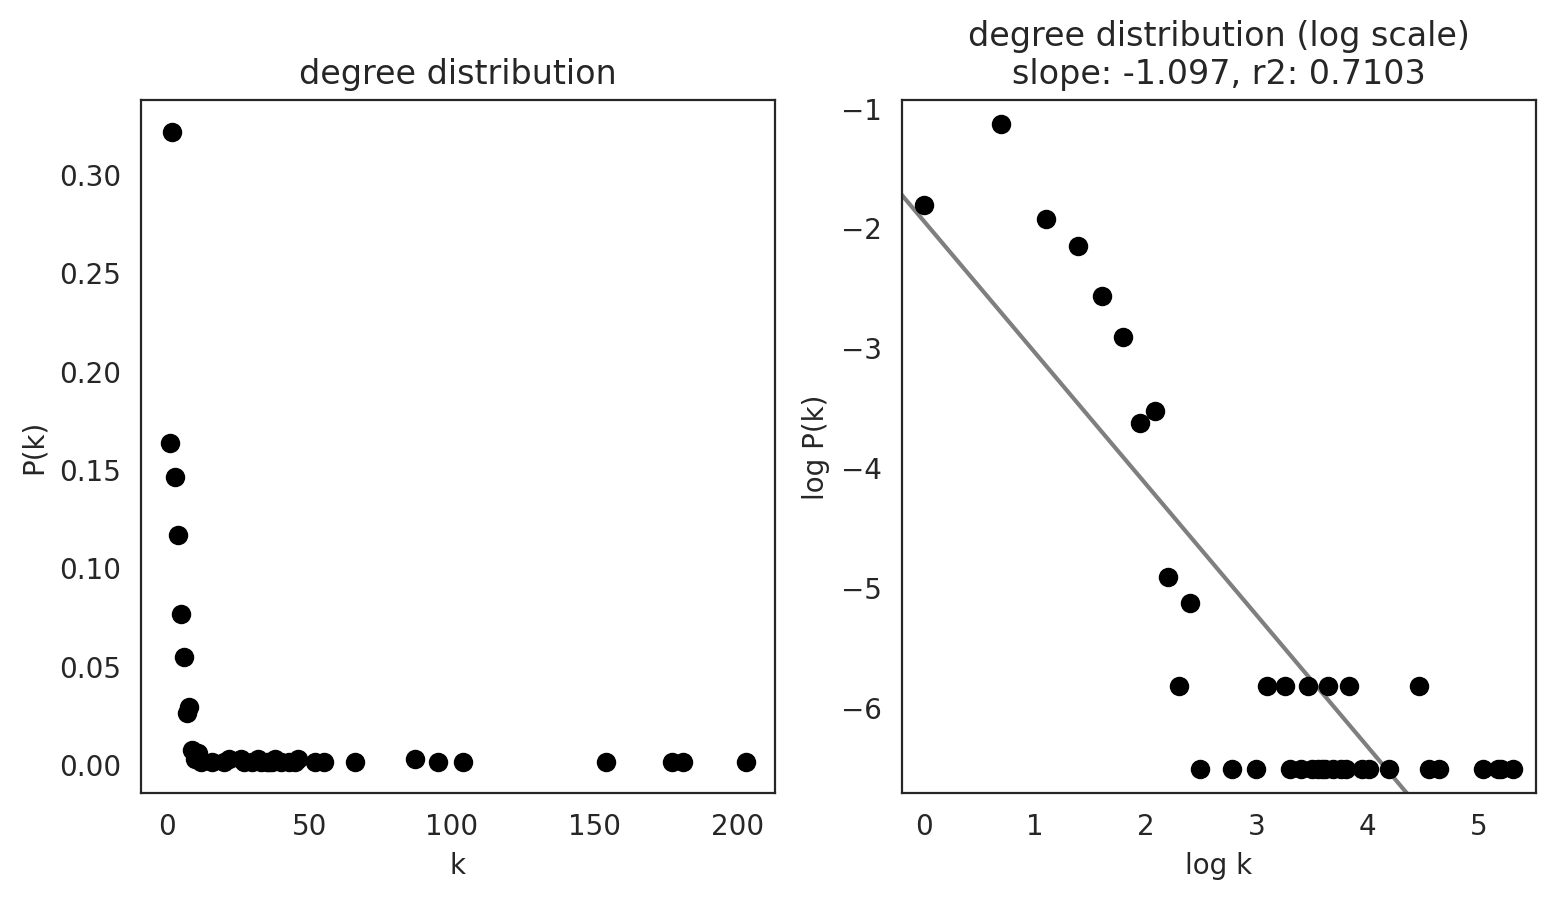

Ciliated_healthy_ctrl


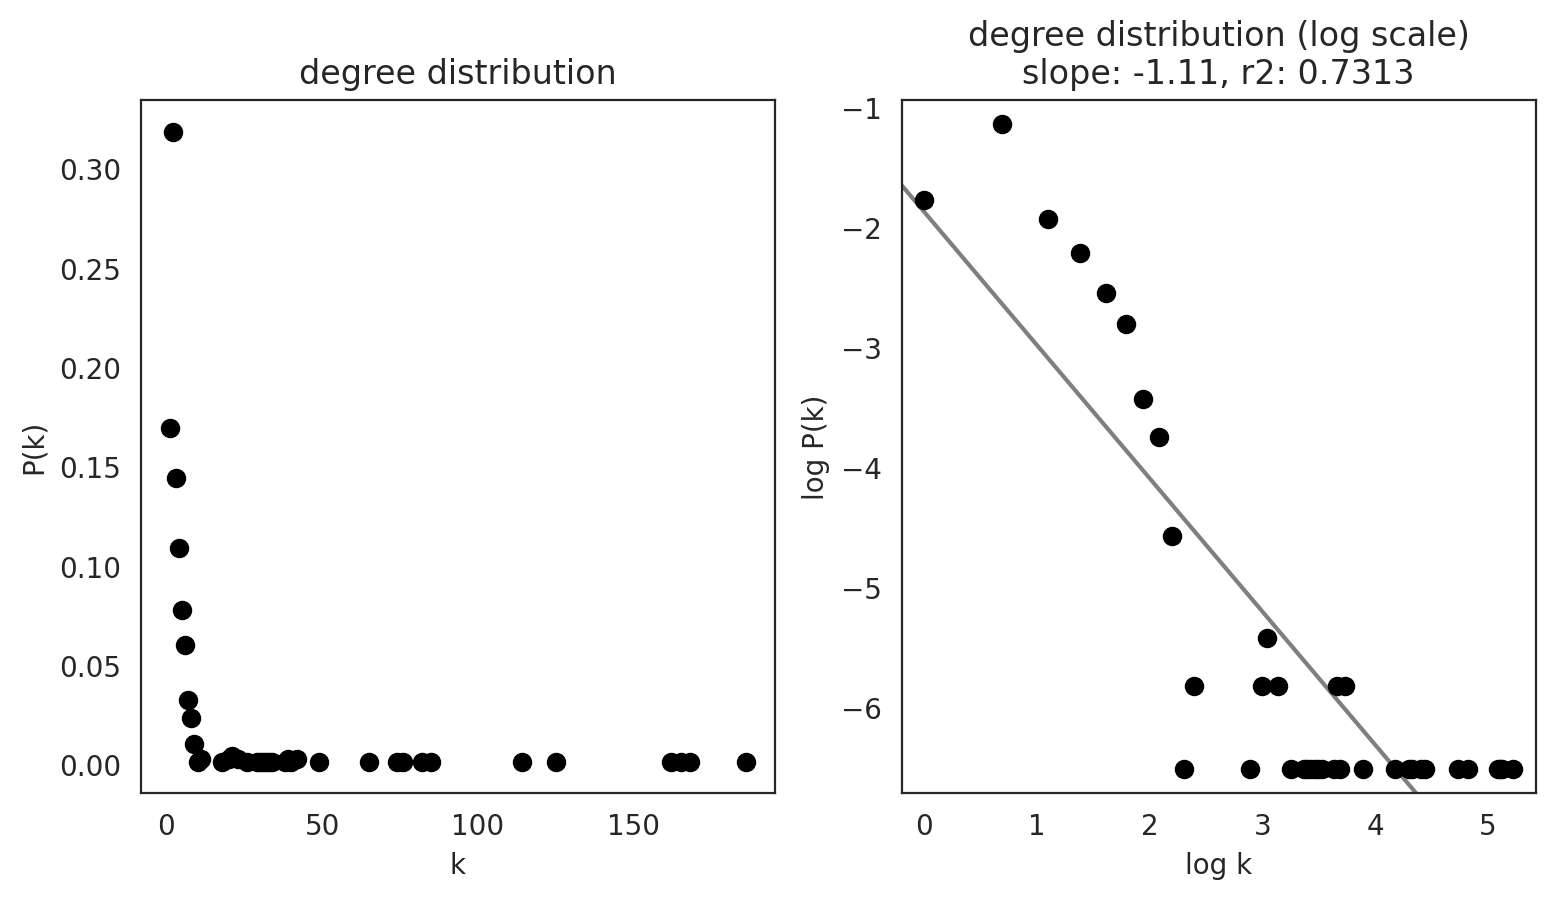

Ciliated_healthy_iav


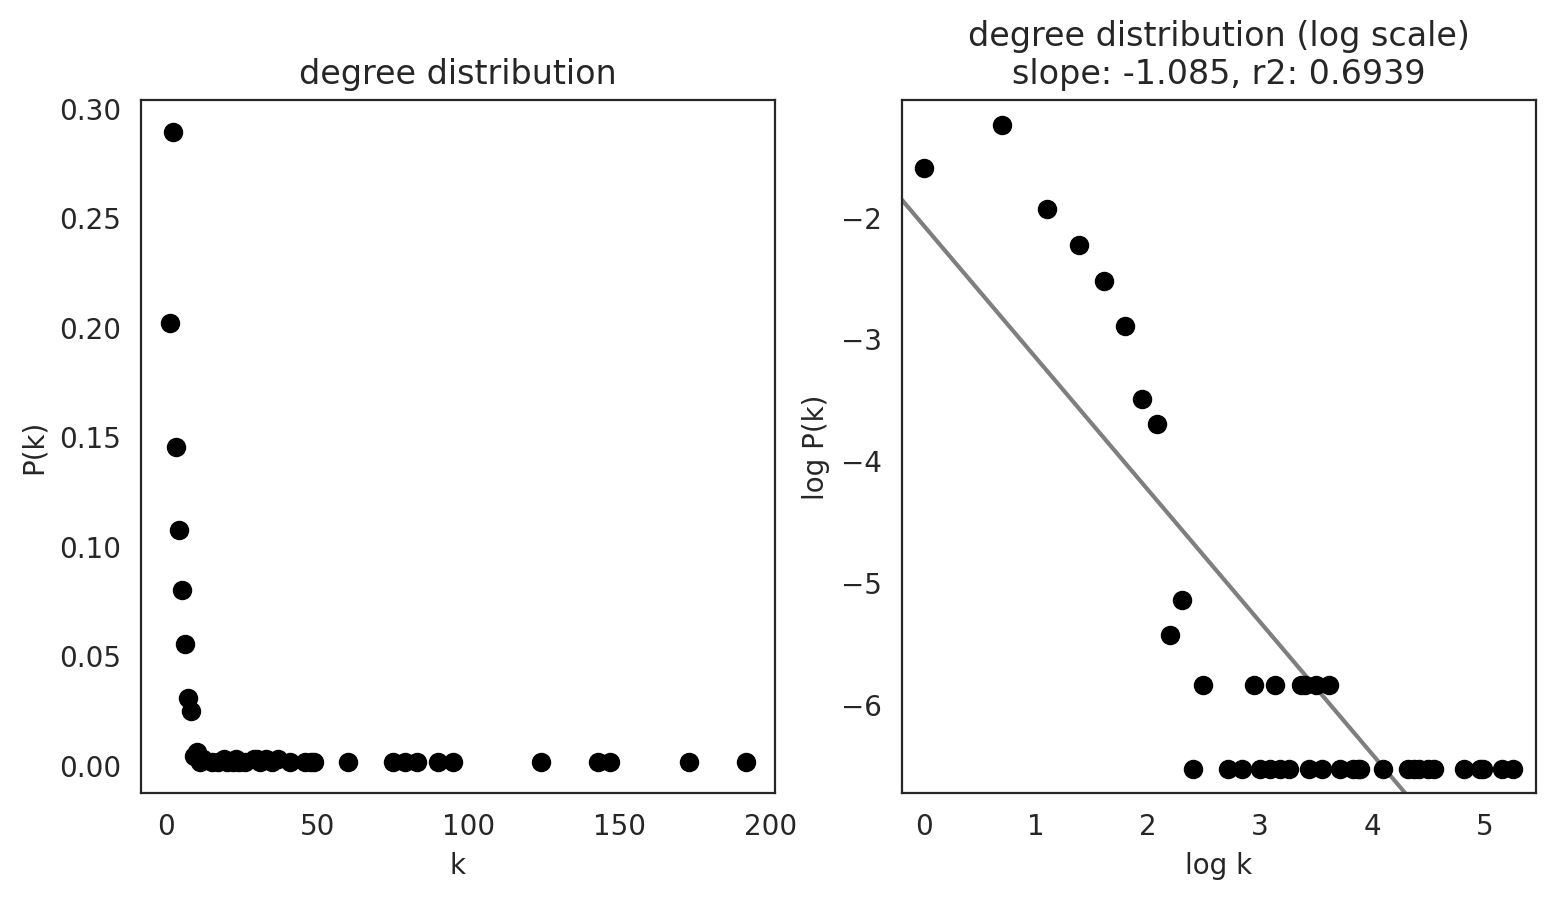

Club_copd_ctrl


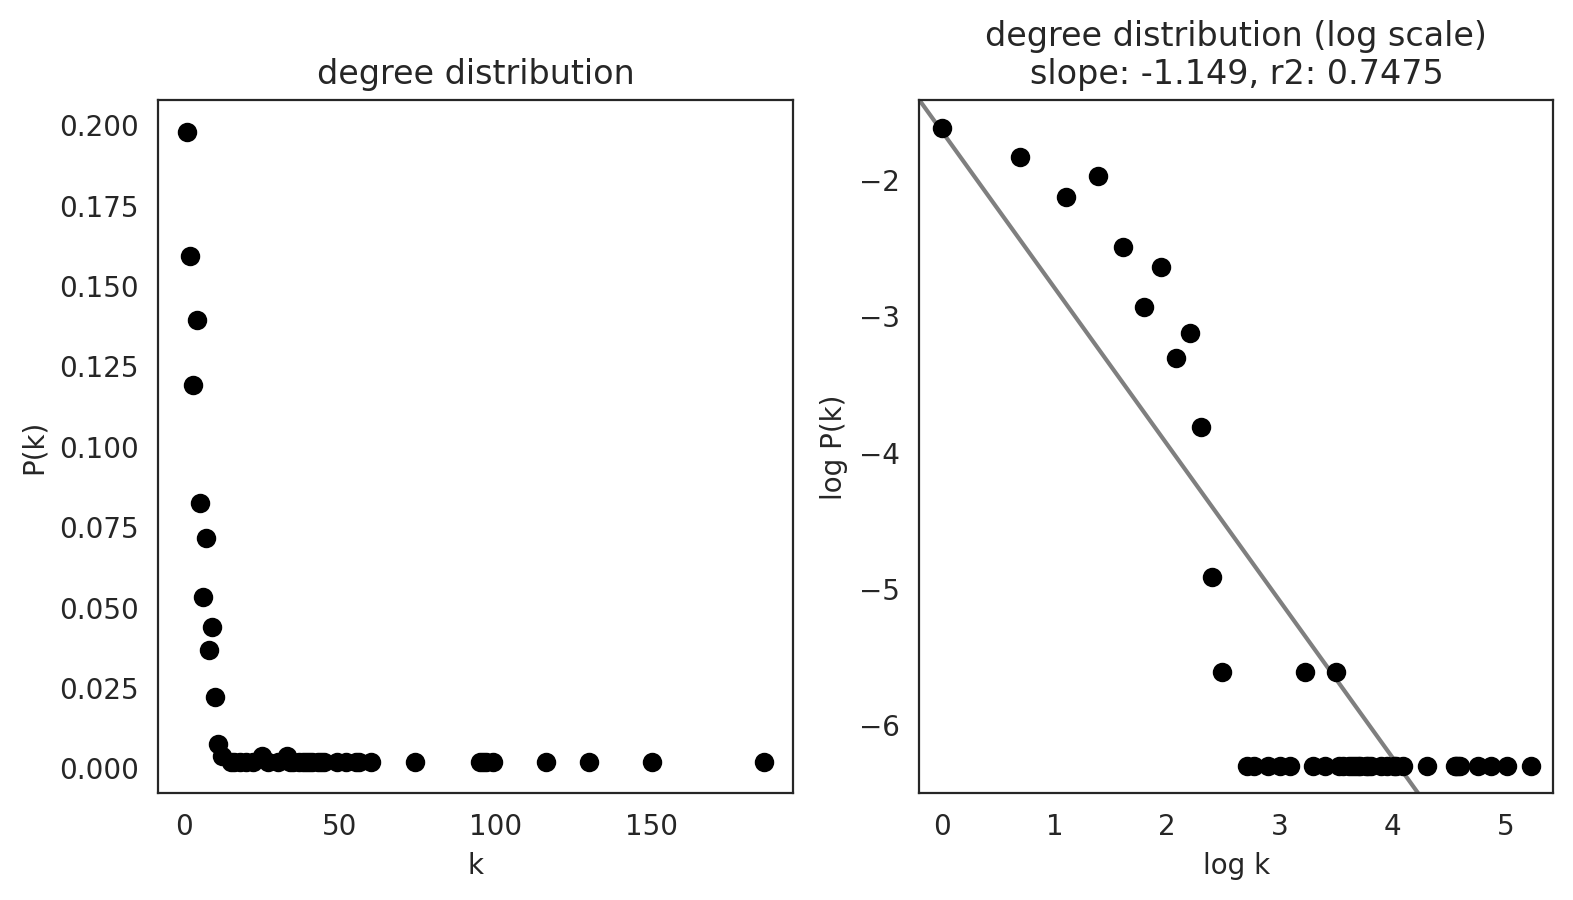

Club_copd_iav


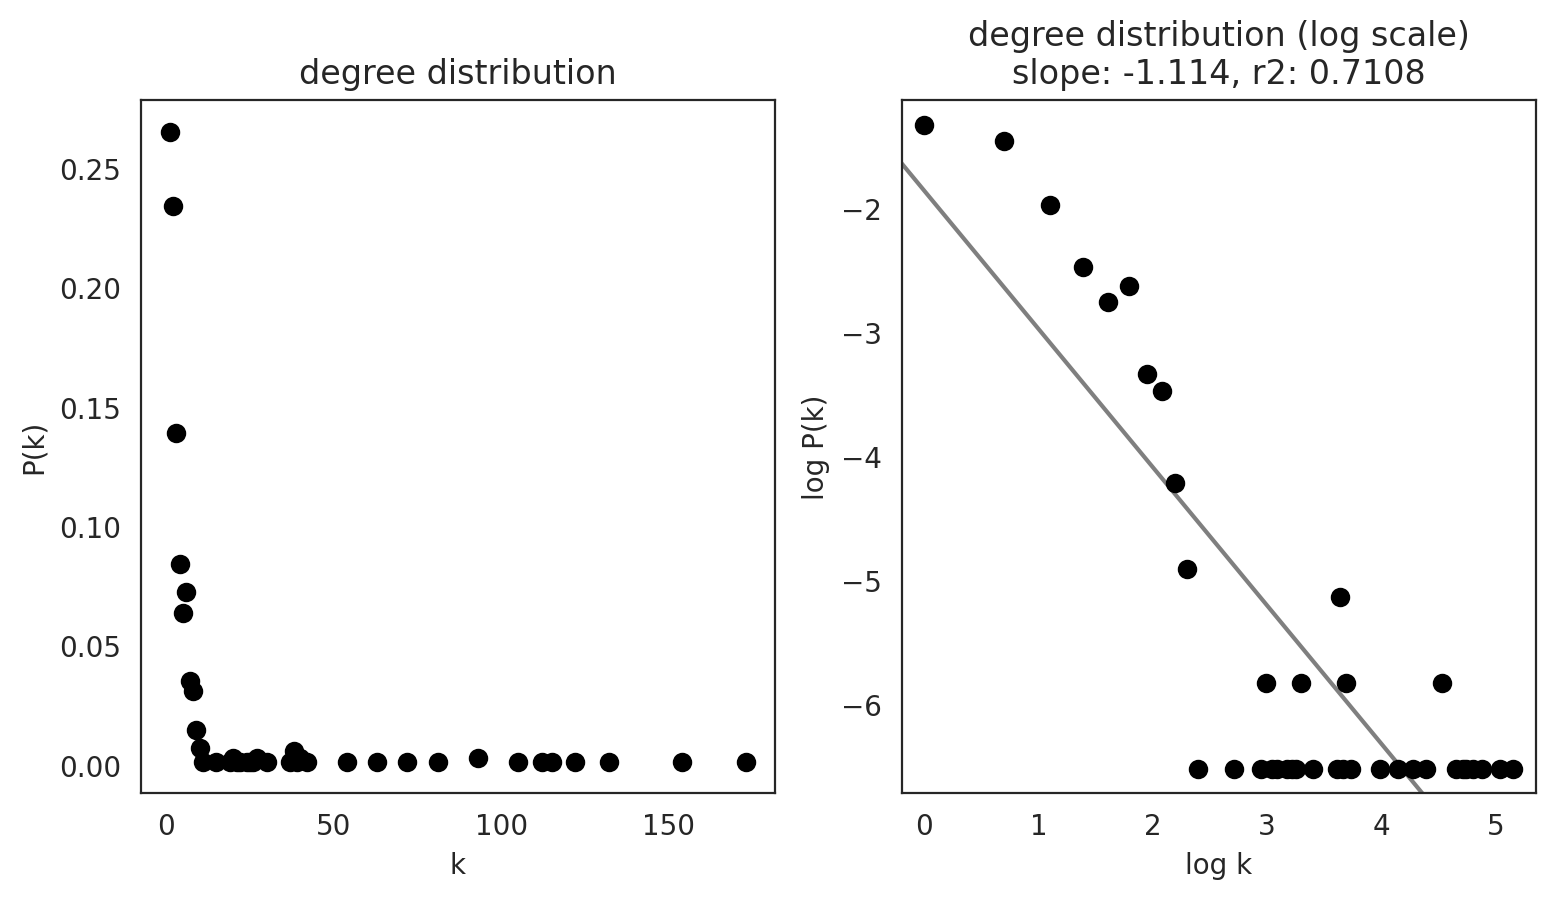

Club_healthy_ctrl


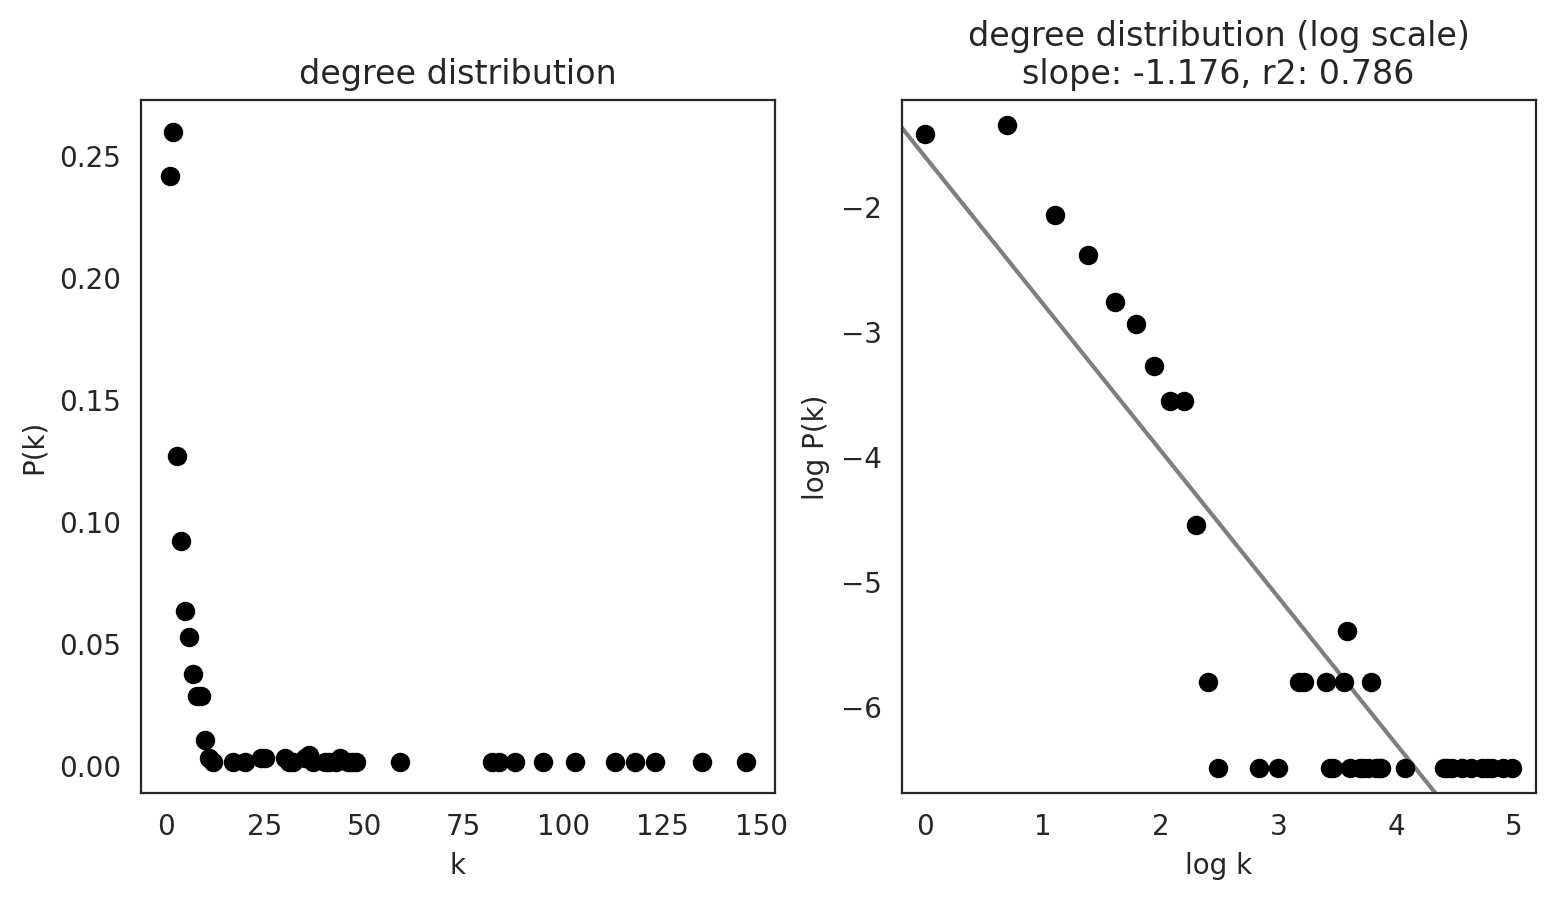

Club_healthy_iav


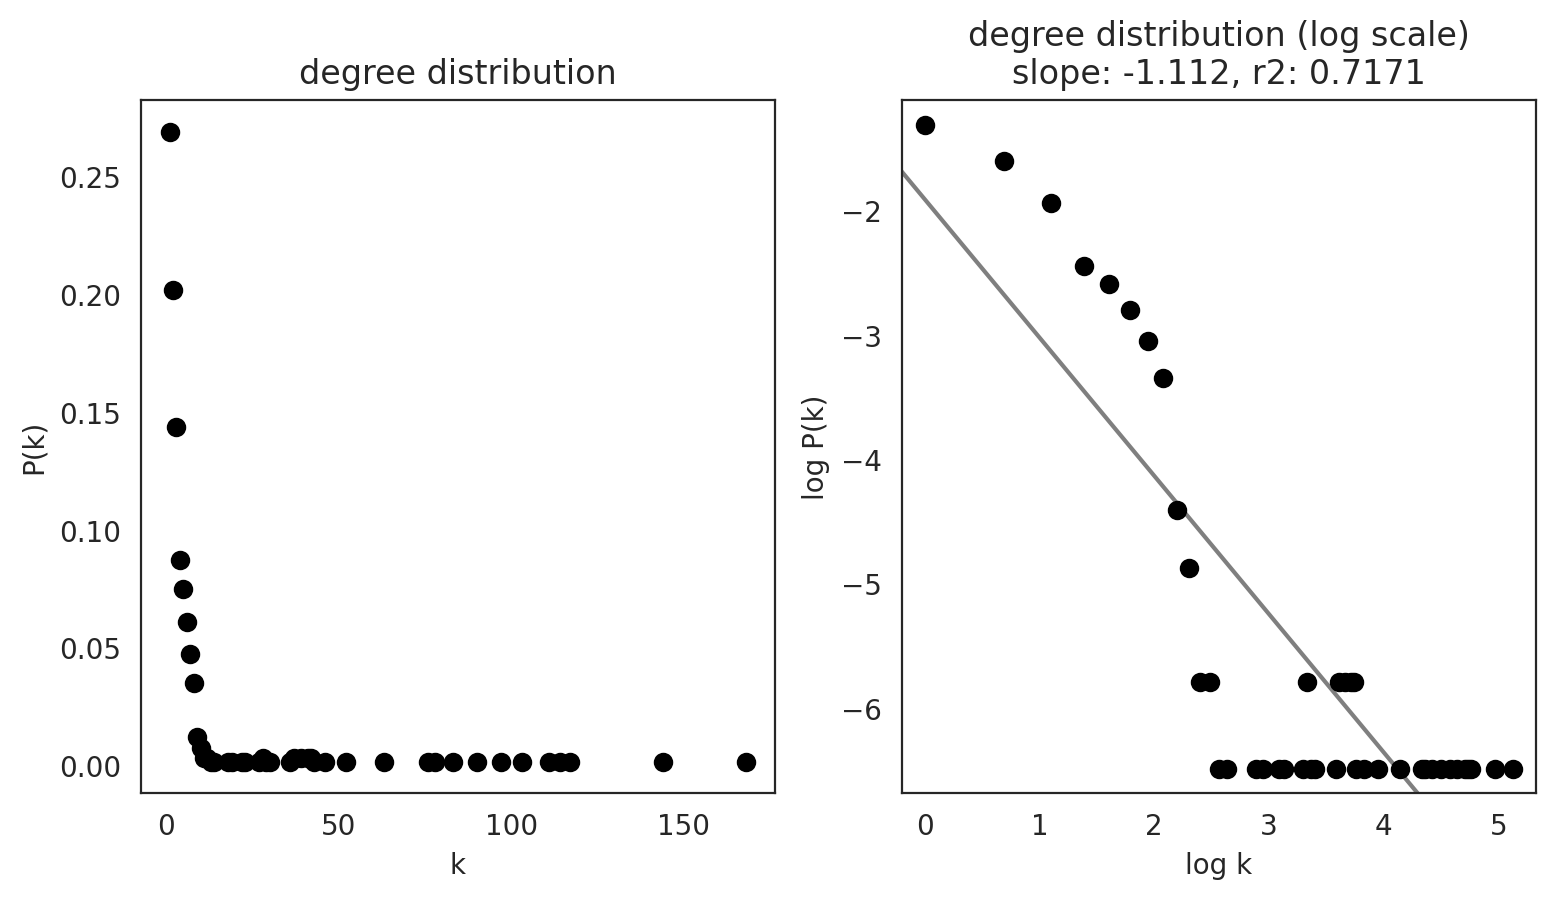

Deuterosomal_copd_ctrl


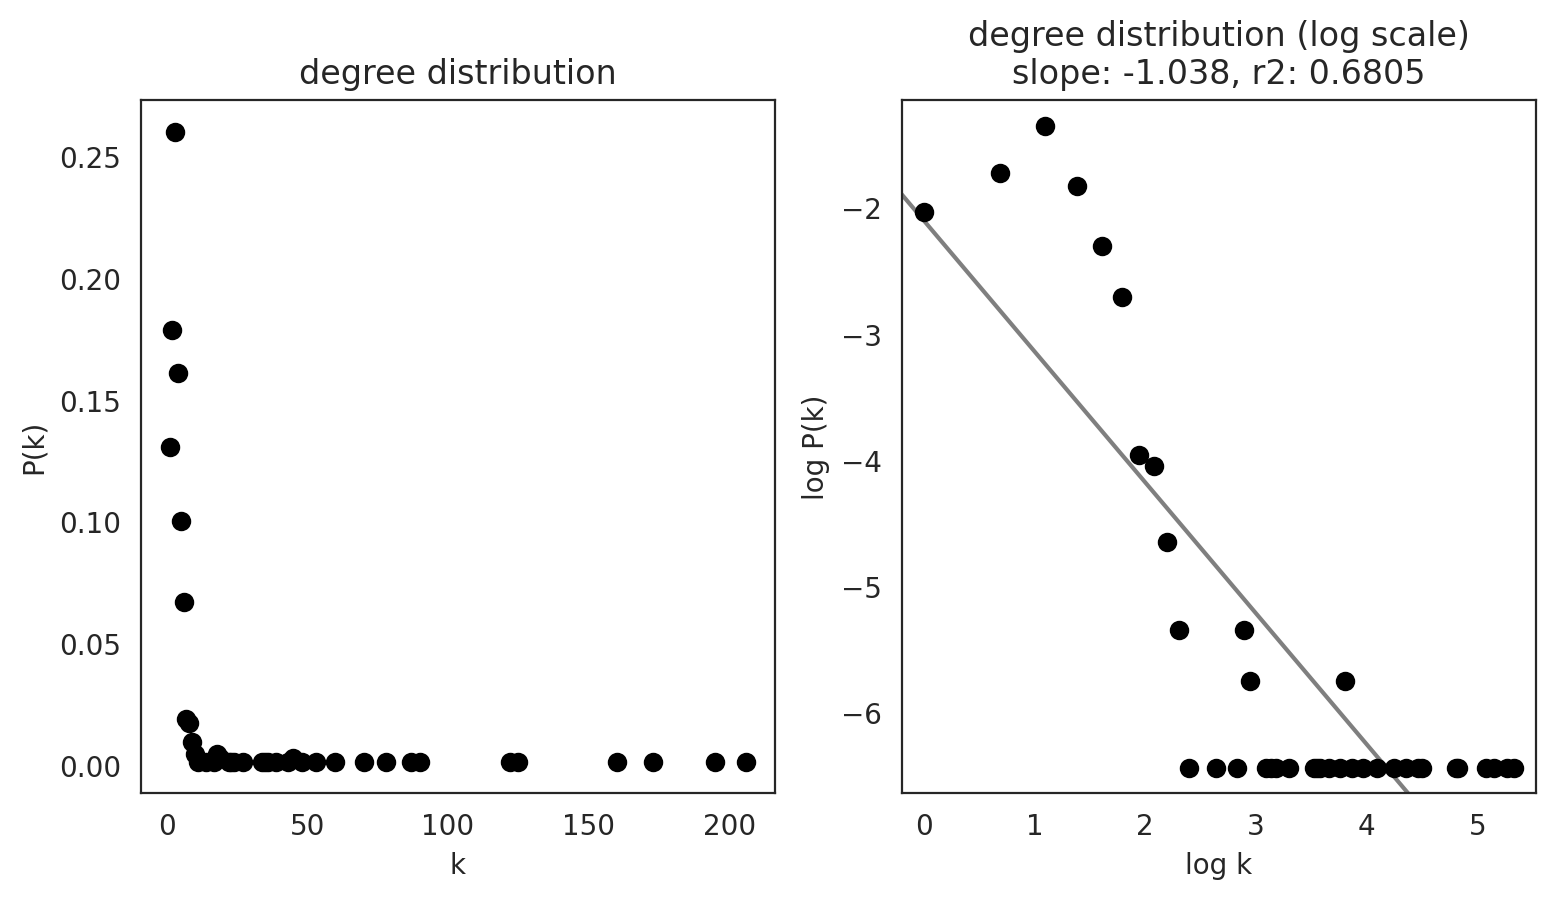

Deuterosomal_copd_iav


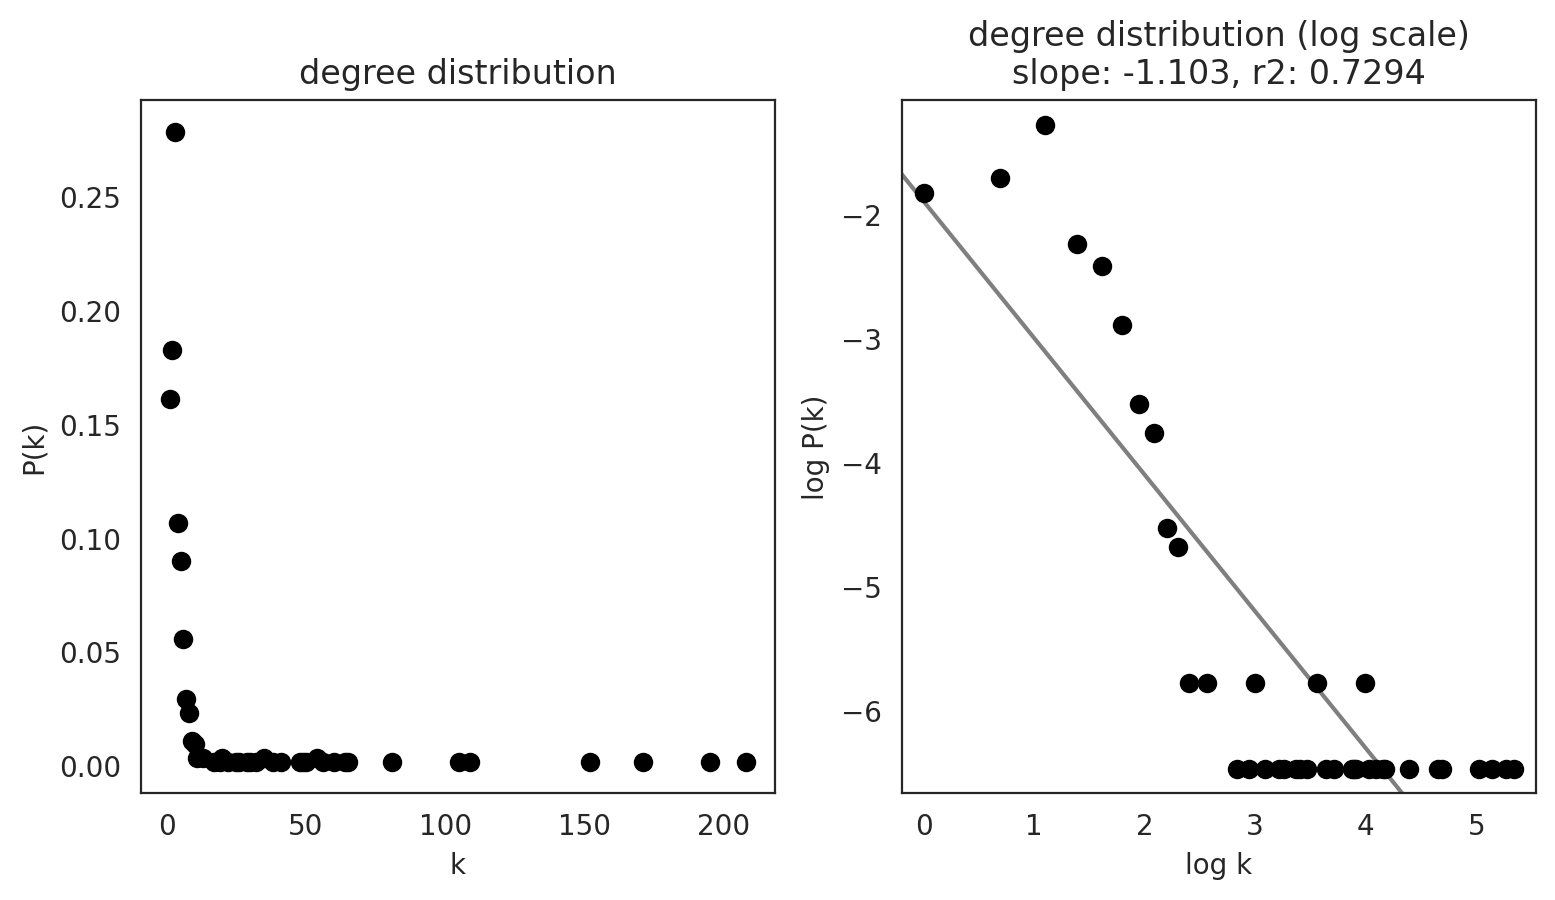

Deuterosomal_healthy_ctrl


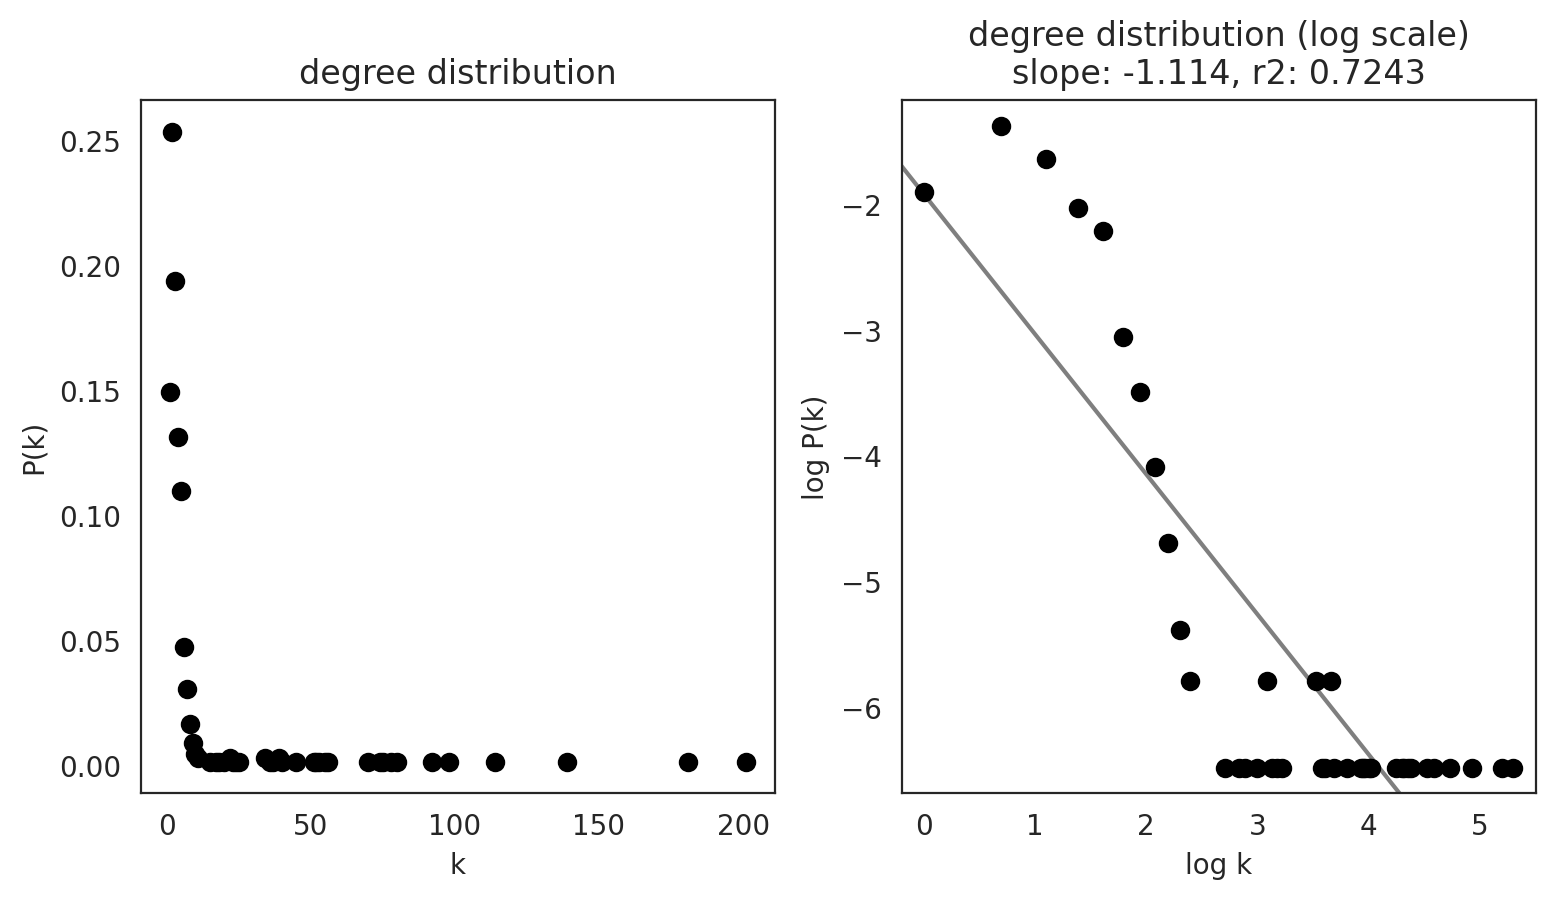

Deuterosomal_healthy_iav


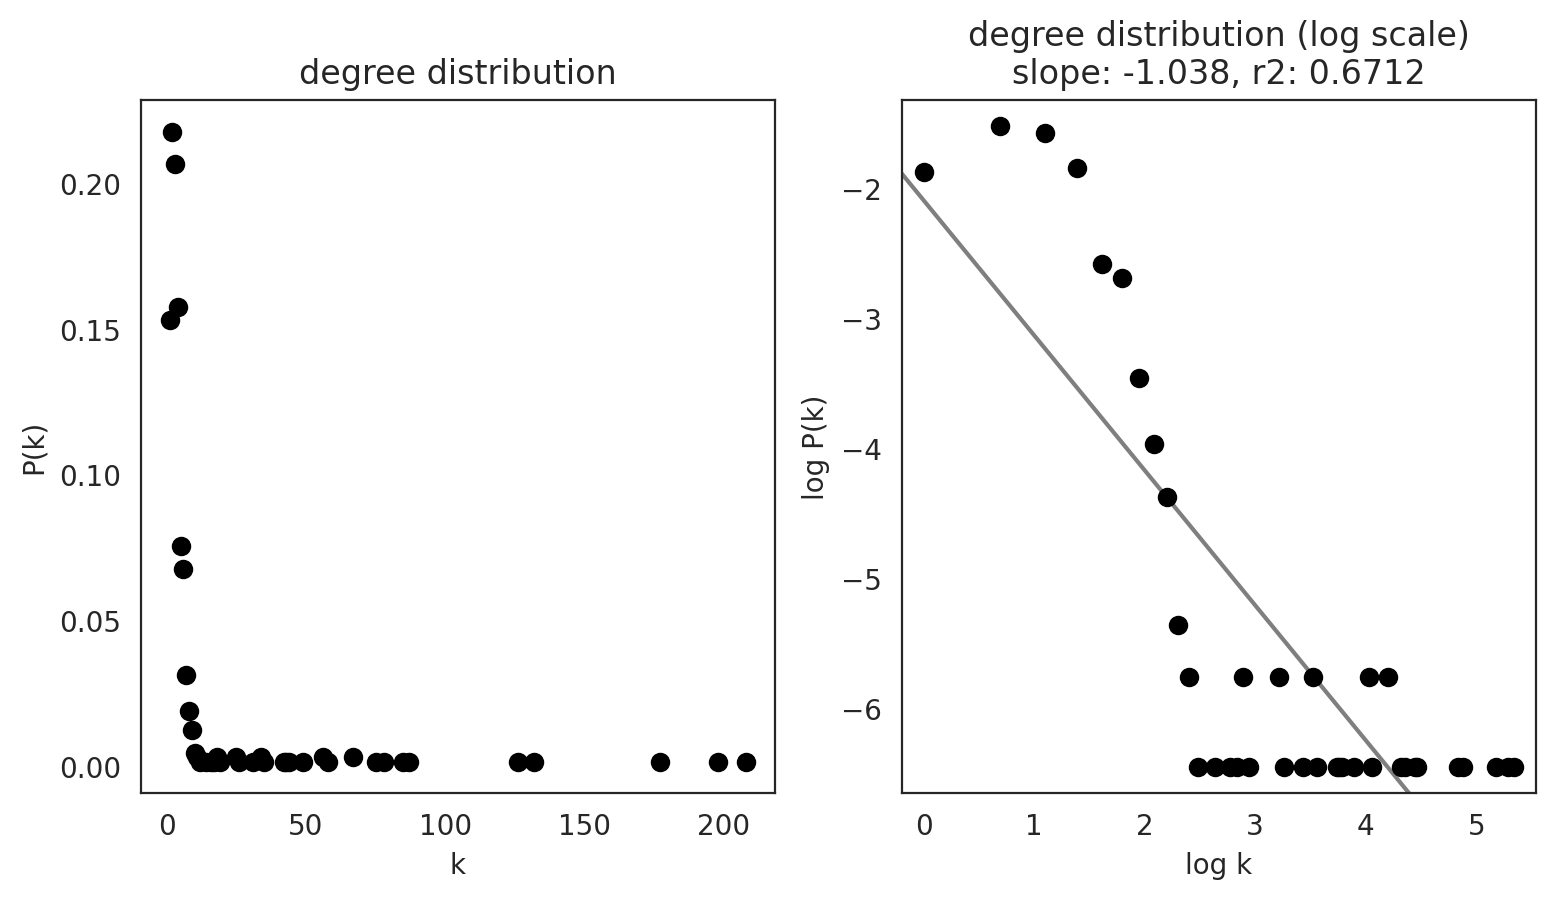

Epi_copd_ctrl


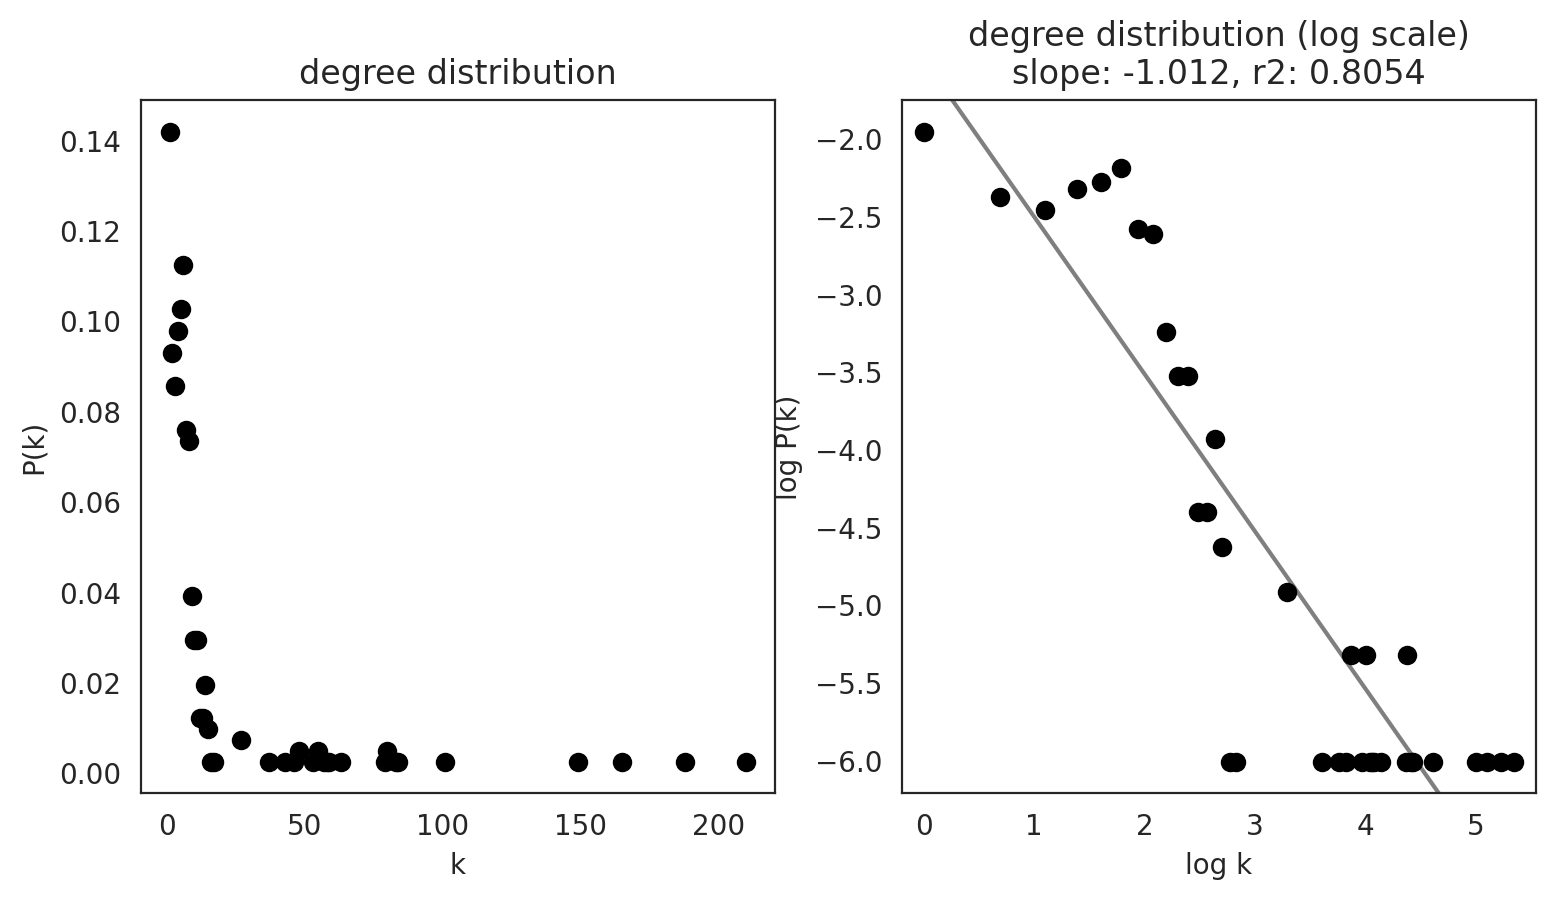

Epi_copd_iav


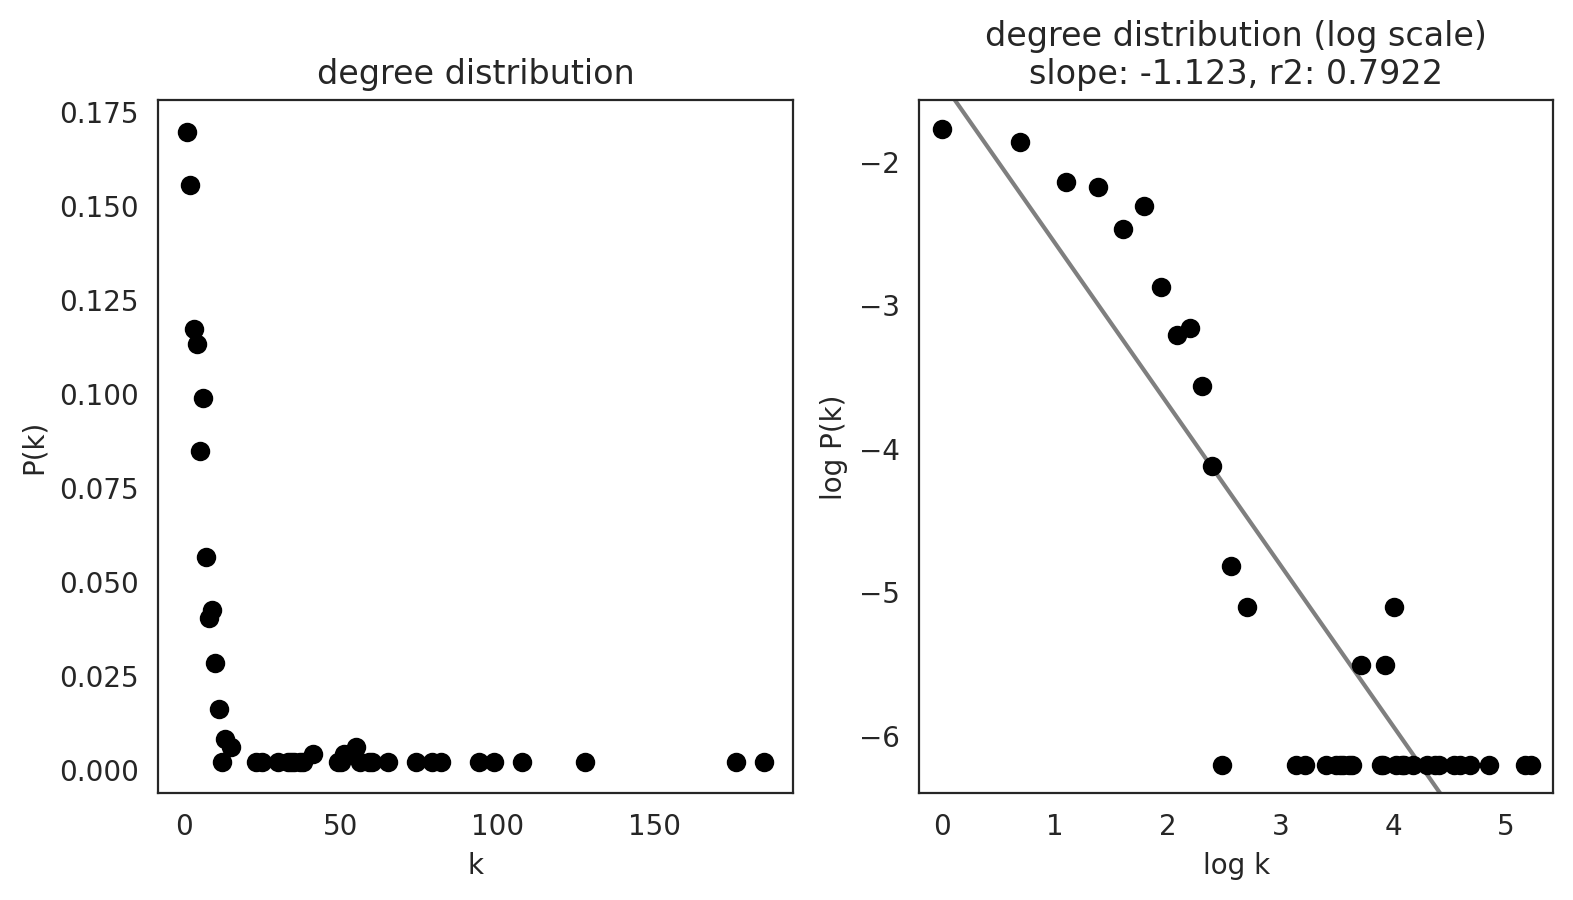

Epi_healthy_ctrl


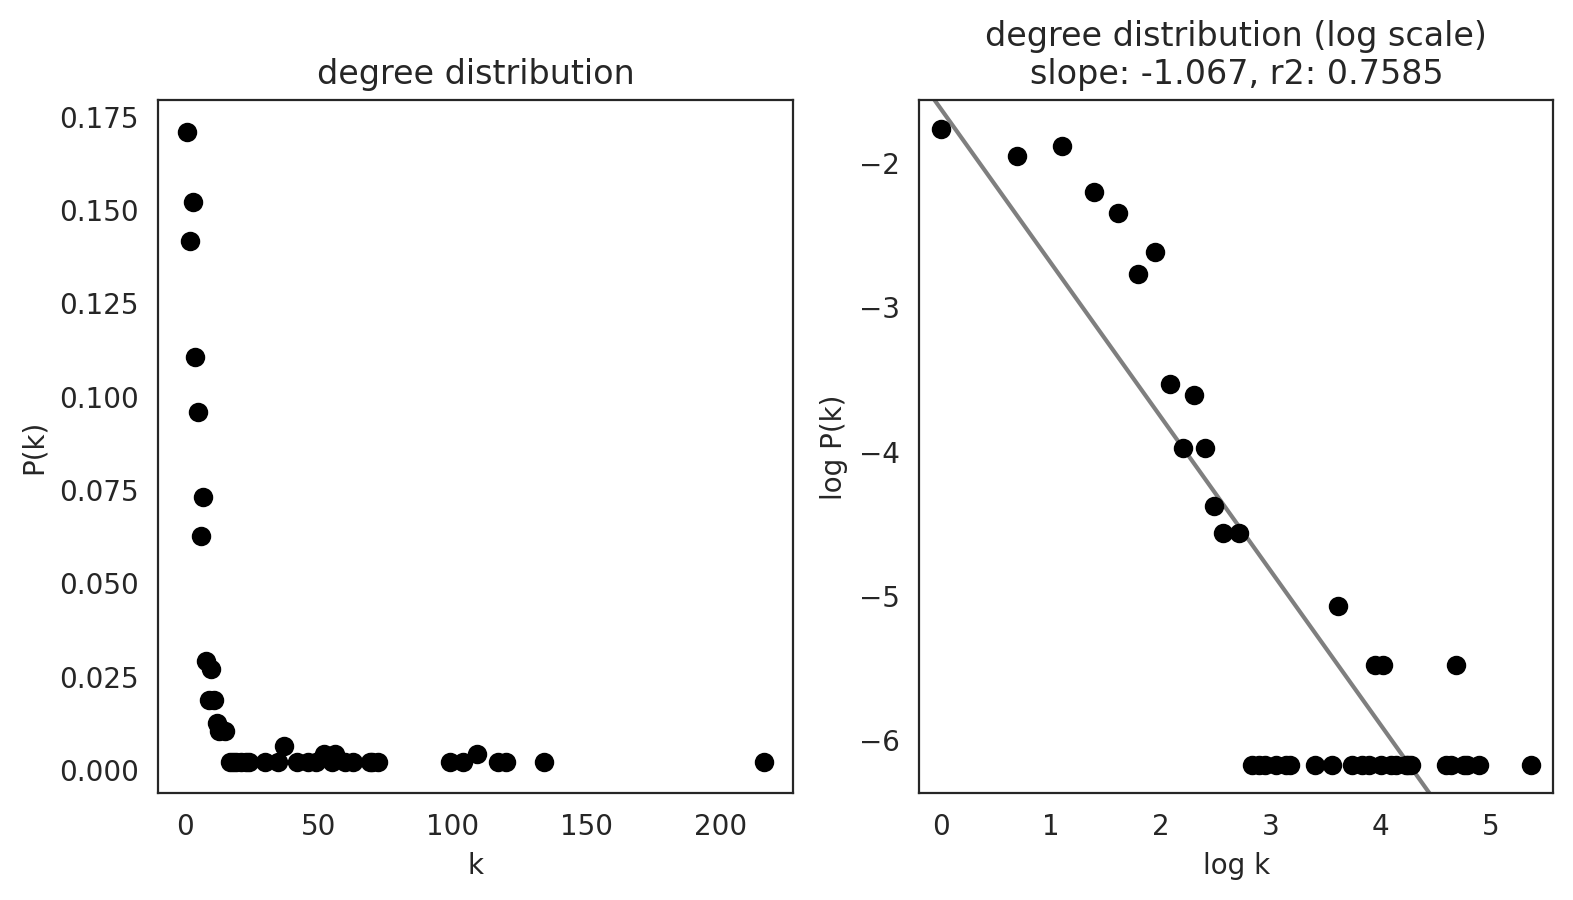

Epi_healthy_iav


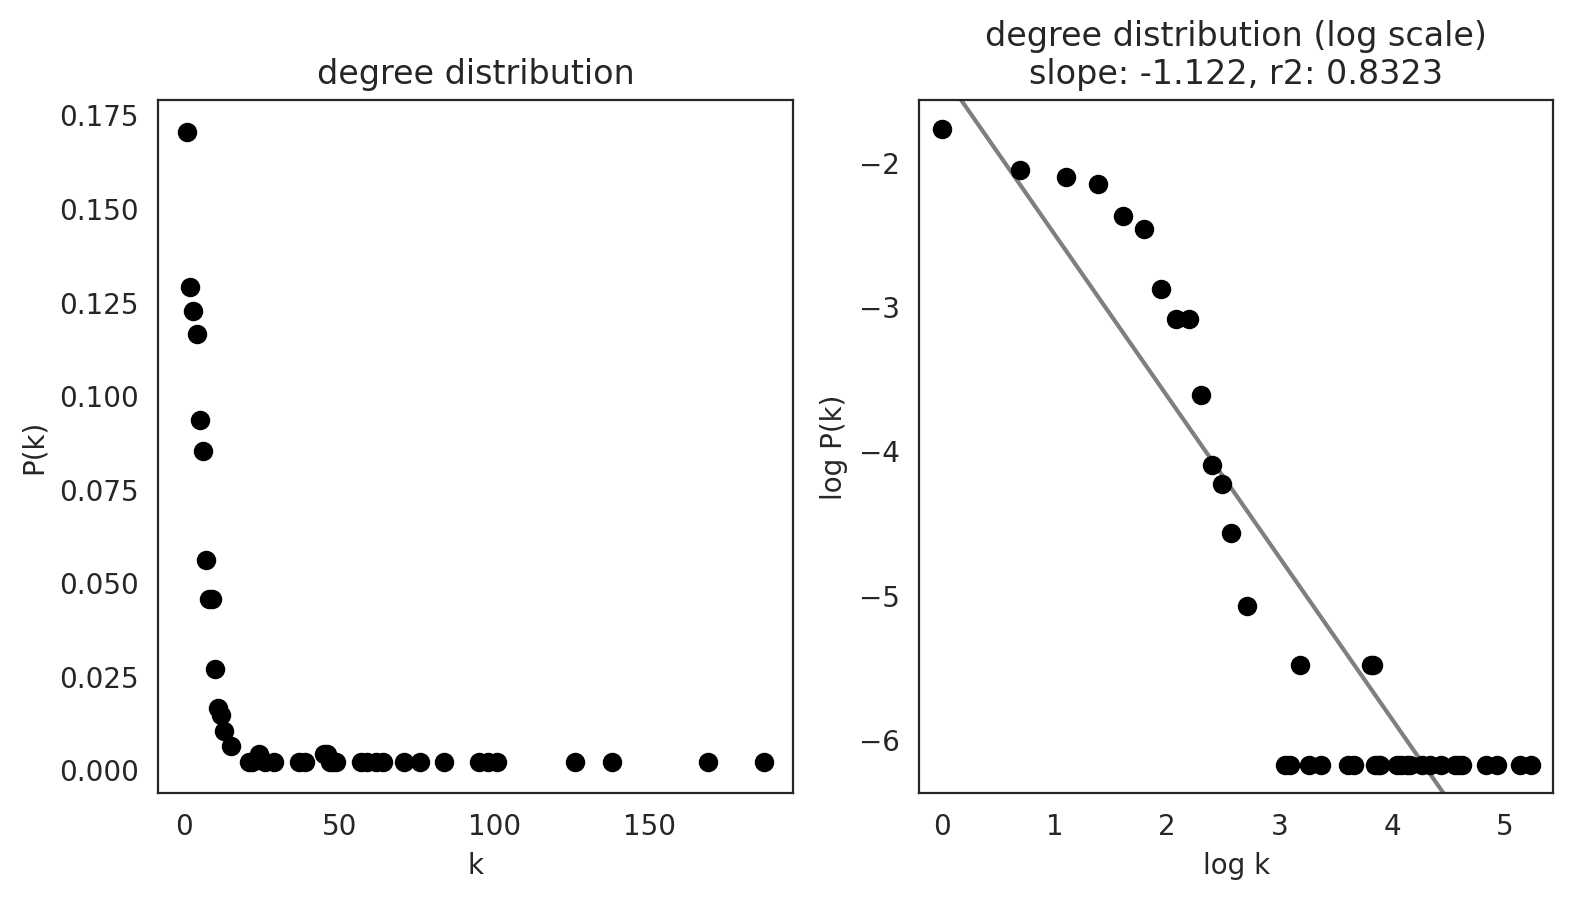

Goblet_copd_ctrl


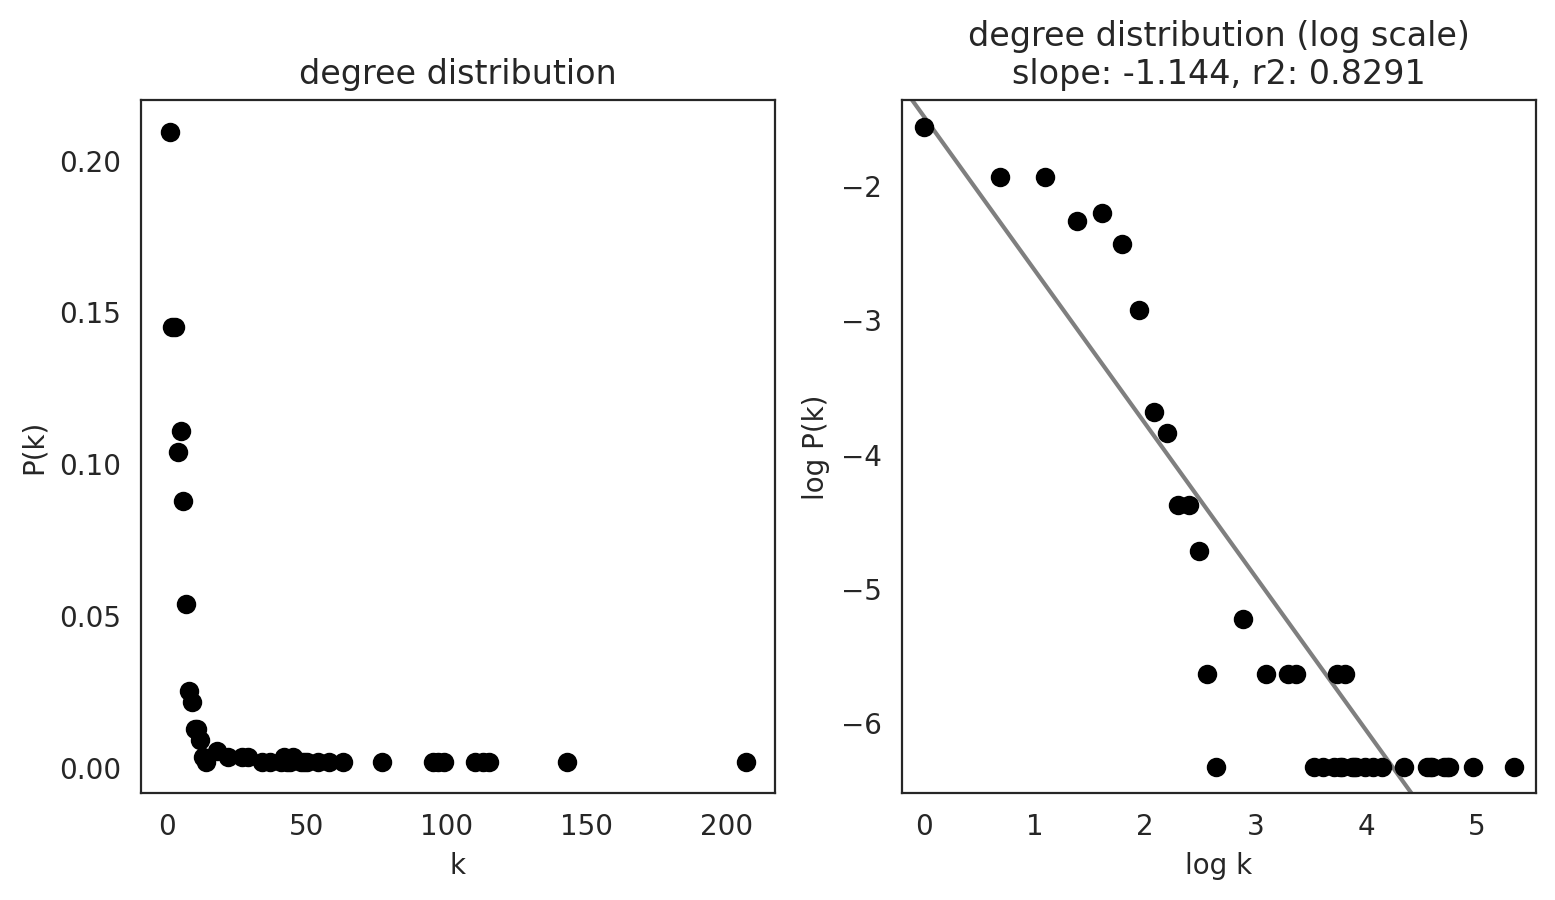

Goblet_copd_iav


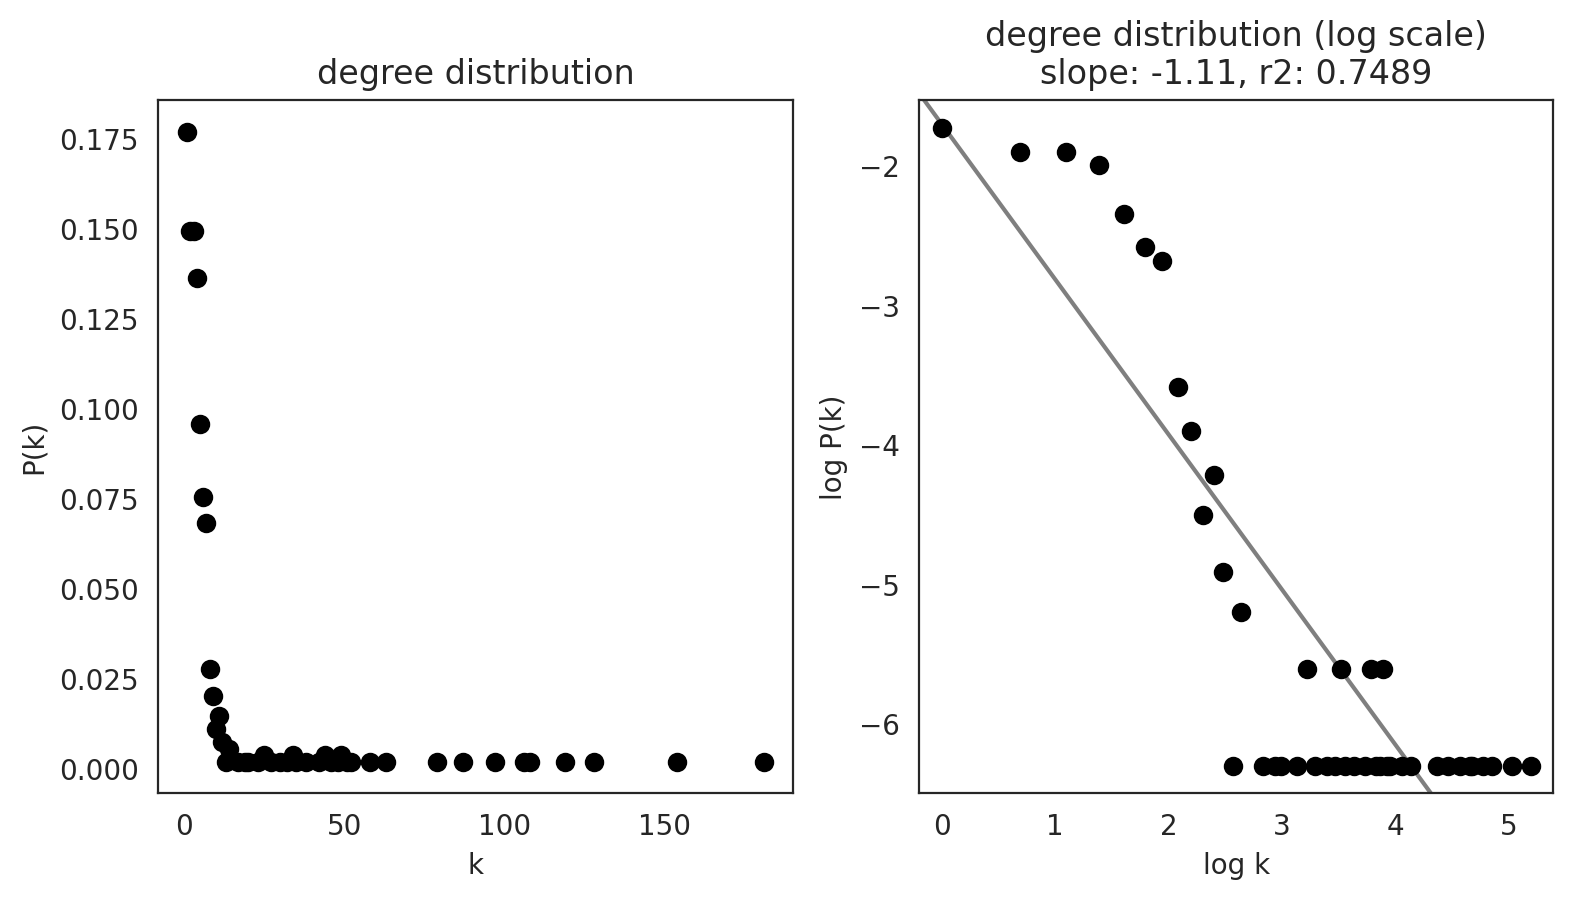

Goblet_healthy_ctrl


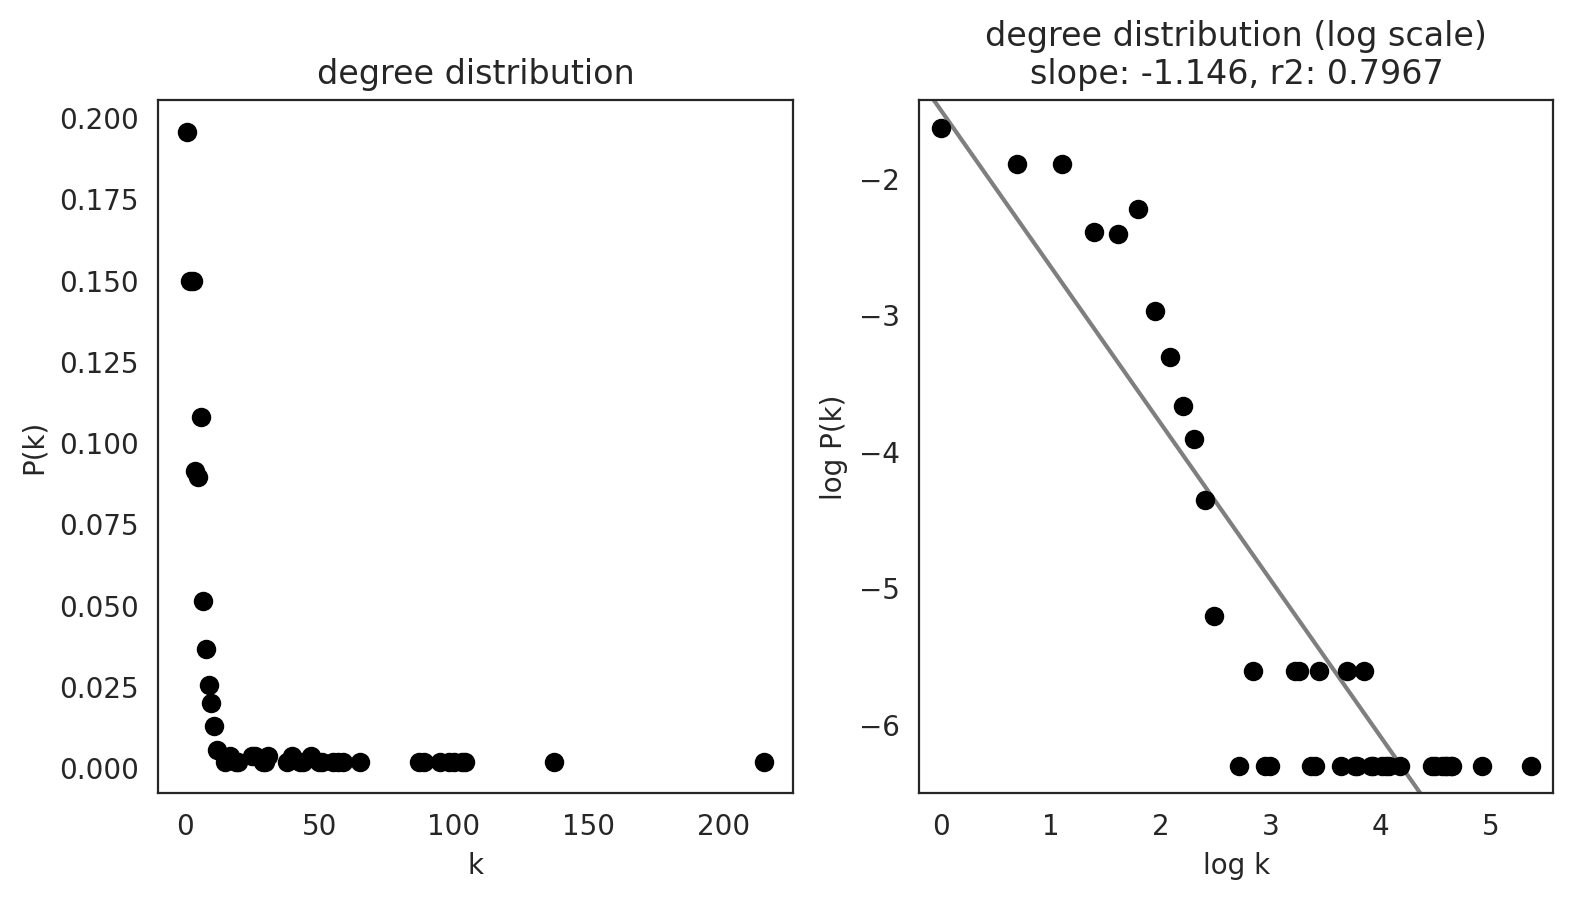

Goblet_healthy_iav


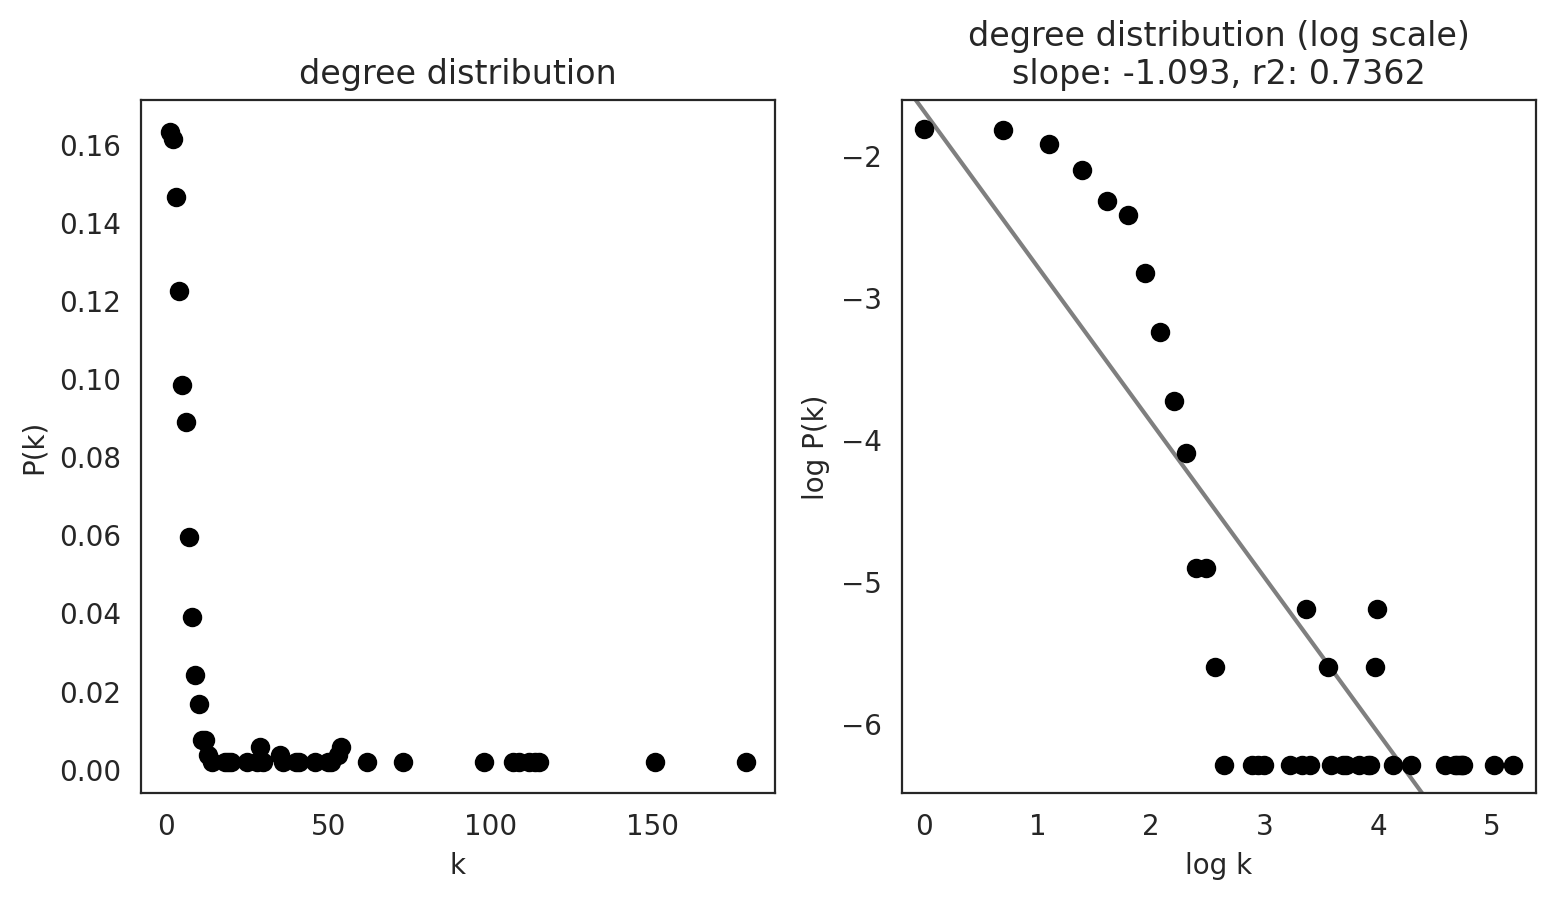

Ionocyte_copd_ctrl


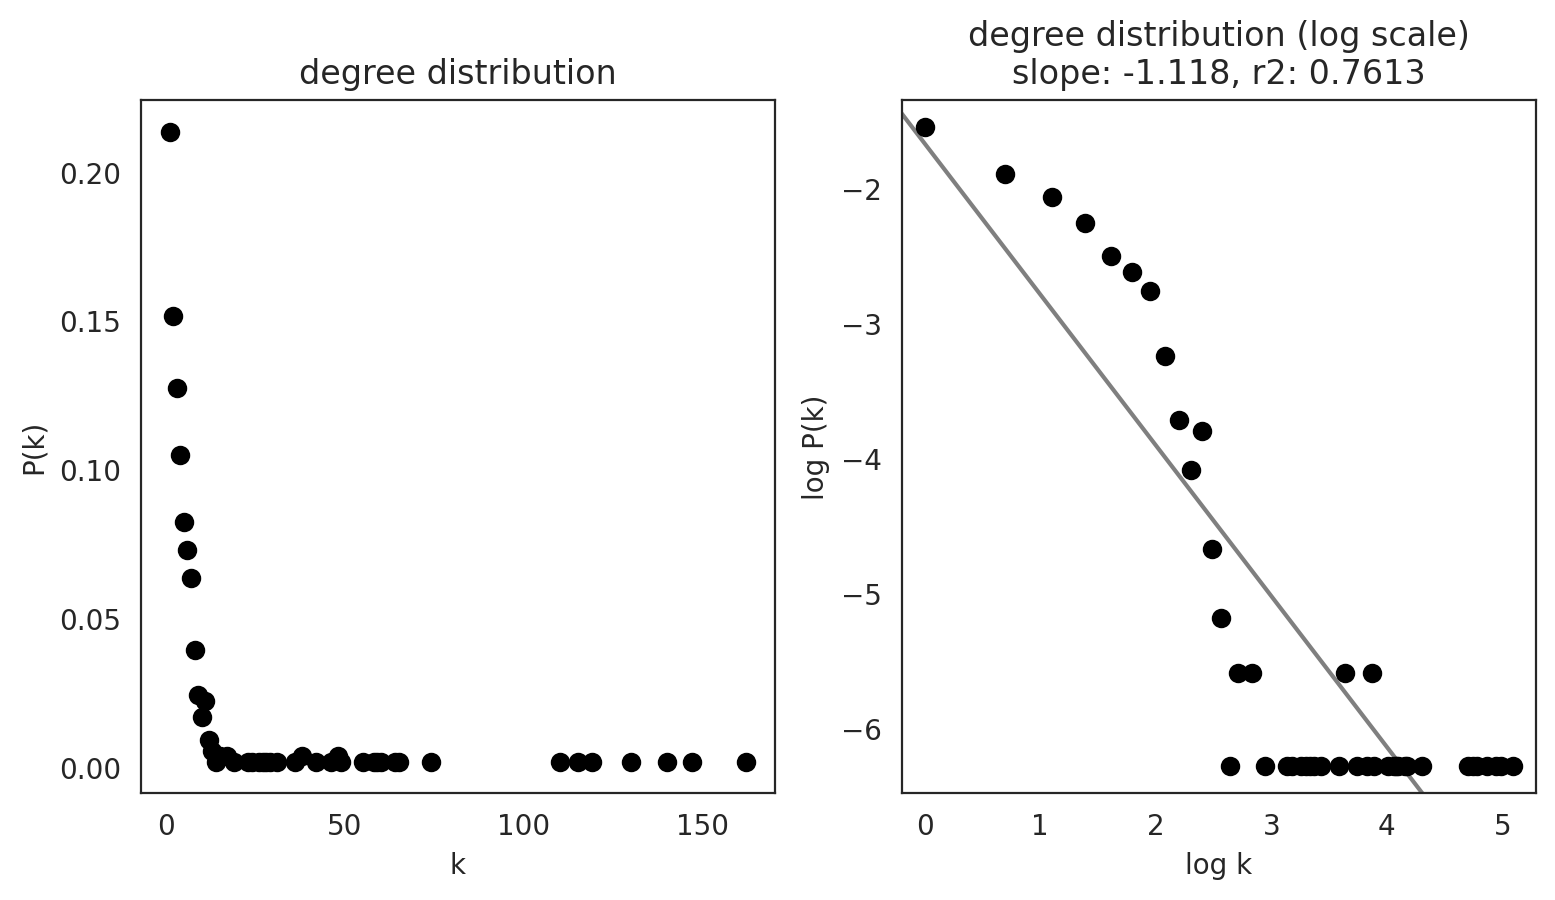

Ionocyte_copd_iav


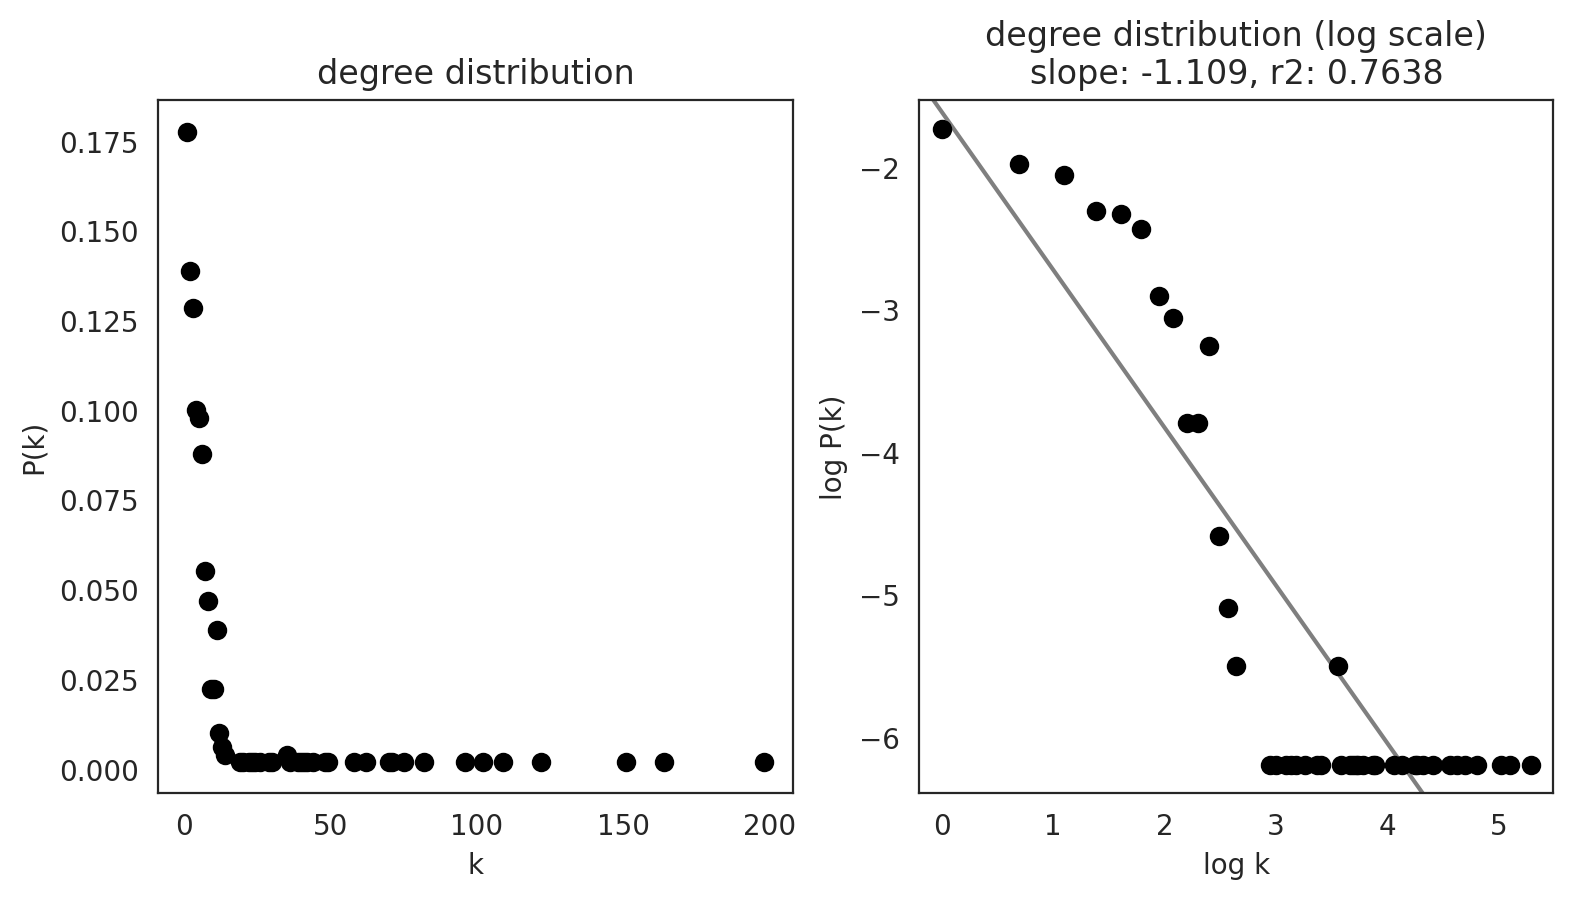

Ionocyte_healthy_ctrl


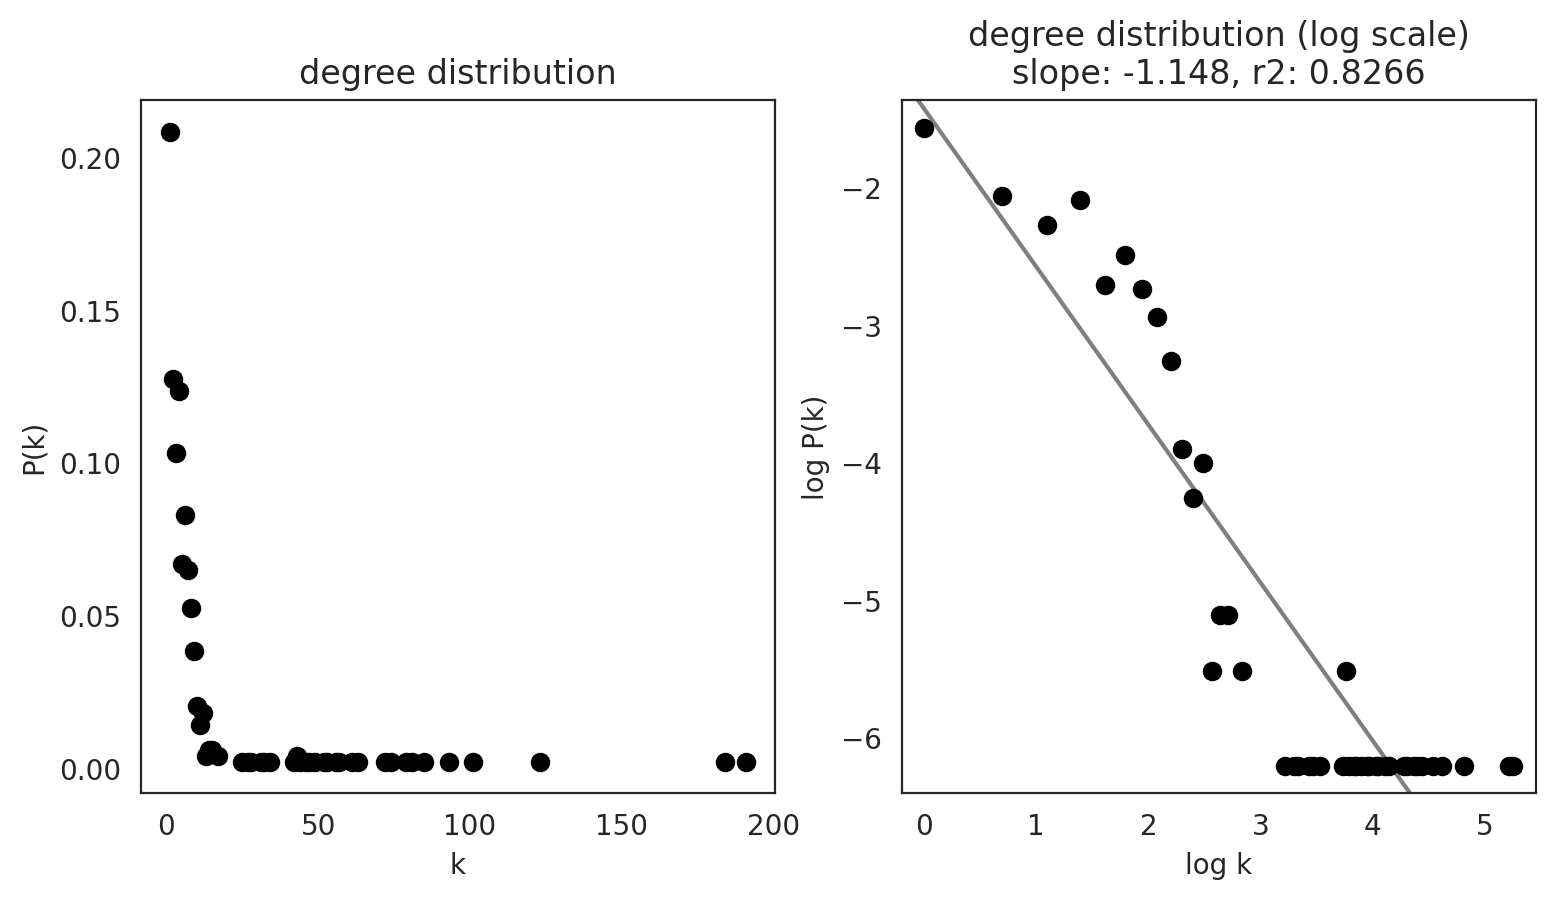

Ionocyte_healthy_iav


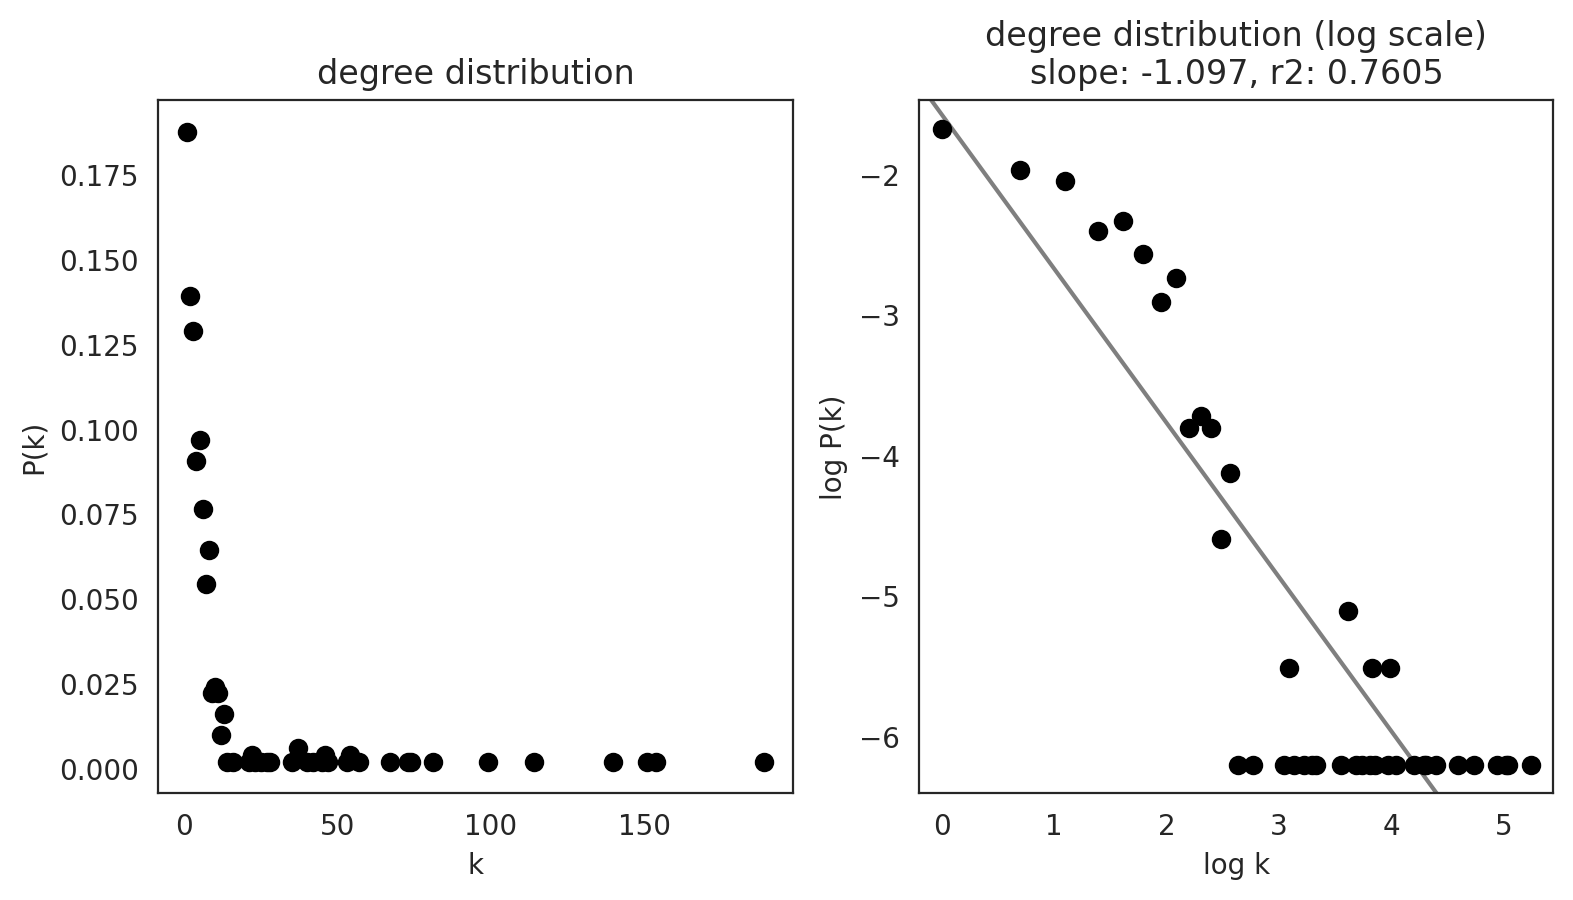

Secretory_copd_ctrl


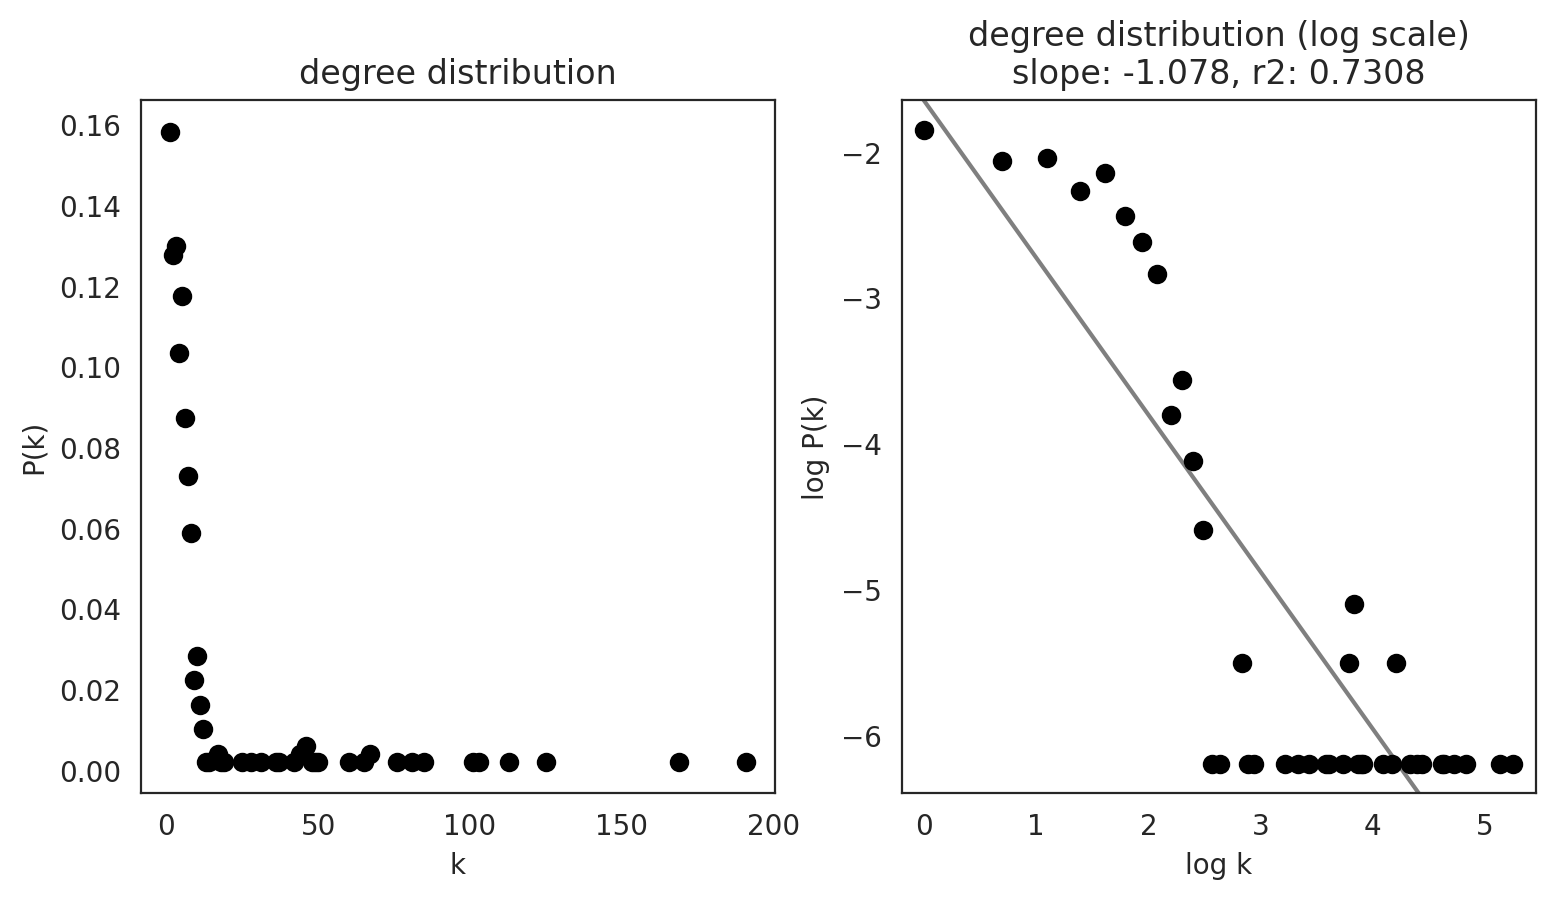

Secretory_copd_iav


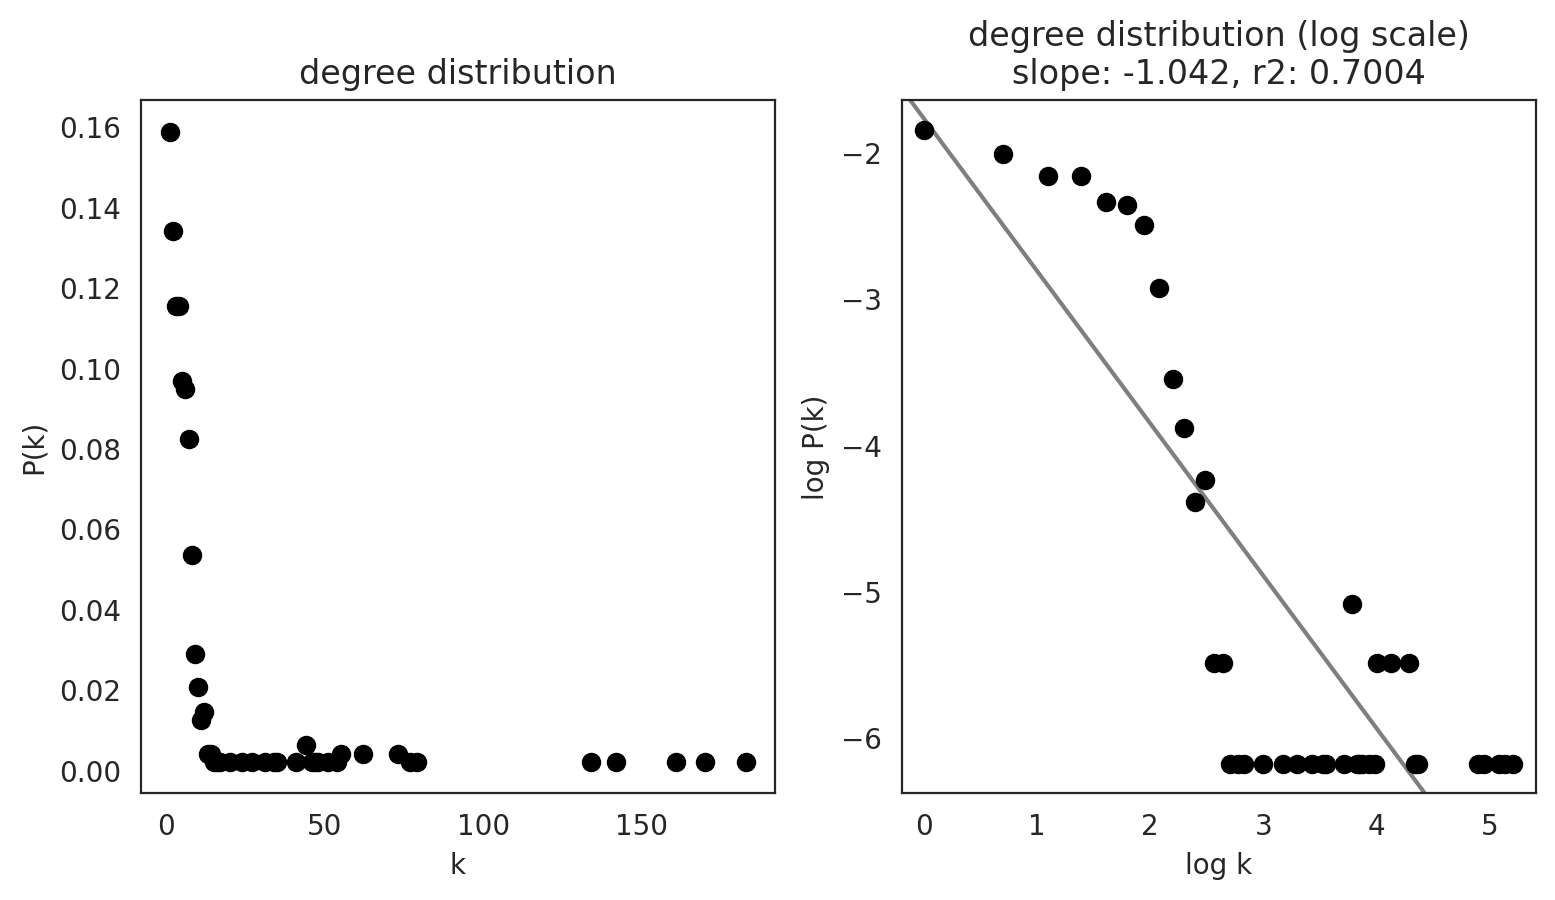

Secretory_healthy_ctrl


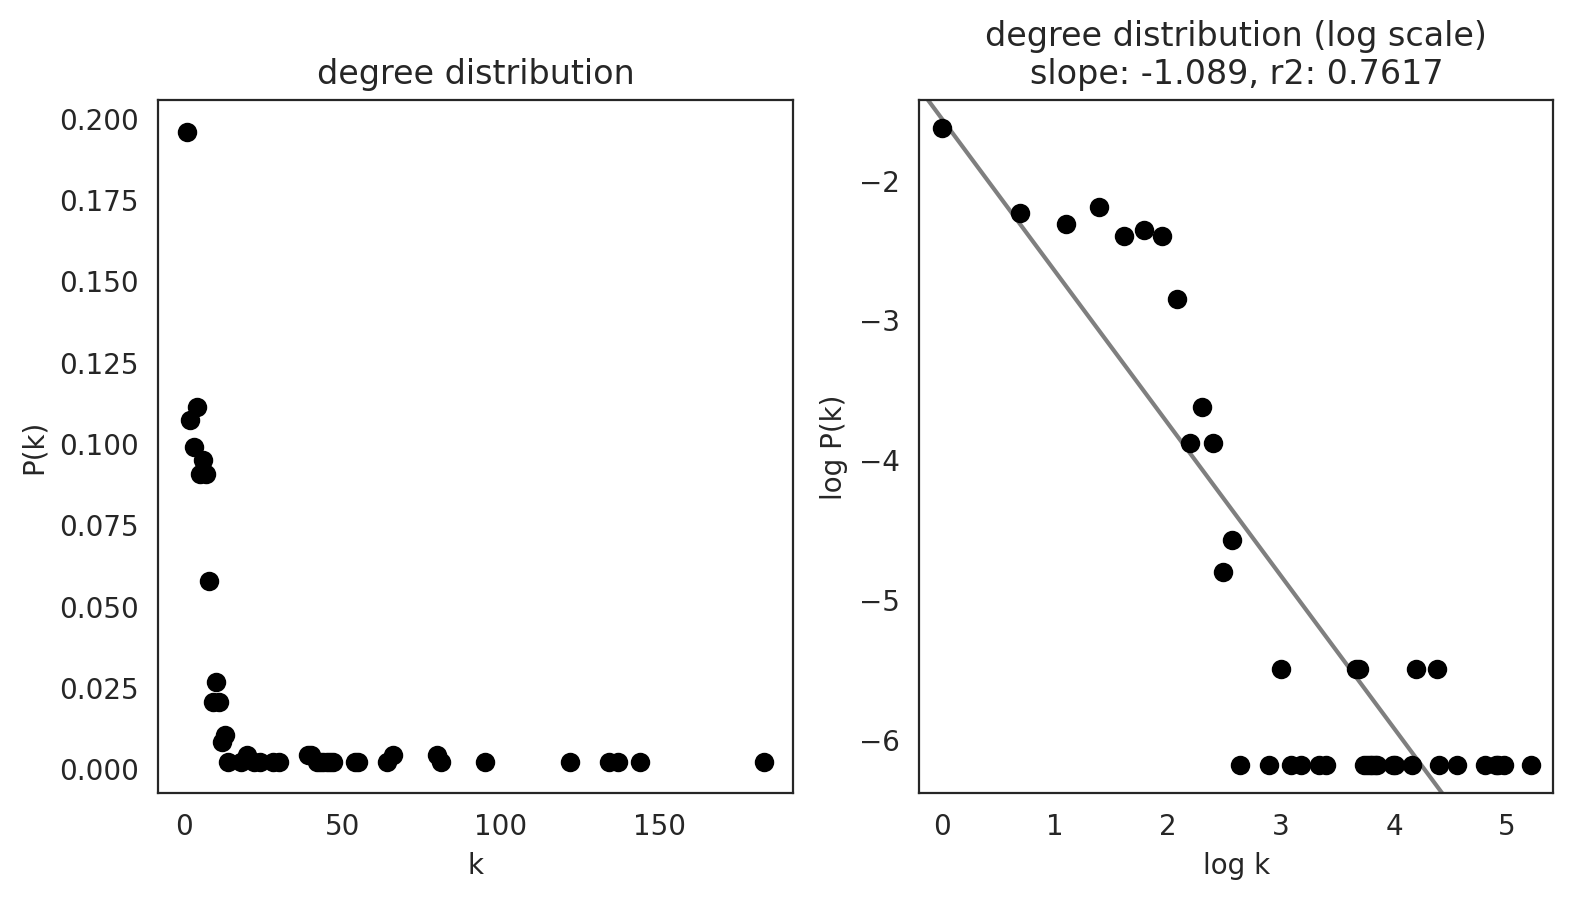

Secretory_healthy_iav


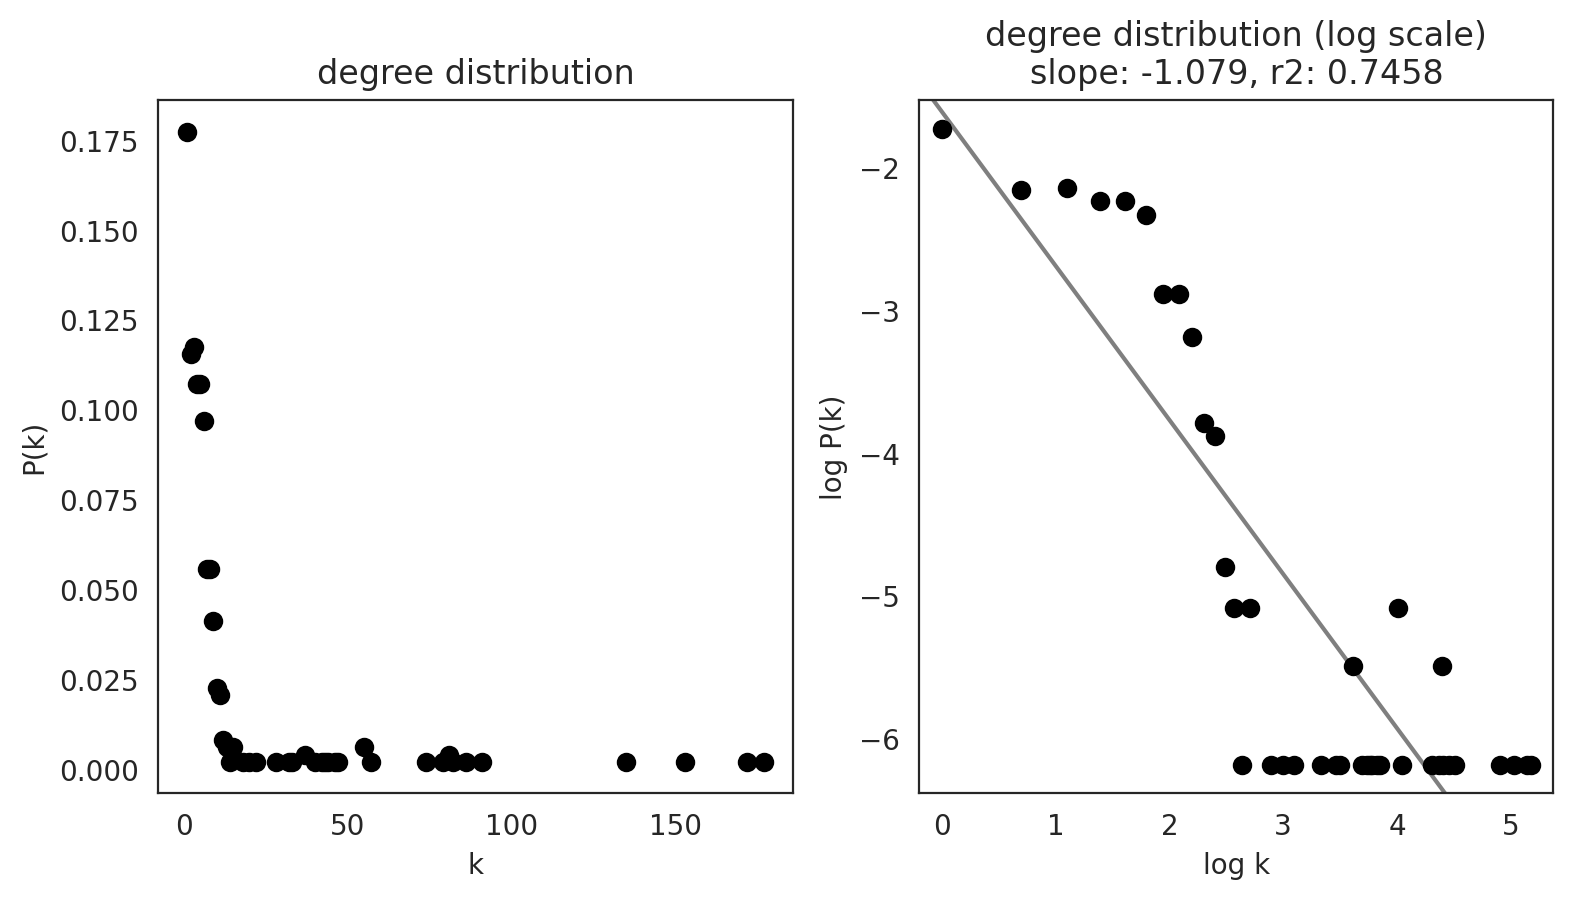

SupraB_copd_ctrl


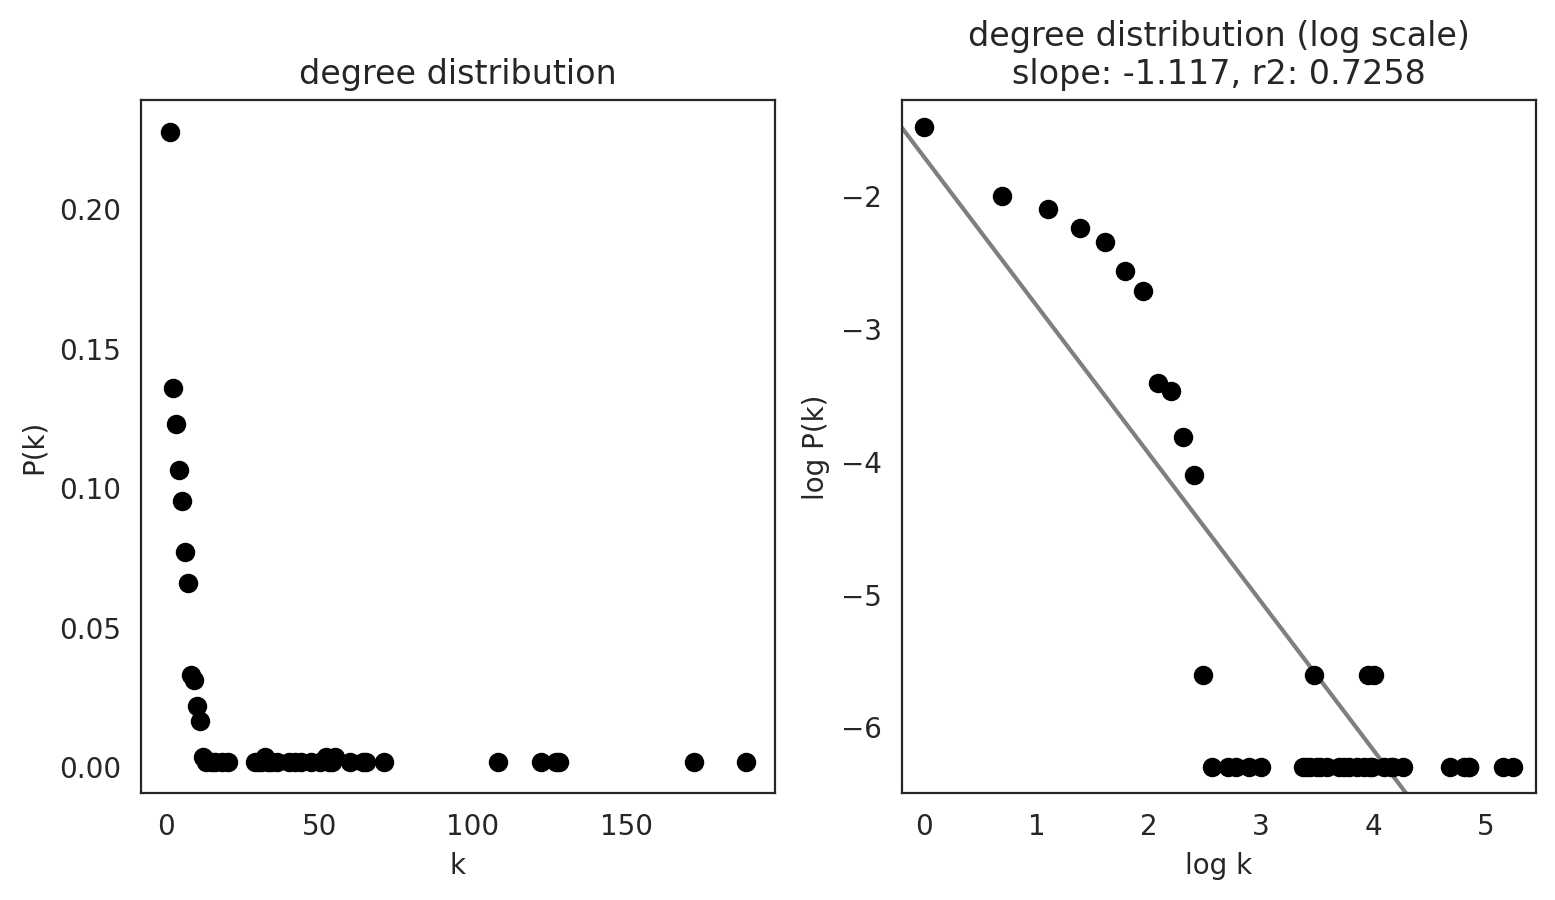

SupraB_copd_iav


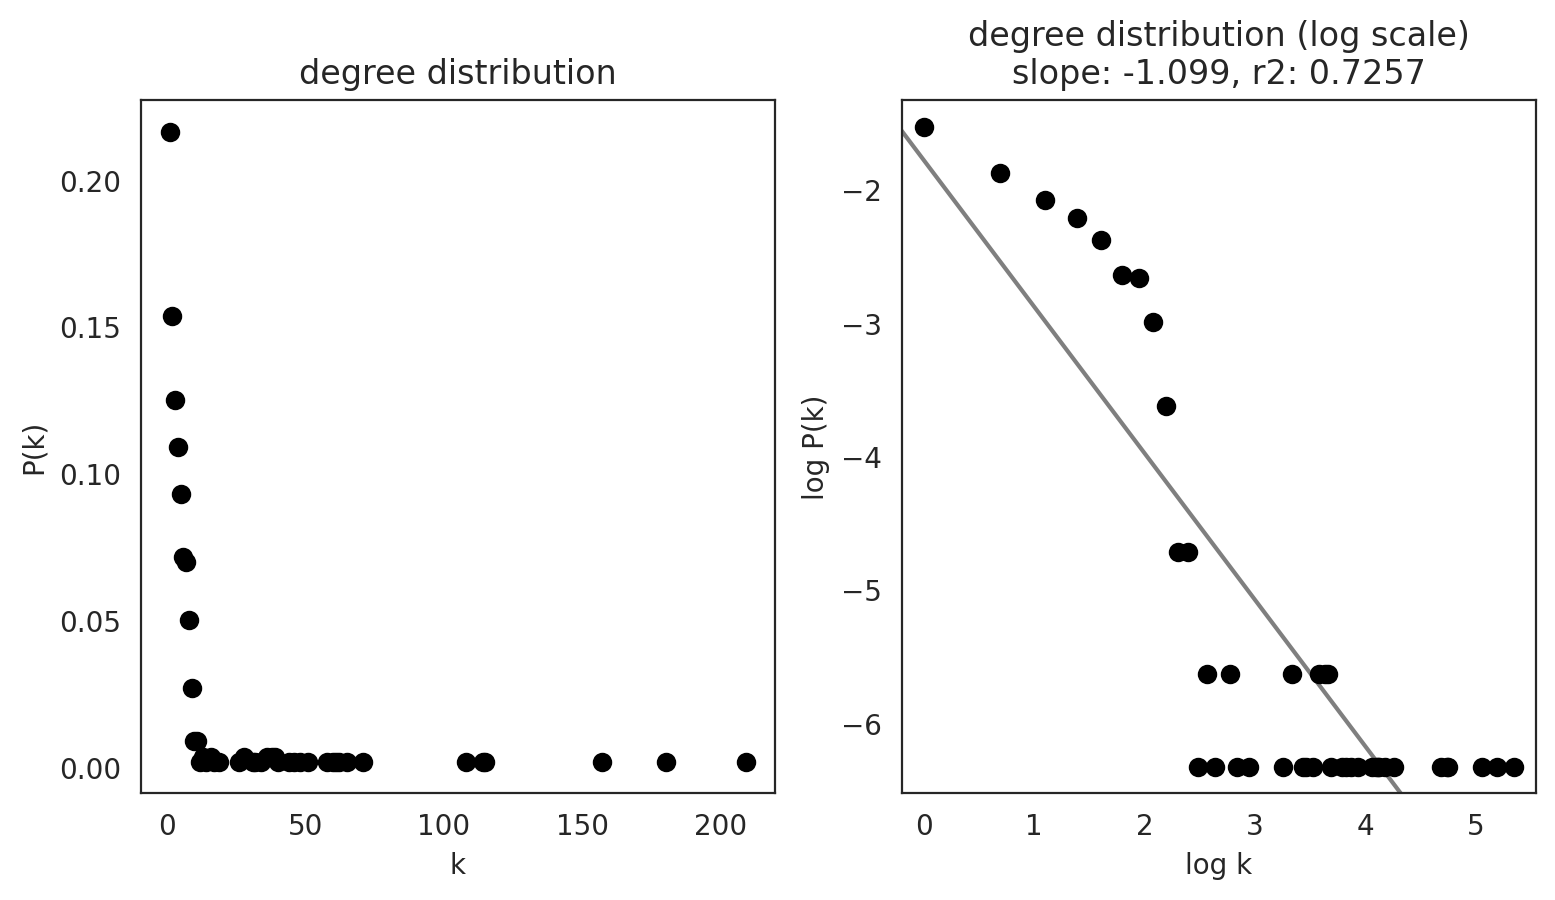

SupraB_healthy_ctrl


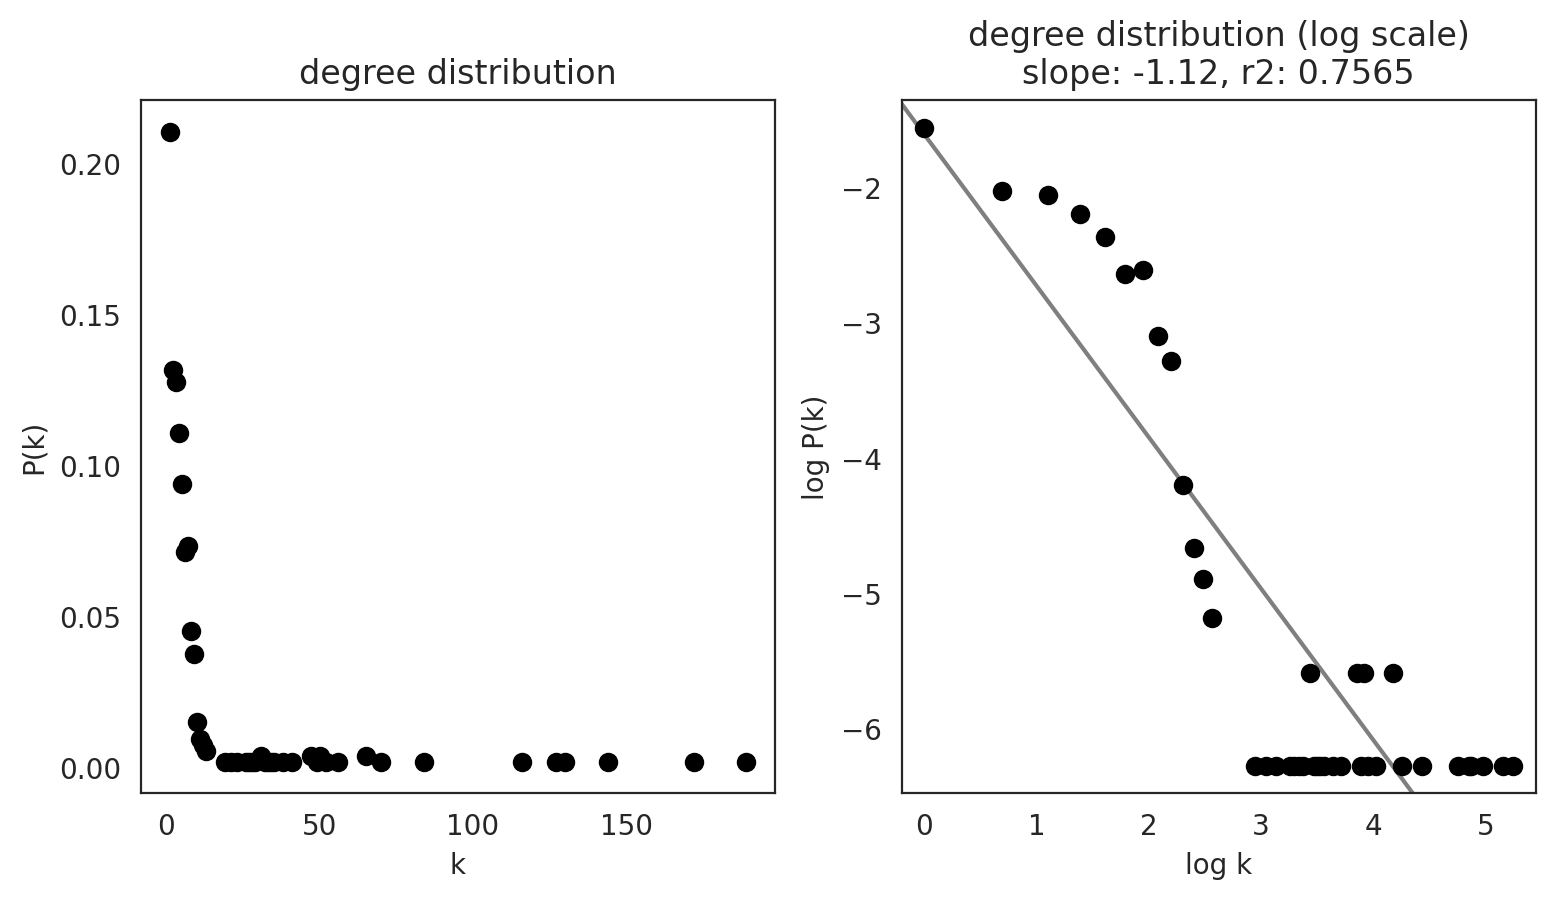

SupraB_healthy_iav


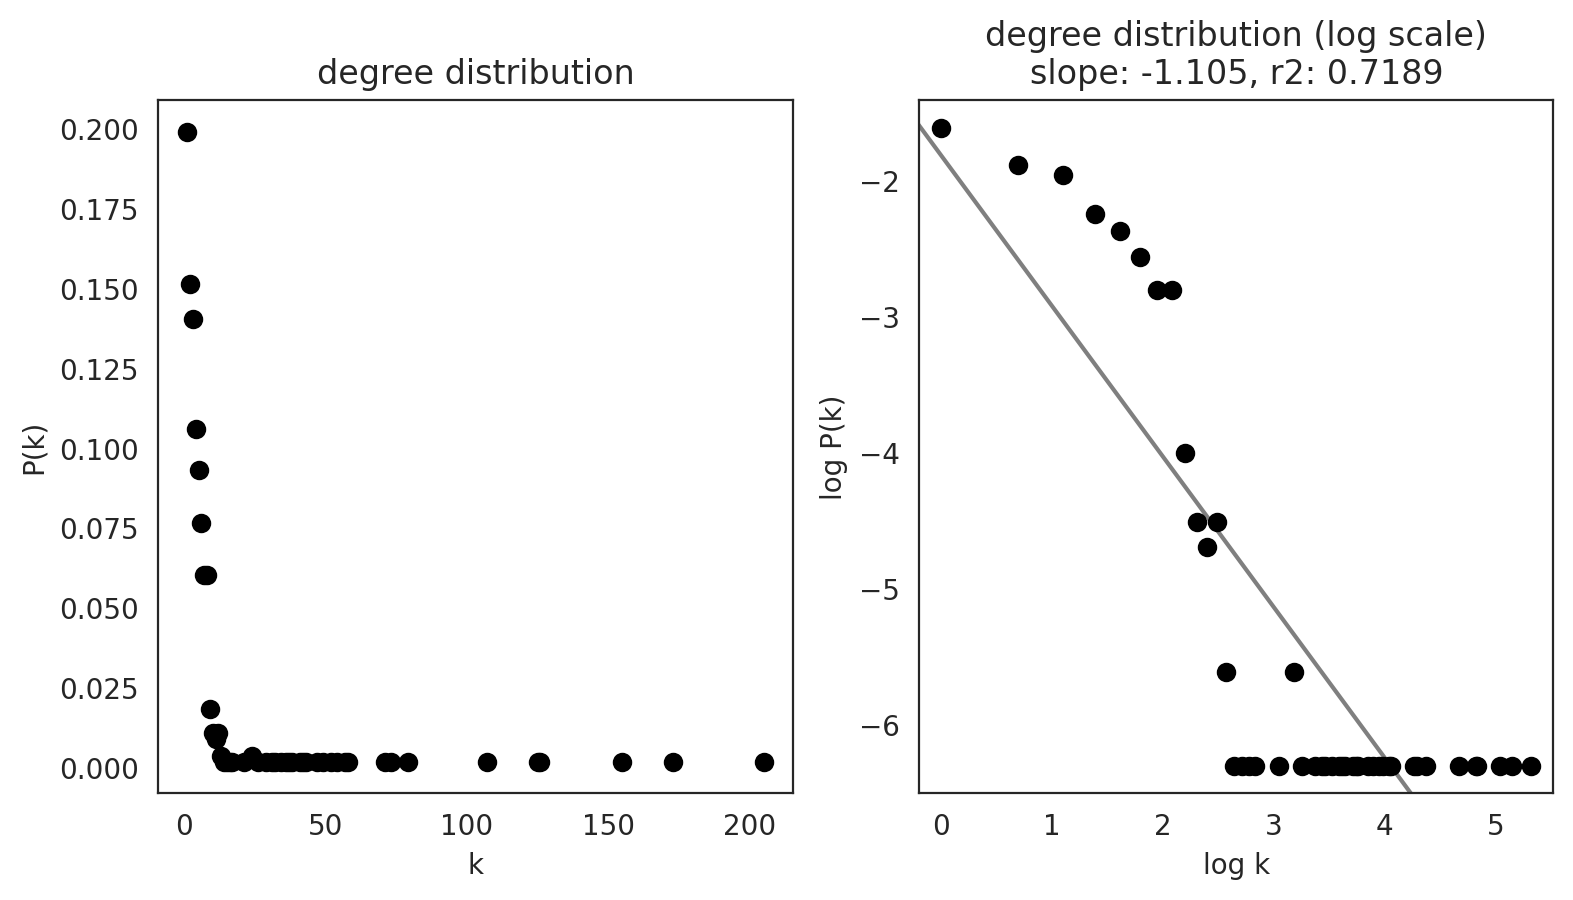

Unknown_copd_ctrl


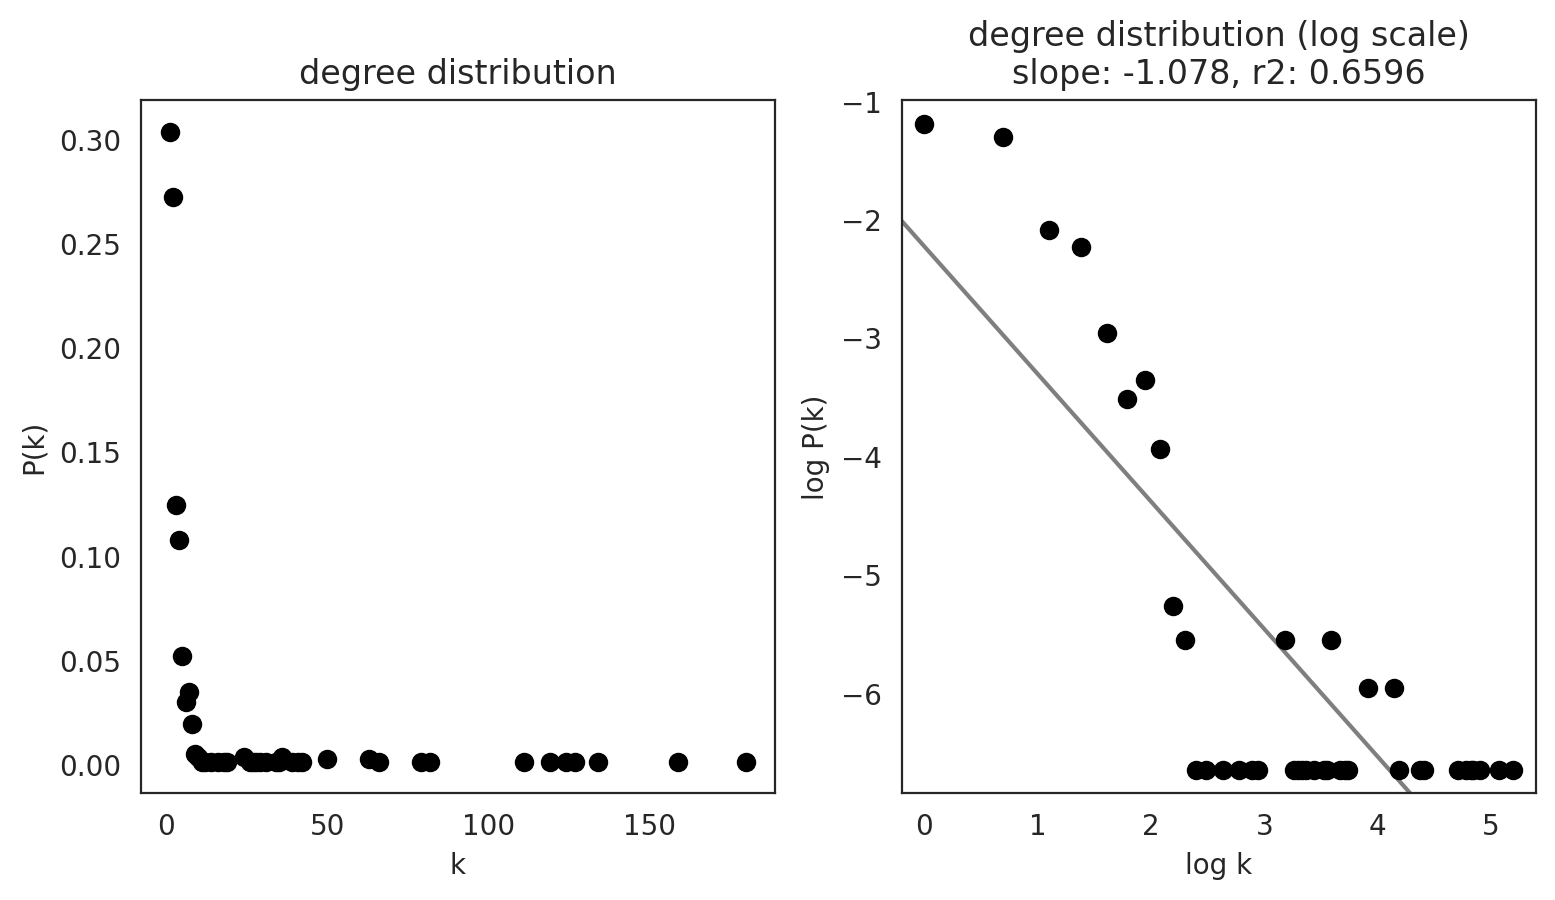

Unknown_copd_iav


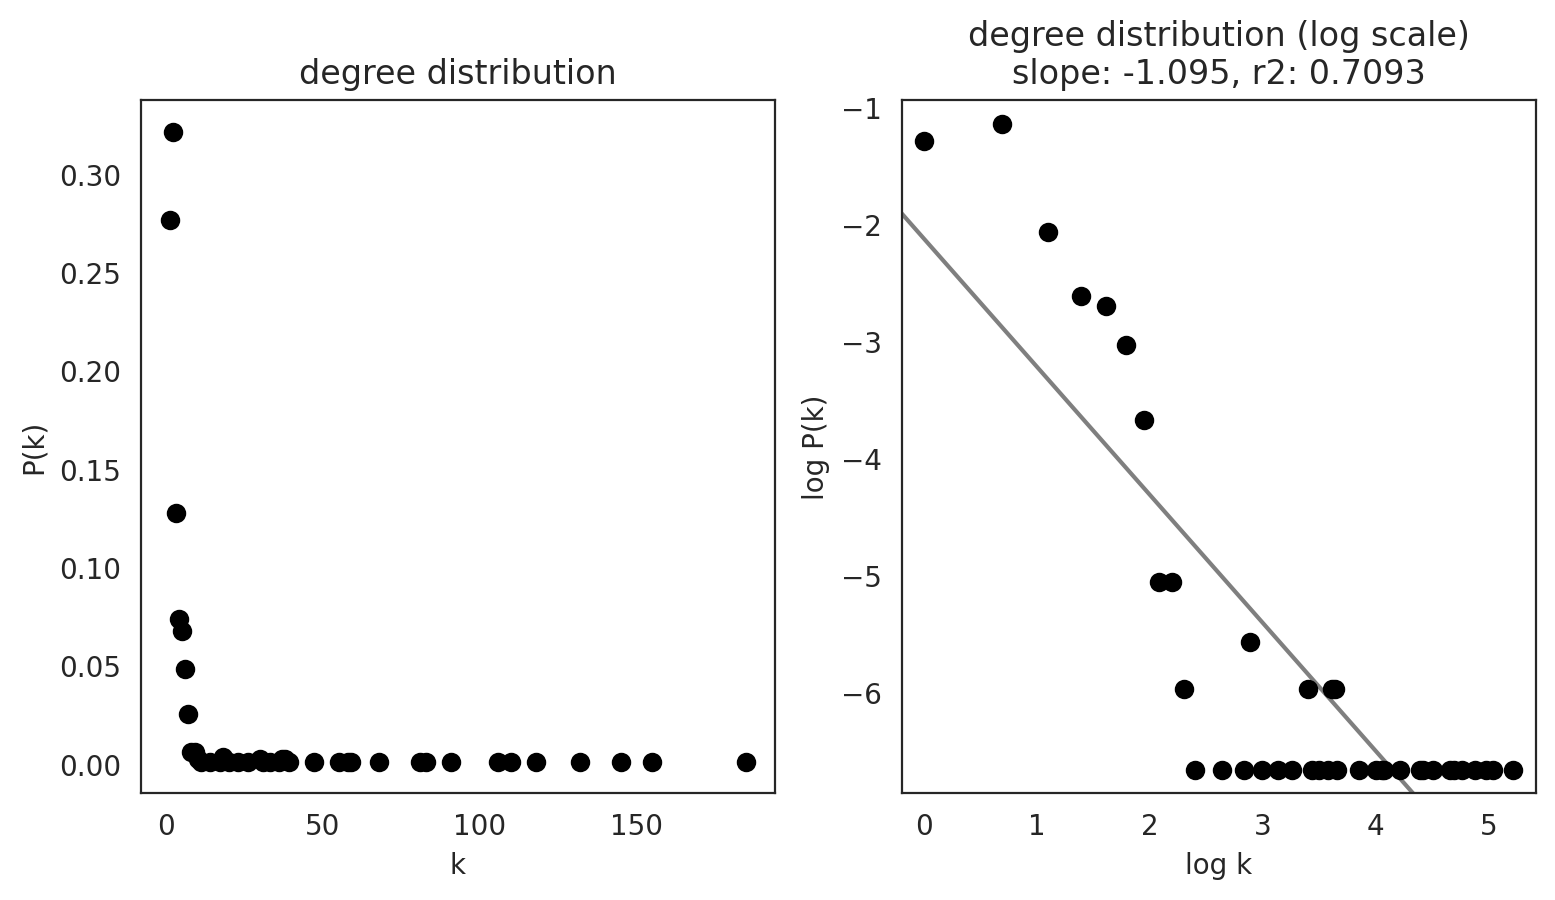

Unknown_healthy_ctrl


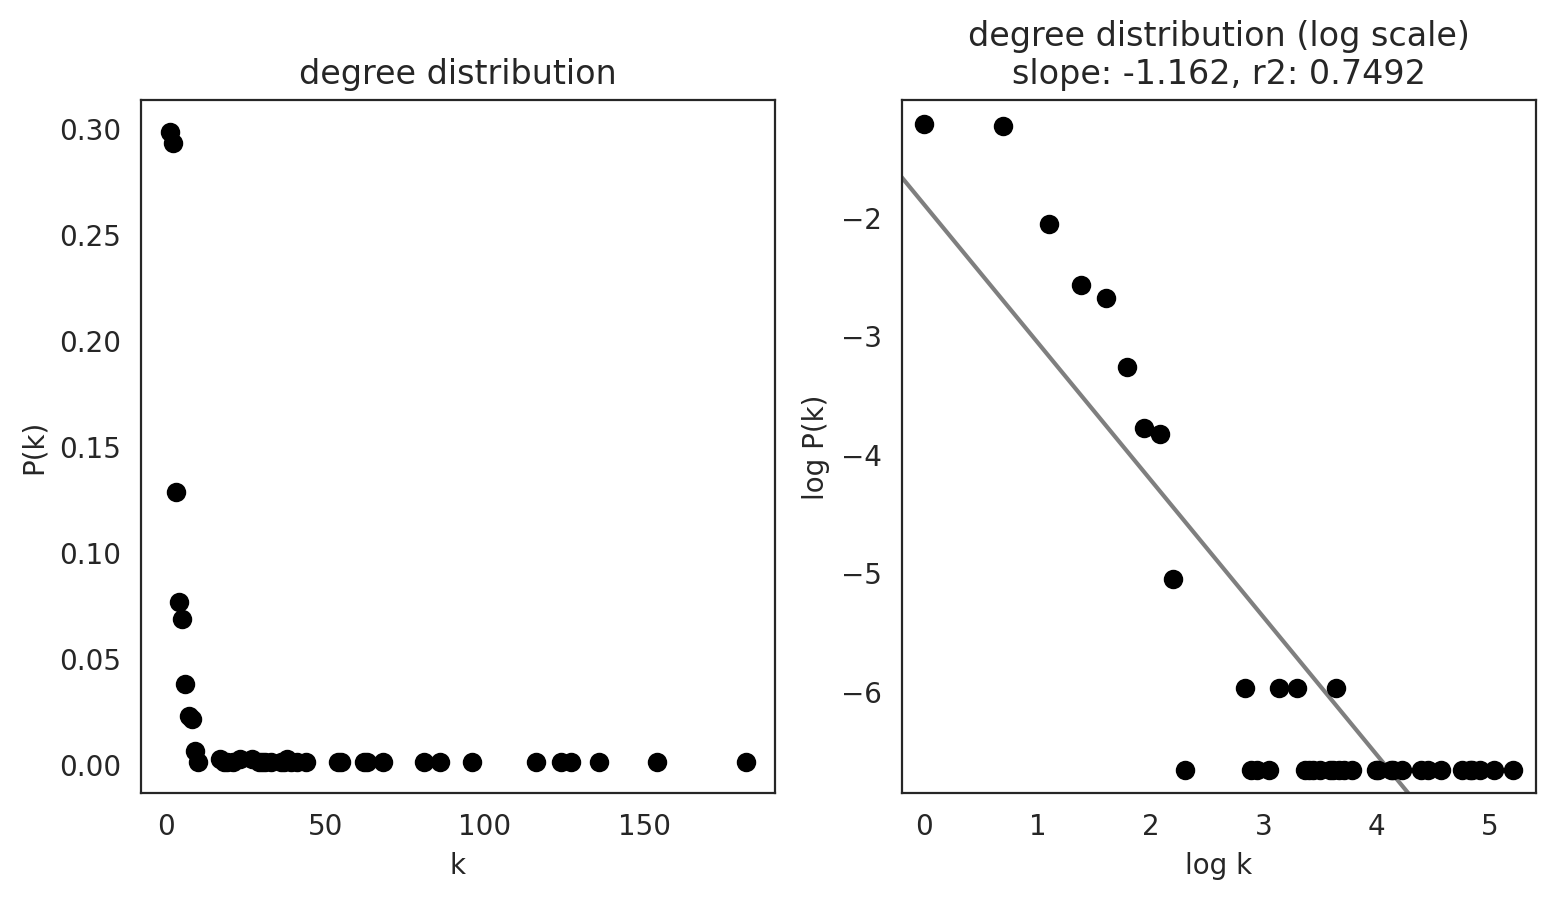

Unknown_healthy_iav


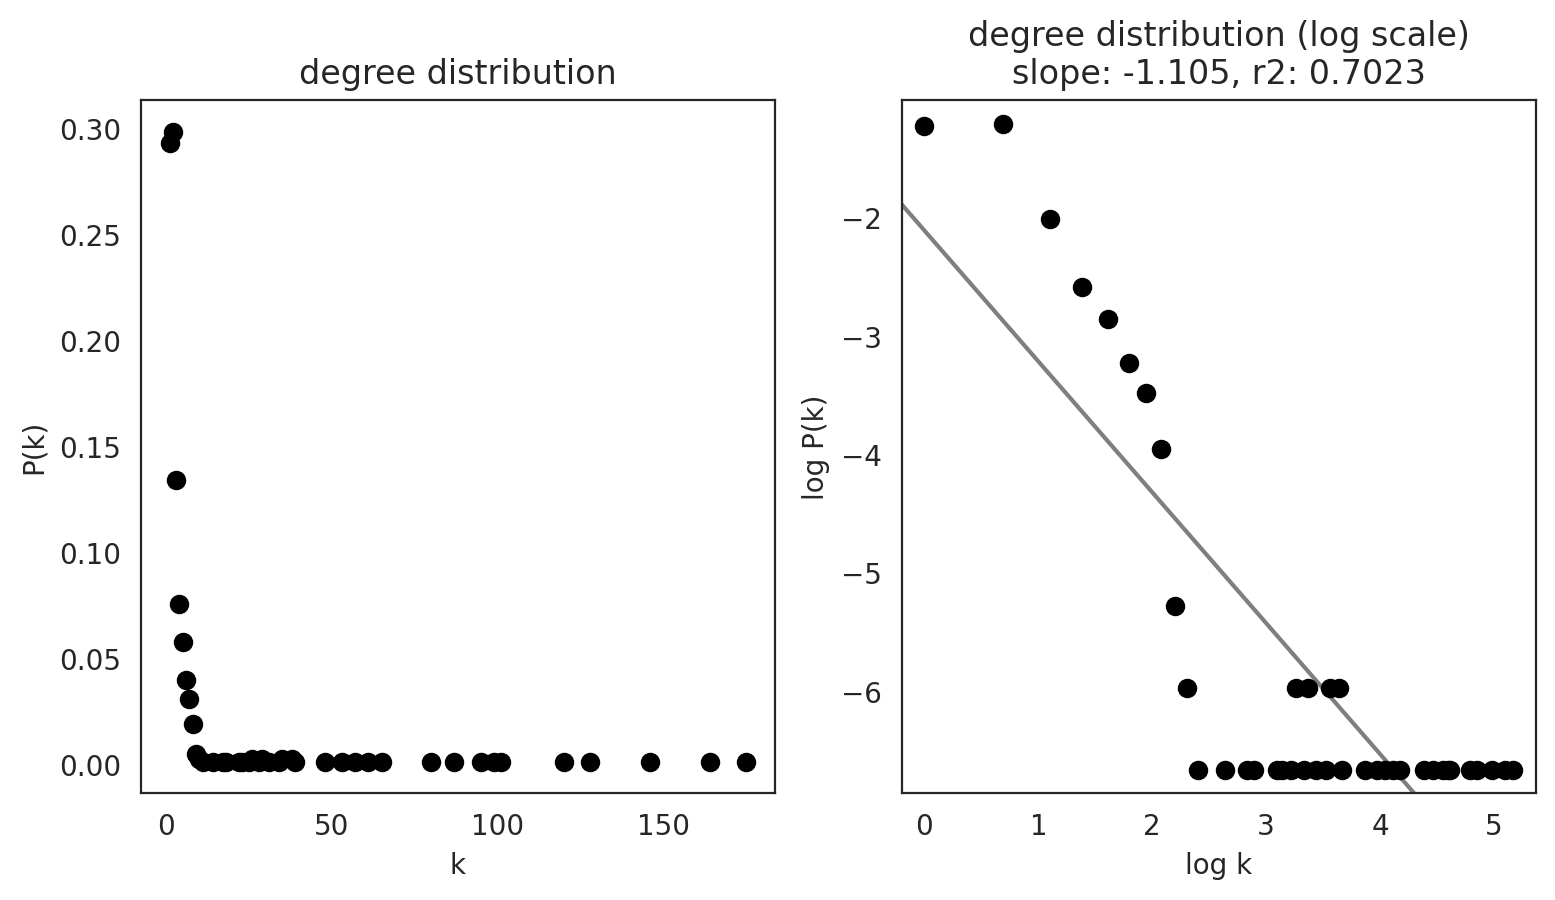

In [32]:
links.plot_degree_distributions(plot_model=True, 
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [33]:
plt.rcParams["figure.figsize"] = [6, 4.5]

In [34]:
# Calculate network scores. 
links.get_network_score()

In [35]:
links.merged_score.head()

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
RFX3              67               0.104688          0              0.000000   
ALDH1A1            4               0.006250          4              0.006250   
RFX2              73               0.114062          0              0.000000   
SERPINB1           2               0.003125          2              0.003125   
KLF2             170               0.265625          0              0.000000   

          degree_out  degree_centrality_out  betweenness_centrality  \
RFX3              67               0.104688                     0.0   
ALDH1A1            0               0.000000                     0.0   
RFX2              73               0.114062                     0.0   
SERPINB1           0               0.000000                     0.0   
KLF2             170               0.265625                     0.0   

          eigenvector_centrality          cluster  
RFX3                    0.249816  Basal_copd_ctrl  
ALDH1A1                 0.115948  Basal_copd_ctrl  
RFX2                    0.326961  Basal_copd_ctrl  
SERPINB1                0.080494  Basal_copd_ctrl  
KLF2                    1.000000  Basal_copd_ctrl

In [36]:
# Save Links object.
links.to_hdf5(file_path="links.celloracle.links")

In [37]:
# You can load files with the following command.
links = co.load_hdf5(file_path="links.celloracle.links")

In [38]:
links.cluster

['Basal_copd_ctrl',
 'Basal_copd_iav',
 'Basal_healthy_ctrl',
 'Basal_healthy_iav',
 'Ciliated_copd_ctrl',
 'Ciliated_copd_iav',
 'Ciliated_healthy_ctrl',
 'Ciliated_healthy_iav',
 'Club_copd_ctrl',
 'Club_copd_iav',
 'Club_healthy_ctrl',
 'Club_healthy_iav',
 'Deuterosomal_copd_ctrl',
 'Deuterosomal_copd_iav',
 'Deuterosomal_healthy_ctrl',
 'Deuterosomal_healthy_iav',
 'Epi_copd_ctrl',
 'Epi_copd_iav',
 'Epi_healthy_ctrl',
 'Epi_healthy_iav',
 'Goblet_copd_ctrl',
 'Goblet_copd_iav',
 'Goblet_healthy_ctrl',
 'Goblet_healthy_iav',
 'Ionocyte_copd_ctrl',
 'Ionocyte_copd_iav',
 'Ionocyte_healthy_ctrl',
 'Ionocyte_healthy_iav',
 'Secretory_copd_ctrl',
 'Secretory_copd_iav',
 'Secretory_healthy_ctrl',
 'Secretory_healthy_iav',
 'SupraB_copd_ctrl',
 'SupraB_copd_iav',
 'SupraB_healthy_ctrl',
 'SupraB_healthy_iav',
 'Unknown_copd_ctrl',
 'Unknown_copd_iav',
 'Unknown_healthy_ctrl',
 'Unknown_healthy_iav']

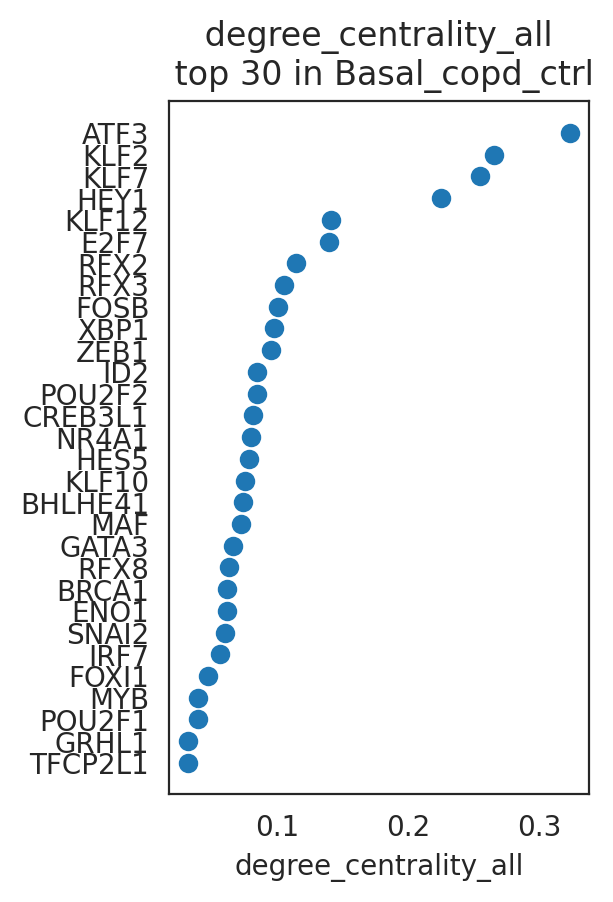

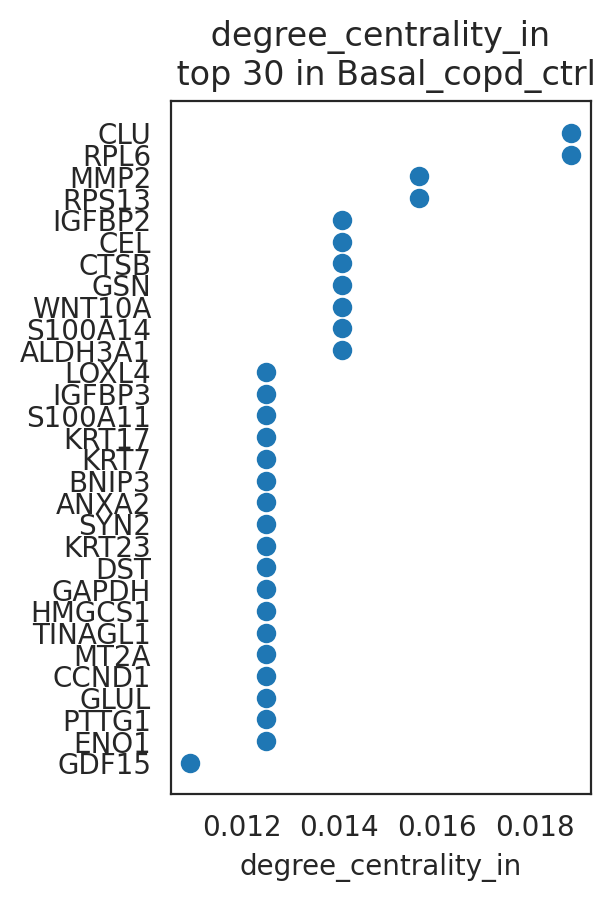

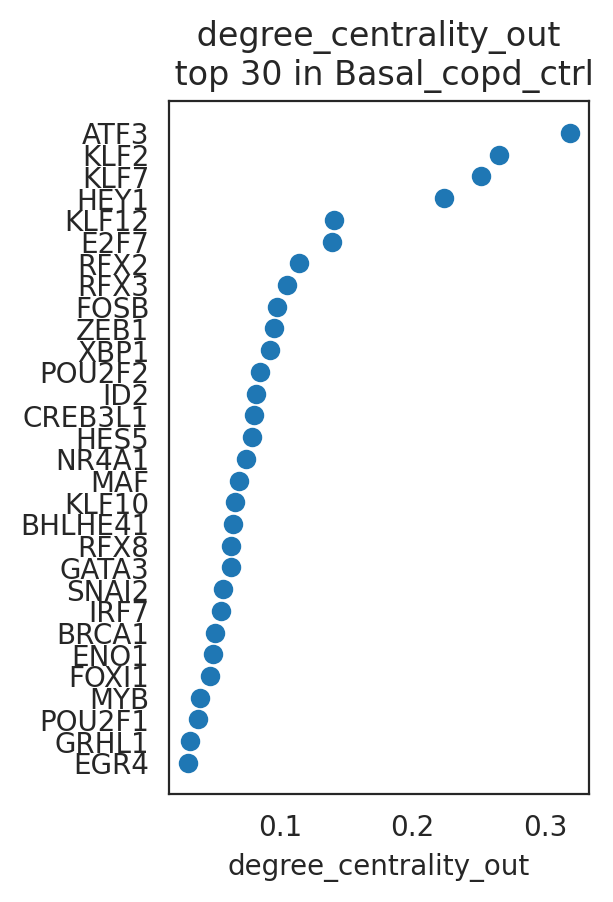

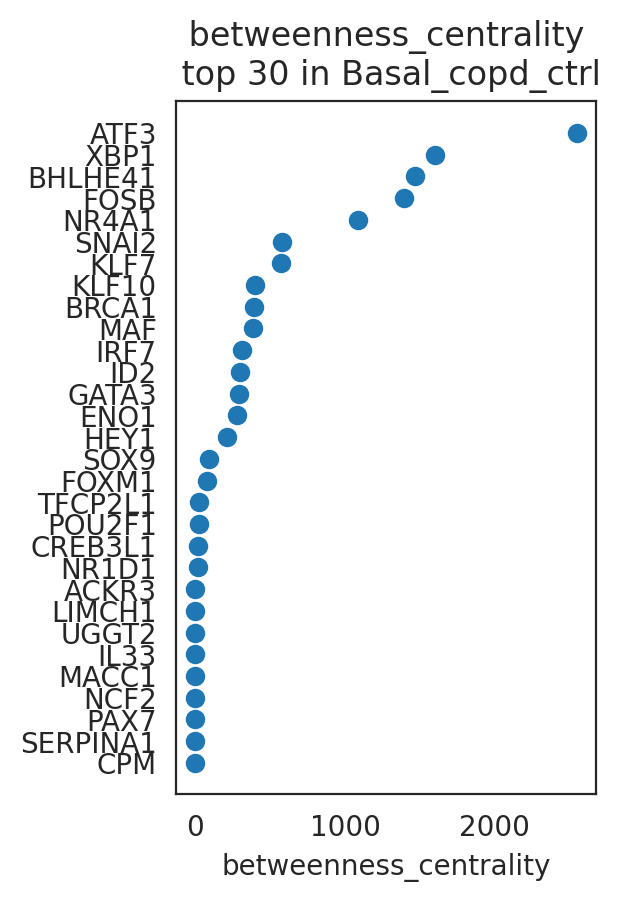

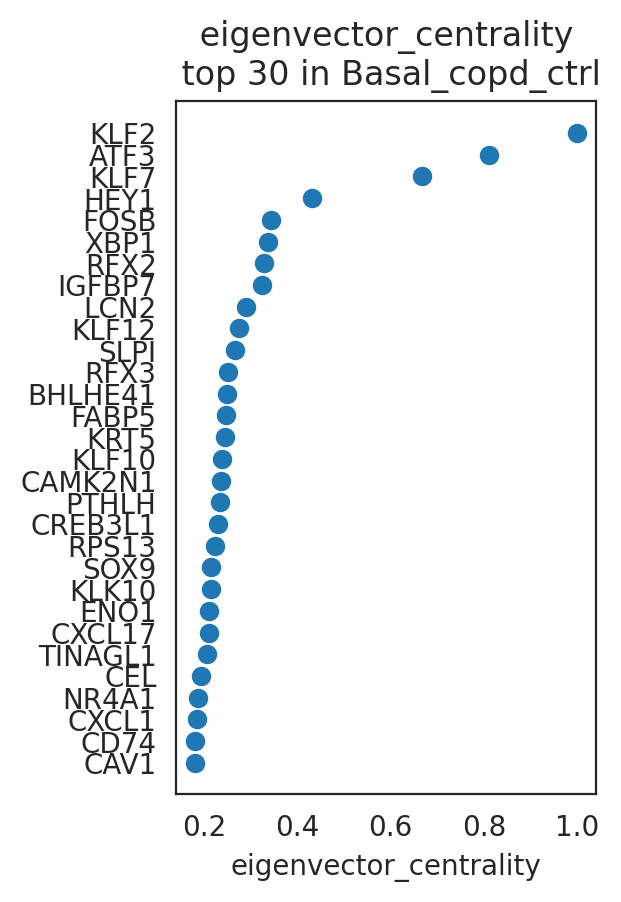

In [41]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="Basal_copd_ctrl", n_gene=30, 
                          #save=f"{save_folder}/ranked_score"
                          )

In [40]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="Basal_0", cluster2="Basal_1", 
                               percentile=98,
                               save=f"{save_folder}/score_comparison")

KeyError: 'Basal_0'

cluster    Club_copd_ctrl  Club_copd_iav  Club_healthy_ctrl  Club_healthy_iav
ABCA1            0.011009       0.002967           0.003026          0.003063
ACBD3-AS1             NaN       0.001484           0.001513          0.001531
ACKR3            0.005505       0.002967           0.003026          0.003063
ACTB             0.014679       0.010386           0.013616          0.010720
ACTG1            0.018349       0.013353           0.012103          0.013783
...                   ...            ...                ...               ...
ZEB1             0.341284       0.228487           0.204236          0.220521
ZG16B            0.003670       0.004451           0.001513          0.006126
ZMYND10          0.005505       0.004451           0.004539          0.004594
ZNF487                NaN       0.001484           0.003026               NaN
ZNF683           0.012844       0.004451                NaN          0.006126

[783 rows x 4 columns]

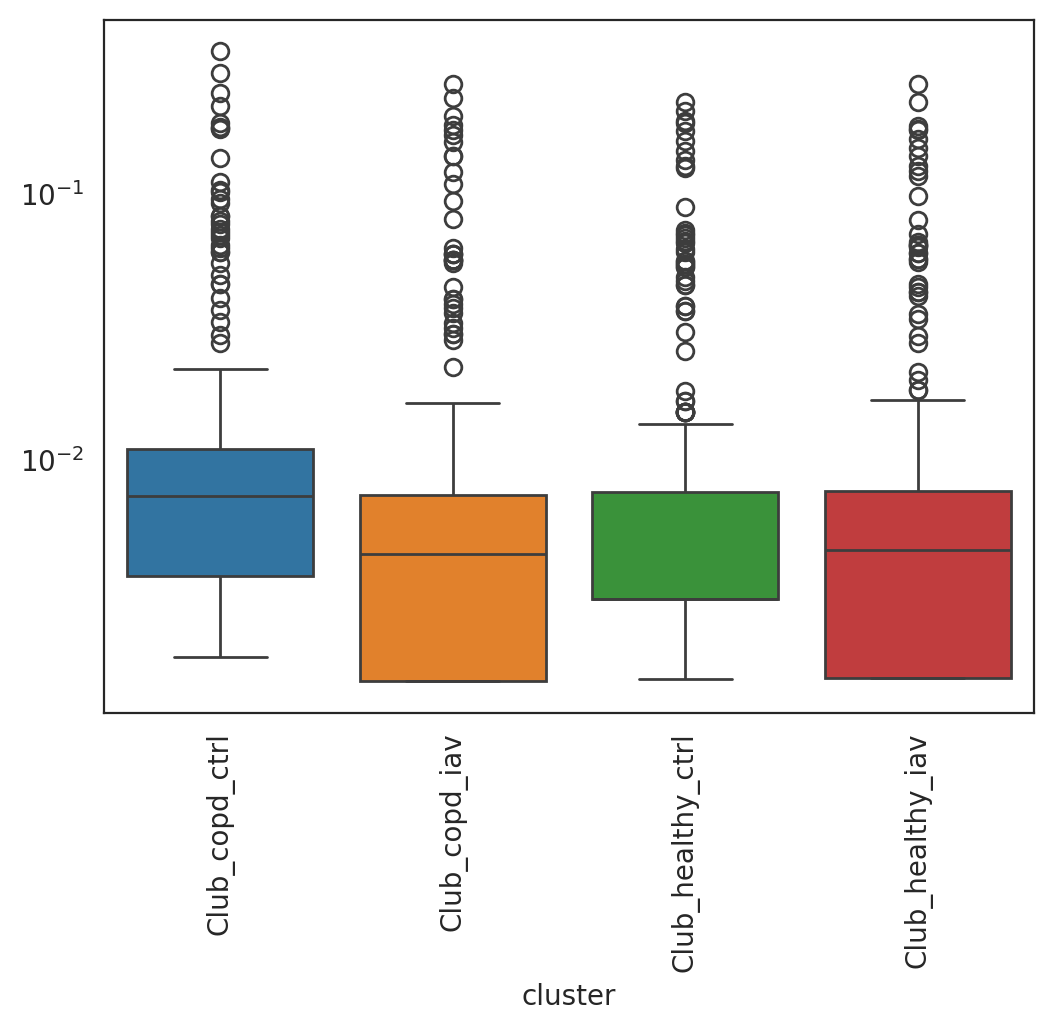

In [192]:
import seaborn as sns
df = (
    links.merged_score
    .assign(group=lambda x: x['cluster'].str.split('_').apply(lambda y: '_'.join(y[-2:])))
    .assign(disease=lambda x: x['group'].str.split('_').str[0])
    .assign(infection=lambda x: x['group'].str.split('_').str[1])
    .assign(cell_compartment=lambda x: x['cluster'].str.split('_').str[0])
)
df = df[df['cell_compartment'] == 'Club']
df = df.pivot_table(columns='cluster', index=df.index, values='degree_centrality_all')
sns.boxplot(df)
plt.yscale('log')
plt.xticks(rotation=90)
df

In [182]:
df[df['cell_compartment'] == 'Unknown']

degree_all  degree_centrality_all  degree_in  degree_centrality_in  \
HESX1            12               0.015584          0              0.000000   
BPIFA1            3               0.003896          3              0.003896   
SNAI2            36               0.046753          3              0.003896   
KRT5              8               0.010390          8              0.010390   
RFX2            159               0.206494          3              0.003896   
...             ...                    ...        ...                   ...   
CCDC181           1               0.001282          1              0.001282   
NEK10             1               0.001282          1              0.001282   
CD274             1               0.001282          1              0.001282   
KPNA2             2               0.002564          2              0.002564   
BATF2             1               0.001282          1              0.001282   

         degree_out  degree_centrality_out  betweenness_centrality  \
HESX1            12               0.015584                     0.0   
BPIFA1            0               0.000000                     0.0   
SNAI2            33               0.042857                   216.0   
KRT5              0               0.000000                     0.0   
RFX2            156               0.202597                  1268.0   
...             ...                    ...                     ...   
CCDC181           0               0.000000                     0.0   
NEK10             0               0.000000                     0.0   
CD274             0               0.000000                     0.0   
KPNA2             0               0.000000                     0.0   
BATF2             0               0.000000                     0.0   

         eigenvector_centrality              cluster        group  disease  \
HESX1                  0.016957    Unknown_copd_ctrl    copd_ctrl     copd   
BPIFA1                 0.006164    Unknown_copd_ctrl    copd_ctrl     copd   
SNAI2                  0.295890    Unknown_copd_ctrl    copd_ctrl     copd   
KRT5                   0.292701    Unknown_copd_ctrl    copd_ctrl     copd   
RFX2                   0.176237    Unknown_copd_ctrl    copd_ctrl     copd   
...                         ...                  ...          ...      ...   
CCDC181                0.001836  Unknown_healthy_iav  healthy_iav  healthy   
NEK10                  0.002739  Unknown_healthy_iav  healthy_iav  healthy   
CD274                  0.002642  Unknown_healthy_iav  healthy_iav  healthy   
KPNA2                  0.002084  Unknown_healthy_iav  healthy_iav  healthy   
BATF2                  0.002635  Unknown_healthy_iav  healthy_iav  healthy   

        infection cell_compartment  
HESX1        ctrl          Unknown  
BPIFA1       ctrl          Unknown  
SNAI2        ctrl          Unknown  
KRT5         ctrl          Unknown  
RFX2         ctrl          Unknown  
...           ...              ...  
CCDC181       iav          Unknown  
NEK10         iav          Unknown  
CD274         iav          Unknown  
KPNA2         iav          Unknown  
BATF2         iav          Unknown  

[3120 rows x 13 columns]

In [147]:
df = df.pivot_table(columns='group', index=df.index, values='degree_centrality_all')

group      copd_ctrl  copd_iav  healthy_ctrl  healthy_iav
ABCA1       0.004829  0.003961      0.003566     0.003182
ACBD3-AS1   0.002001  0.002204      0.001831     0.001826
ACKR3       0.003865  0.003345      0.003526     0.004050
ACTB        0.012819  0.011903      0.011643     0.010733
ACTG1       0.013507  0.013816      0.013207     0.013569
...              ...       ...           ...          ...
ZMYND10     0.006232  0.005873      0.005531     0.004887
ZMYND12     0.003150  0.003101      0.001529     0.004739
ZNF487      0.003469  0.002911      0.002898     0.003931
ZNF683      0.007270  0.008858      0.006772     0.013286
ZWINT       0.002501  0.003058      0.004710     0.006250

[1076 rows x 4 columns]

In [130]:
filtered_df

degree_all                              1
degree_centrality_all            0.001563
degree_in                               1
degree_centrality_in             0.001563
degree_out                              0
degree_centrality_out                 0.0
betweenness_centrality                0.0
eigenvector_centrality           0.023128
cluster                   Basal_copd_ctrl
group                           copd_ctrl
disease                              copd
infection                            ctrl
cell_compartment                    Basal
Name: LAMA1, dtype: object

In [133]:
type(filtered_df['cell_compartment'])

pandas.core.series.Series

In [128]:
type(filtered_df['cell_compartment'])


str

In [107]:
set(df.loc['MT1G']['group'].unique()) == set(df['group'].unique())

True

In [103]:
set(df['group'].unique())

{'copd_ctrl', 'copd_iav', 'healthy_ctrl', 'healthy_iav'}

In [113]:
genes = [gene for gene in df.index.unique() if set(df.loc[gene]['group'].unique()) == set(df['group'].unique())]
genes

AttributeError: 'str' object has no attribute 'unique'

In [68]:
links.merged_score['cluster'].str.split('_')[1] + '_' +links.merged_score['cluster'].str.split('_')[2]

TypeError: can only concatenate list (not "str") to list

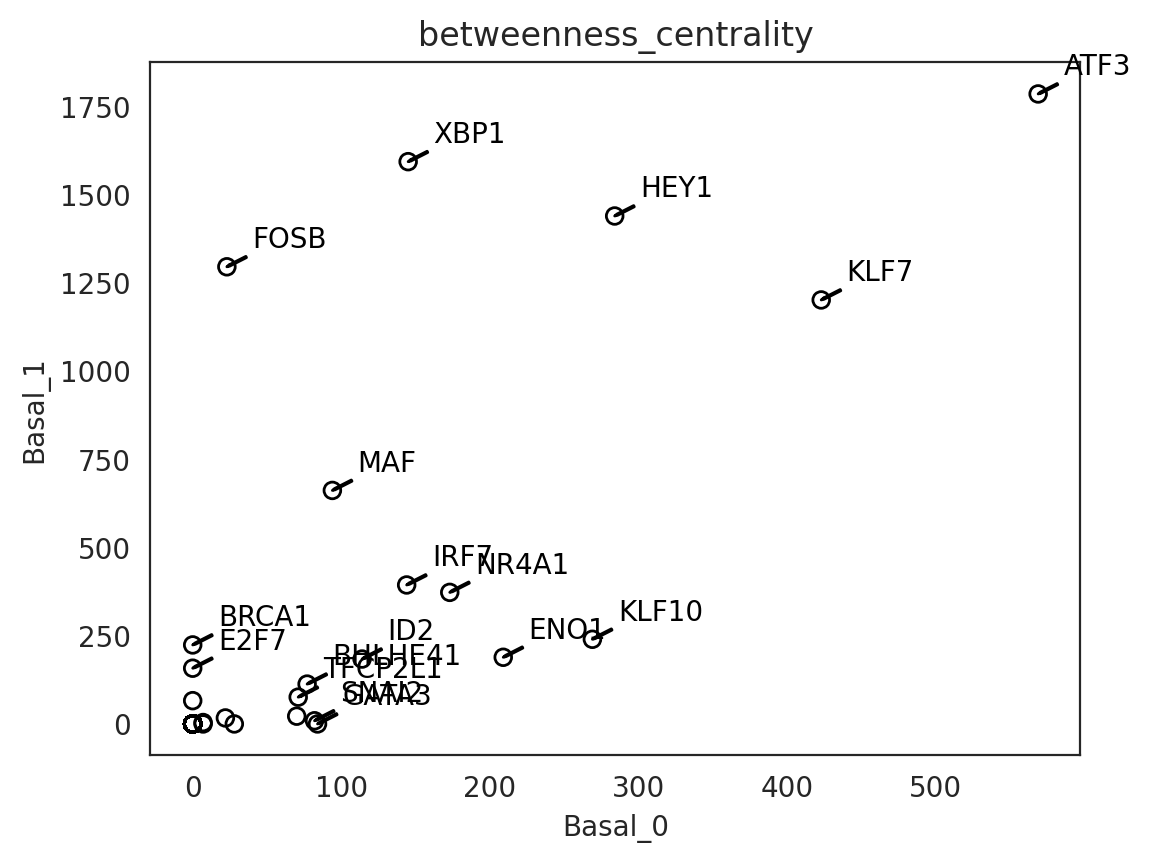

In [ ]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="Basal_0", cluster2="Basal_1", 
                               percentile=98,
                               save=f"{save_folder}/score_comparison")

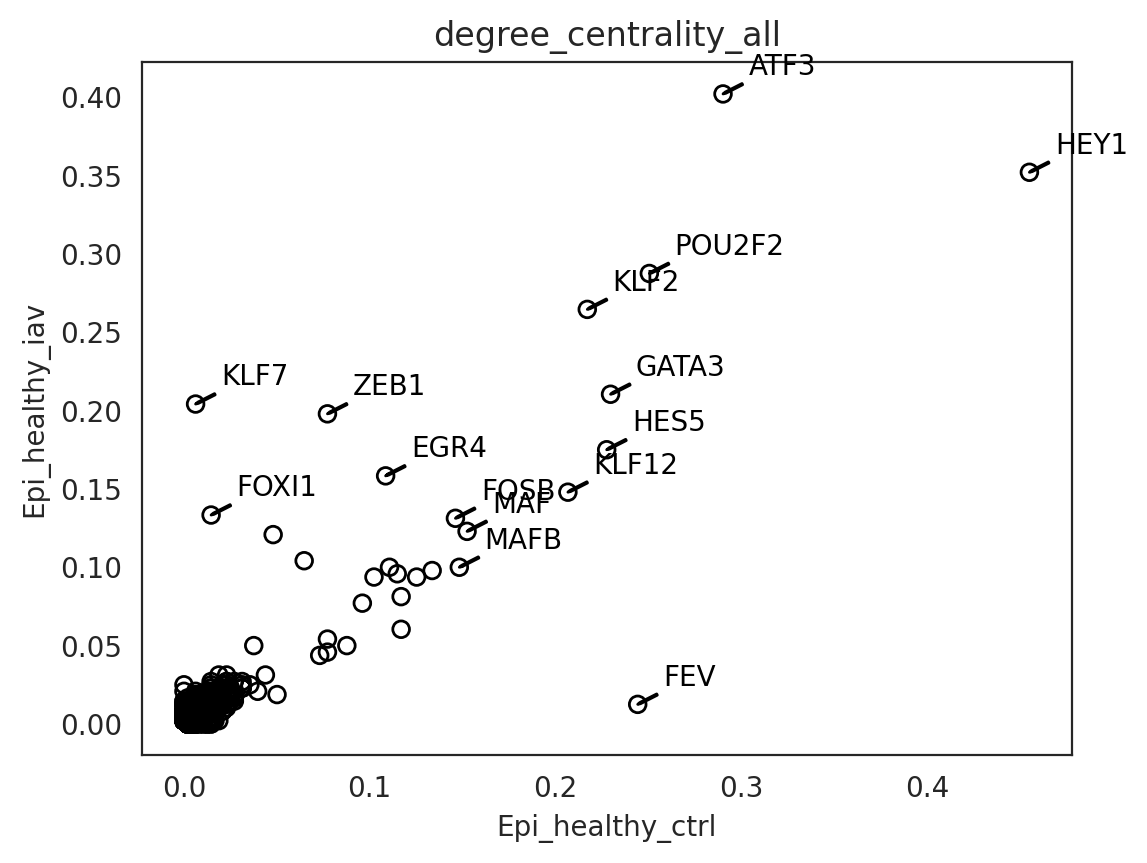

In [55]:
cluster = 'Epi'
disease = 'healthy'
cluster1 = cluster + '_' + disease + '_ctrl'
cluster2 = cluster + '_' + disease + '_iav'
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1=cluster1, cluster2=cluster2, 
                               percentile=98, save=f"{save_folder}/score_comparison")

FOXI1


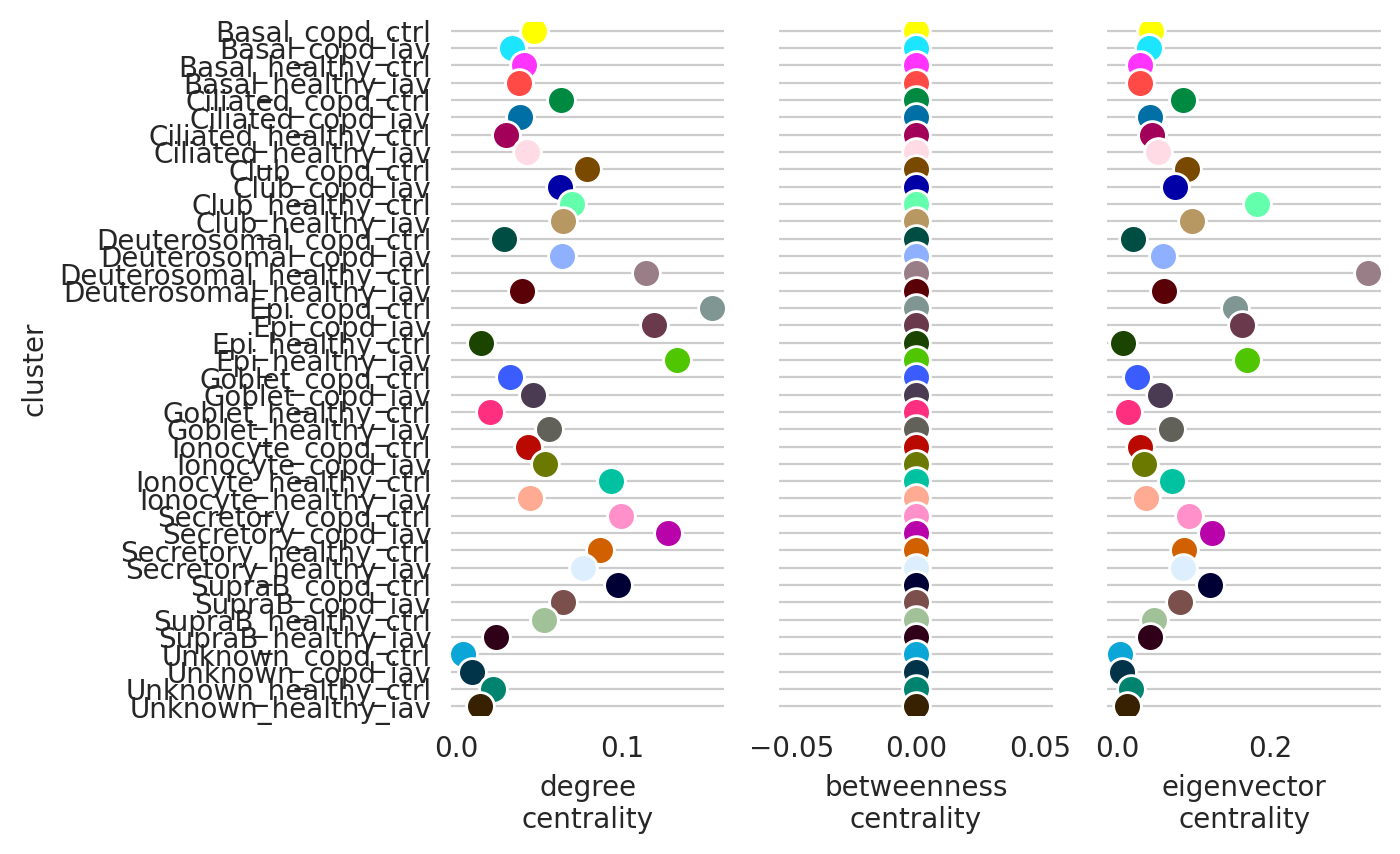

In [56]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="FOXI1", 
                             save=f"{save_folder}/network_score_per_gene/"
                             )

In [ ]:
cluster_name = "MultiC_0"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df

source    target  coef_mean  coef_abs             p      -logp
15356   EGR4     RSPH1  -1.007131  1.007131  1.053425e-16  15.977396
6464    ATF3   FAM216B   0.853744  0.853744  2.260418e-15  14.645811
18359   MAFB    TSPAN1  -0.841276  0.841276  5.573801e-15  14.253849
15712   MAFB     SAXO2  -0.832849  0.832849  1.275686e-12  11.894256
15708   ATF3      SAT1   0.816916  0.816916  5.249049e-19  18.279919
...      ...       ...        ...       ...           ...        ...
18156   ZEB1     TPPP3  -0.069003  0.069003  8.115365e-08   7.090692
16678   EGR4     SPA17  -0.068981  0.068981  3.385485e-11  10.470379
15195   EGR4     RPS24  -0.068918  0.068918  3.333746e-07   6.477067
8030    HEY1  HLA-DPA1   0.068841  0.068841  2.725249e-06   5.564594
1805    ATF3  C1orf158   0.068837  0.068837  4.373698e-11  10.359151

[2000 rows x 6 columns]

In [ ]:
filtered_links_df[filtered_links_df.source == "FOSB"]

source    target  coef_mean  coef_abs             p      -logp
5747    FOSB      DRC3   0.320534  0.320534  7.193358e-06   5.143068
14933   FOSB    ROPN1L   0.287557  0.287557  1.426263e-04   3.845800
4831    FOSB    CXCL17   0.226098  0.226098  3.488654e-13  12.457342
1516    FOSB    BPIFB1   0.221110  0.221110  1.706512e-19  18.767891
14976   FOSB    RPL10A   0.208348  0.208348  5.025101e-07   6.298855
19058   FOSB     WFDC2   0.198936  0.198936  5.862266e-15  14.231934
6463    FOSB   FAM216B   0.185865  0.185865  6.554116e-04   3.183486
5066    FOSB      DAW1   0.182165  0.182165  4.328955e-05   4.363617
16794   FOSB   SPATA17   0.147389  0.147389  6.842182e-05   4.164805
15782   FOSB   SCGB3A1   0.143139  0.143139  3.981231e-13  12.399983
7110    FOSB      GBP6   0.141313  0.141313  6.533833e-09   8.184832
4884    FOSB     CXCL8   0.139625  0.139625  1.464012e-11  10.834455
15209   FOSB     RPS27   0.138287  0.138287  6.027923e-09   8.219832
6343    FOSB        F3   0.130935  0.130935  9.645559e-15  14.015673
8477    FOSB      IFI6   0.128123  0.128123  2.349132e-06   5.629093
3239    FOSB   CEACAM6   0.118953  0.118953  1.065374e-12  11.972498
8052    FOSB  HLA-DQA1   0.116028  0.116028  1.548922e-10   9.809970
15243   FOSB     RPS29   0.111436  0.111436  2.200184e-06   5.657541
15120   FOSB     RPL41   0.109262  0.109262  1.060760e-07   6.974383
11464   FOSB       MDK   0.106916  0.106916  2.171639e-15  14.663212
18015   FOSB    TMSB4X   0.083150  0.083150  1.099994e-09   8.958610
15134   FOSB      RPL6   0.080760  0.080760  3.408124e-11  10.467485
13049   FOSB    PARP14   0.073412  0.073412  1.171929e-05   4.931099
15841   FOSB   SELENOP   0.073389  0.073389  2.123544e-08   7.672939
10175   FOSB      LDHA   0.071888  0.071888  9.479295e-15  14.023224
4708    FOSB      CTSB   0.070440  0.070440  1.208879e-13  12.917617

In [ ]:
plt.rcParams["figure.figsize"] = [6, 4.5]

degree_centrality_all


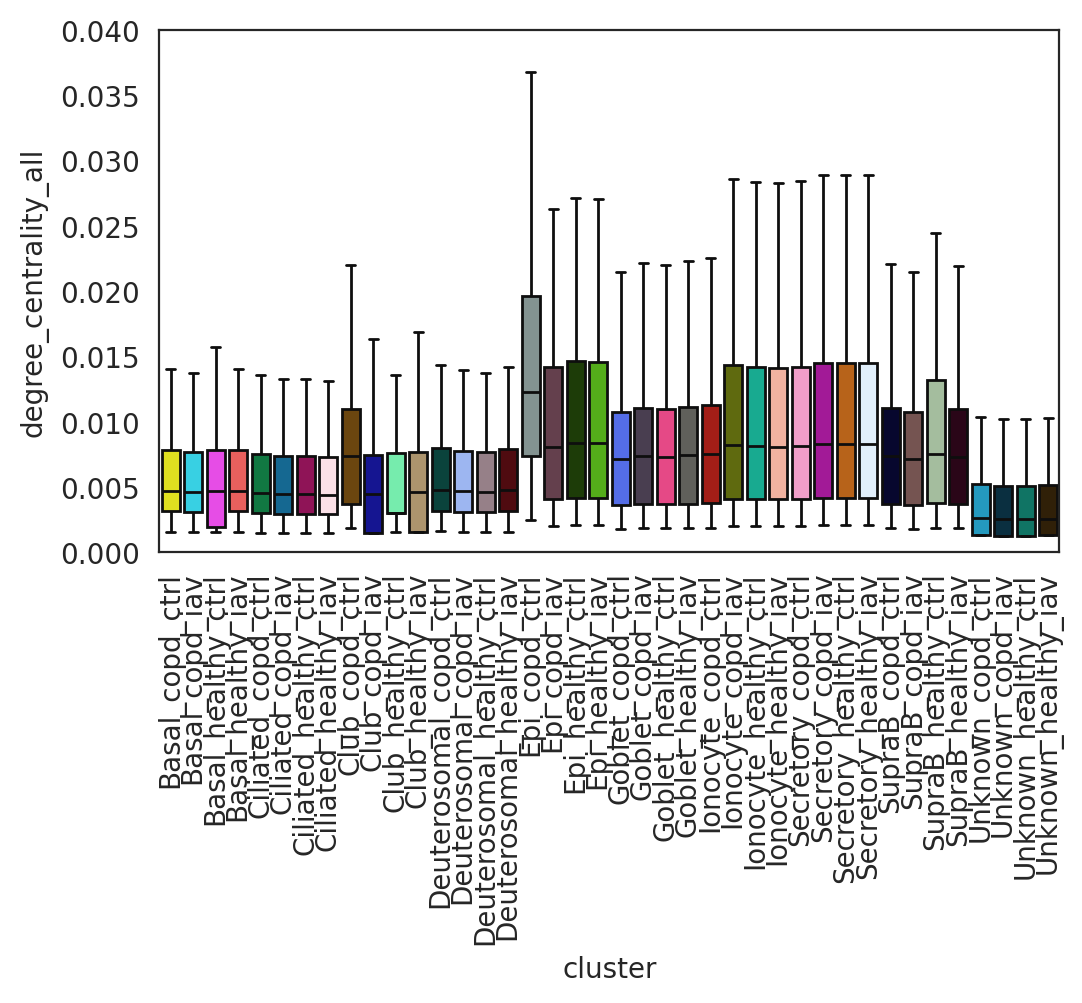

In [51]:
# Plot degree_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"], 
                               method="boxplot", 
                               #save=f"{save_folder}",
                              )

eigenvector_centrality


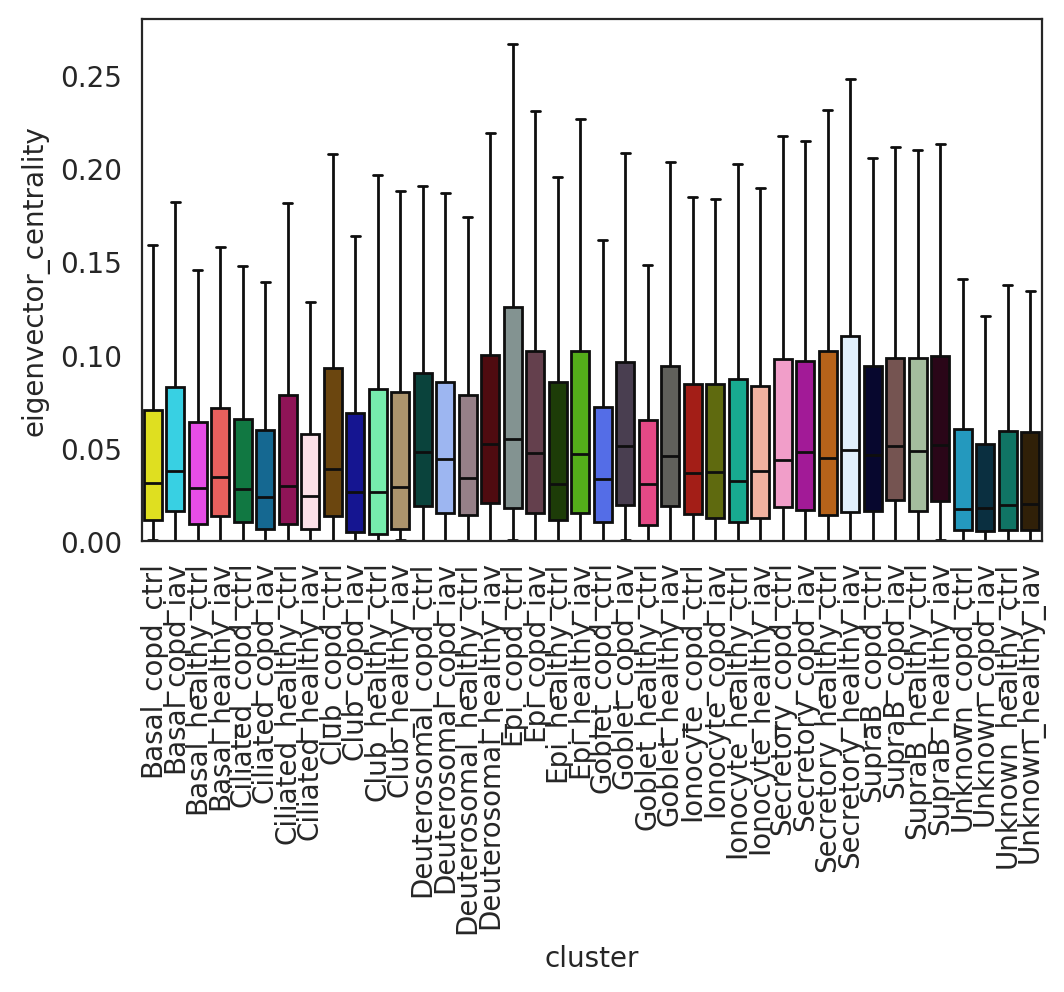

In [136]:
# Plot eigenvector_centrality
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.28])
links.plot_score_discributions(values=["eigenvector_centrality"],
                               method="boxplot",
                               save=f"{save_folder}")


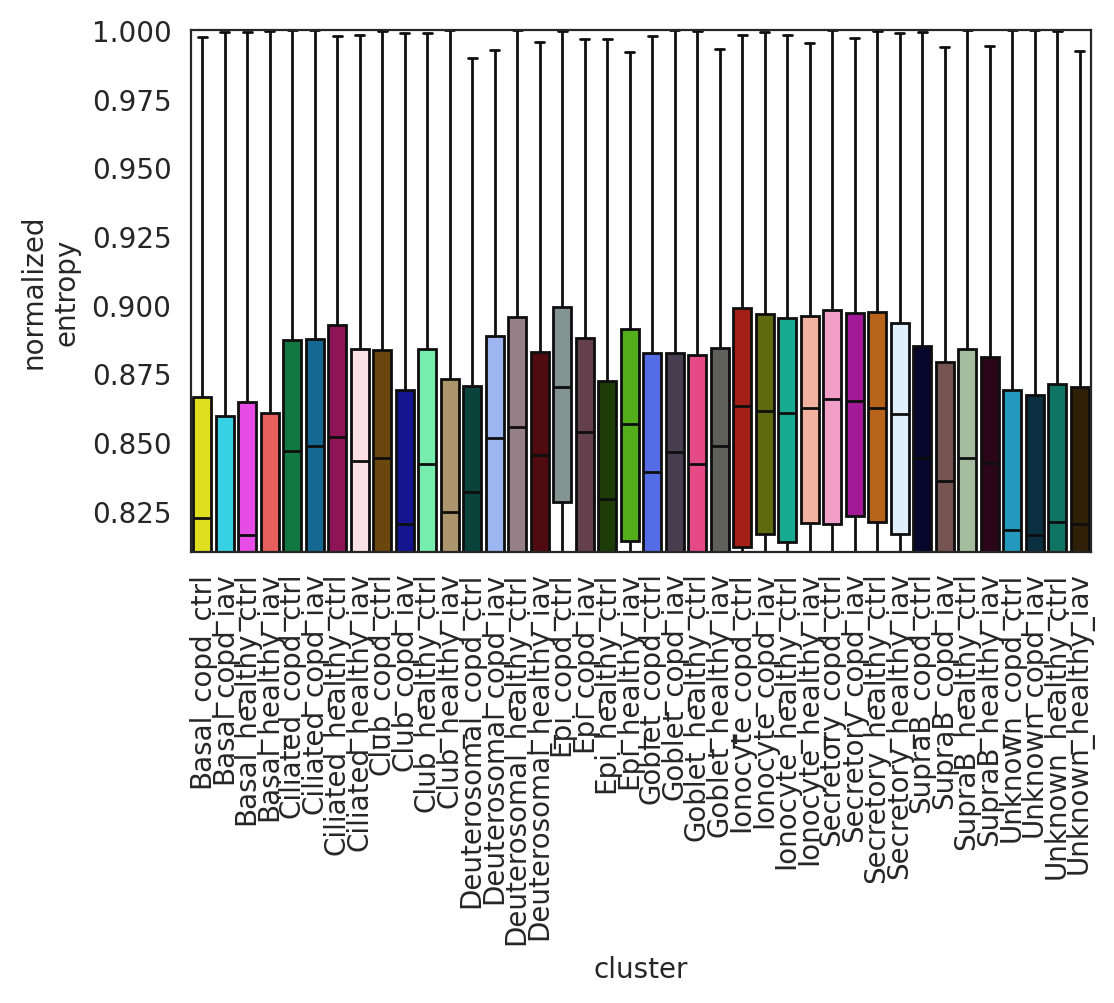

In [135]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions(save=f"{save_folder}")